### CamemBERT

Fine tune modèle camembert

Deuxième modèle qui fait NER et trouve les entités de lieu

#### Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
# python -m pip install accelerate
# pip install transformers

from transformers import CamembertForSequenceClassification, AdamW, CamembertTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np

import random

c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Tester avec un autre dataset

In [88]:
# pour tester avec un dataset de test de quelqu'un d'autre 
df_other_test = pd.read_csv('other_dataset_test.csv')

sentences_other_test = df_other_test['sentence'].tolist()
labels_other_test = df_other_test['label'].tolist()

print(df_other_test['label'].value_counts())
print(df_other_test.shape)

label
1    236
0    235
Name: count, dtype: int64
(471, 2)


#### Création du dataset de TRAIN

In [2]:
df_valid = pd.read_csv('valid_sentences_train_dataset.csv')
df_invalid = pd.read_csv('invalid_sentences_train_dataset.csv')

df_combined = pd.concat([df_valid, df_invalid], ignore_index=True)

print("Valeurs manquantes avant traitement :")
print(df_combined.isnull().sum())

train_sentences = df_combined['sentence'].tolist()
train_labels = df_combined['label'].tolist()

print(df_combined['label'].value_counts())
print(df_combined.shape)

Valeurs manquantes avant traitement :
sentence    0
label       0
dtype: int64
label
1    4800
0    4800
Name: count, dtype: int64
(9600, 2)


#### Création du dataset de TEST

In [3]:
df_valid = pd.read_csv('valid_sentences_test_dataset.csv')
df_invalid = pd.read_csv('invalid_sentences_test_dataset.csv')

df_combined = pd.concat([df_valid, df_invalid], ignore_index=True)

print("Valeurs manquantes avant traitement :")
print(df_combined.isnull().sum())

test_sentences = df_combined['sentence'].tolist()
test_labels = df_combined['label'].tolist()

print(df_combined['label'].value_counts())
print(df_combined.shape)

Valeurs manquantes avant traitement :
sentence    0
label       0
dtype: int64
label
1    1200
0    1200
Name: count, dtype: int64
(2400, 2)


In [ ]:
# train_test_split
# train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

In [90]:
# pour tester avec un dataset de test de quelqu'un d'autre 
test_sentences = sentences_other_test
test_labels = labels_other_test

In [4]:
random_indices = random.sample(range(len(train_sentences)), 20)

for idx in random_indices:
    print(train_sentences[idx])

Je voudrais un itinéraire de Magenta à Anglès avec une étape à La Villedieu-en-Fontenette.
Trajet avec une escale à Baugé-en-Anjou entre Pollionnay et La Flamengrie.
Je souhaite réserver un billet de Autigny-le-Petit à Cléry-en-Vexin.
Voyage de Any-Martin-Rieux à Jablines avec un arrêt à Fournaudin.
Quel est le prochain train de Monze à Marieux ?Je voudrais trouver un train de Monze à Marieux ?
Y a-t-il des trains de Ablainzevelle à Lacourt-Saint-Pierre demain ?
Quel est l'itinéraire recommandé entre Hauville et Noyal-Châtillon-sur-Seiche ?
Me rendre à Hermillon avec une étape à Ytrac, en partant de Calonne-Ricouart.
Je veux voyager de Bus à Villechenève.
Départ de Valdampierre, avec un arrêt à Arvillard avant La Chapelle-Montligeon.
Quel est le meilleur chemin entre Vernay et Clarafond-Arcine ?
Pouvez-vous me trouver un train de Saint-Généroux à Cangey ?
Itinéraire entre Bassercles et Thory, en passant par Éloie.
Comment rejoindre Merris via Belfahy, en partant de Neuville-lez-Beaulie

#### Les modèles

##### Model Camembert Base

In [8]:
# charge le tokenizer pré-entraîné pour le modèle camembert-base
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

##### Model Distil Camembert

The aim of distillation is to drastically reduce the complexity of the model while preserving the performances.

In [5]:
# charge le tokenizer pré-entraîné pour le modèle distilcamembert-base
tokenizer = CamembertTokenizer.from_pretrained("cmarkea/distilcamembert-base")

#### Classe pour créer un dataset personnalisé

In [6]:
class CustomDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(sentence, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)
        return item

#### Création des datasets d'entraînement et de test

In [7]:
# préparer les datasets d'entraînement et de test
train_dataset = CustomDataset(train_sentences, train_labels, tokenizer)
test_dataset = CustomDataset(test_sentences, test_labels, tokenizer)

#### Entraînement du modèle

In [8]:
# définir les arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=1,
)

In [9]:
# fonction de calcul du F1-score
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    return {"f1": f1}

In [10]:
model = AutoModelForSequenceClassification.from_pretrained("cmarkea/distilcamembert-base", num_labels=2)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# créer instance de Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics      # for learning curve
)

In [12]:
trainer.train()

  0%|          | 1/1500 [00:12<5:22:43, 12.92s/it]

{'loss': 0.6937, 'grad_norm': 1.1370640993118286, 'learning_rate': 1.9986666666666666e-05, 'epoch': 0.01}


  0%|          | 2/1500 [00:23<4:54:37, 11.80s/it]

{'loss': 0.7133, 'grad_norm': 2.486010789871216, 'learning_rate': 1.9973333333333334e-05, 'epoch': 0.01}


  0%|          | 3/1500 [00:34<4:44:37, 11.41s/it]

{'loss': 0.6876, 'grad_norm': 0.7723401784896851, 'learning_rate': 1.9960000000000002e-05, 'epoch': 0.02}


  0%|          | 4/1500 [00:45<4:40:55, 11.27s/it]

{'loss': 0.7025, 'grad_norm': 3.0359129905700684, 'learning_rate': 1.9946666666666667e-05, 'epoch': 0.03}


  0%|          | 5/1500 [00:56<4:32:26, 10.93s/it]

{'loss': 0.7027, 'grad_norm': 1.3518116474151611, 'learning_rate': 1.9933333333333334e-05, 'epoch': 0.03}


  0%|          | 6/1500 [01:06<4:28:26, 10.78s/it]

{'loss': 0.7084, 'grad_norm': 1.665199637413025, 'learning_rate': 1.9920000000000002e-05, 'epoch': 0.04}


  0%|          | 7/1500 [01:18<4:32:19, 10.94s/it]

{'loss': 0.6815, 'grad_norm': 1.2145469188690186, 'learning_rate': 1.9906666666666667e-05, 'epoch': 0.05}


  1%|          | 8/1500 [01:28<4:29:59, 10.86s/it]

{'loss': 0.6916, 'grad_norm': 1.6521180868148804, 'learning_rate': 1.9893333333333335e-05, 'epoch': 0.05}


  1%|          | 9/1500 [01:39<4:27:54, 10.78s/it]

{'loss': 0.6956, 'grad_norm': 0.9719966650009155, 'learning_rate': 1.9880000000000003e-05, 'epoch': 0.06}


  1%|          | 10/1500 [01:49<4:25:08, 10.68s/it]

{'loss': 0.6859, 'grad_norm': 1.224202036857605, 'learning_rate': 1.9866666666666667e-05, 'epoch': 0.07}


  1%|          | 11/1500 [02:00<4:24:14, 10.65s/it]

{'loss': 0.7303, 'grad_norm': 4.262364864349365, 'learning_rate': 1.9853333333333335e-05, 'epoch': 0.07}


  1%|          | 12/1500 [02:11<4:25:11, 10.69s/it]

{'loss': 0.7242, 'grad_norm': 3.486875295639038, 'learning_rate': 1.9840000000000003e-05, 'epoch': 0.08}


  1%|          | 13/1500 [02:21<4:23:20, 10.63s/it]

{'loss': 0.7127, 'grad_norm': 3.1164157390594482, 'learning_rate': 1.9826666666666668e-05, 'epoch': 0.09}


  1%|          | 14/1500 [02:31<4:20:57, 10.54s/it]

{'loss': 0.7227, 'grad_norm': 4.64567232131958, 'learning_rate': 1.9813333333333336e-05, 'epoch': 0.09}


  1%|          | 15/1500 [02:42<4:19:58, 10.50s/it]

{'loss': 0.721, 'grad_norm': 2.5034940242767334, 'learning_rate': 1.98e-05, 'epoch': 0.1}


  1%|          | 16/1500 [02:52<4:19:46, 10.50s/it]

{'loss': 0.6904, 'grad_norm': 5.712075710296631, 'learning_rate': 1.9786666666666668e-05, 'epoch': 0.11}


  1%|          | 17/1500 [03:03<4:18:35, 10.46s/it]

{'loss': 0.7113, 'grad_norm': 3.4206230640411377, 'learning_rate': 1.9773333333333336e-05, 'epoch': 0.11}


  1%|          | 18/1500 [03:13<4:17:32, 10.43s/it]

{'loss': 0.703, 'grad_norm': 4.424863338470459, 'learning_rate': 1.976e-05, 'epoch': 0.12}


  1%|▏         | 19/1500 [03:23<4:15:54, 10.37s/it]

{'loss': 0.7043, 'grad_norm': 3.3791985511779785, 'learning_rate': 1.974666666666667e-05, 'epoch': 0.13}


  1%|▏         | 20/1500 [03:34<4:16:07, 10.38s/it]

{'loss': 0.6878, 'grad_norm': 1.5824528932571411, 'learning_rate': 1.9733333333333336e-05, 'epoch': 0.13}


  1%|▏         | 21/1500 [03:44<4:14:57, 10.34s/it]

{'loss': 0.6881, 'grad_norm': 3.2455058097839355, 'learning_rate': 1.972e-05, 'epoch': 0.14}


  1%|▏         | 22/1500 [03:54<4:13:37, 10.30s/it]

{'loss': 0.6947, 'grad_norm': 2.2443888187408447, 'learning_rate': 1.970666666666667e-05, 'epoch': 0.15}


  2%|▏         | 23/1500 [04:04<4:11:50, 10.23s/it]

{'loss': 0.6919, 'grad_norm': 1.2894893884658813, 'learning_rate': 1.9693333333333337e-05, 'epoch': 0.15}


  2%|▏         | 24/1500 [04:14<4:11:33, 10.23s/it]

{'loss': 0.7124, 'grad_norm': 7.072972774505615, 'learning_rate': 1.968e-05, 'epoch': 0.16}


  2%|▏         | 25/1500 [04:25<4:11:08, 10.22s/it]

{'loss': 0.701, 'grad_norm': 2.1812584400177, 'learning_rate': 1.9666666666666666e-05, 'epoch': 0.17}


  2%|▏         | 26/1500 [04:35<4:11:06, 10.22s/it]

{'loss': 0.6837, 'grad_norm': 1.2000011205673218, 'learning_rate': 1.9653333333333334e-05, 'epoch': 0.17}


  2%|▏         | 27/1500 [04:45<4:11:12, 10.23s/it]

{'loss': 0.7002, 'grad_norm': 3.475663900375366, 'learning_rate': 1.9640000000000002e-05, 'epoch': 0.18}


  2%|▏         | 28/1500 [04:55<4:11:01, 10.23s/it]

{'loss': 0.693, 'grad_norm': 1.5820509195327759, 'learning_rate': 1.9626666666666666e-05, 'epoch': 0.19}


  2%|▏         | 29/1500 [05:07<4:22:17, 10.70s/it]

{'loss': 0.702, 'grad_norm': 1.6679420471191406, 'learning_rate': 1.9613333333333334e-05, 'epoch': 0.19}


  2%|▏         | 30/1500 [05:19<4:27:42, 10.93s/it]

{'loss': 0.6872, 'grad_norm': 1.7113198041915894, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.2}


  2%|▏         | 31/1500 [05:30<4:27:17, 10.92s/it]

{'loss': 0.711, 'grad_norm': 2.4353389739990234, 'learning_rate': 1.9586666666666667e-05, 'epoch': 0.21}


  2%|▏         | 32/1500 [05:41<4:33:44, 11.19s/it]

{'loss': 0.7033, 'grad_norm': 1.9745221138000488, 'learning_rate': 1.9573333333333335e-05, 'epoch': 0.21}


  2%|▏         | 33/1500 [07:49<4:32:46, 11.16s/it]

{'loss': 0.6888, 'grad_norm': 1.2781977653503418, 'learning_rate': 1.9560000000000002e-05, 'epoch': 0.22}


  2%|▏         | 34/1500 [08:01<18:56:33, 46.52s/it]

{'loss': 0.7077, 'grad_norm': 2.9244496822357178, 'learning_rate': 1.954666666666667e-05, 'epoch': 0.23}


  2%|▏         | 35/1500 [08:09<14:12:55, 34.93s/it]

{'loss': 0.7099, 'grad_norm': 1.4201080799102783, 'learning_rate': 1.9533333333333335e-05, 'epoch': 0.23}


  2%|▏         | 36/1500 [08:17<10:52:29, 26.74s/it]

{'loss': 0.7044, 'grad_norm': 1.8477967977523804, 'learning_rate': 1.9520000000000003e-05, 'epoch': 0.24}


  2%|▏         | 37/1500 [08:24<8:26:44, 20.78s/it] 

{'loss': 0.6958, 'grad_norm': 1.3972710371017456, 'learning_rate': 1.950666666666667e-05, 'epoch': 0.25}


  3%|▎         | 38/1500 [08:32<6:57:17, 17.13s/it]

{'loss': 0.6883, 'grad_norm': 0.8961260914802551, 'learning_rate': 1.9493333333333335e-05, 'epoch': 0.25}


  3%|▎         | 39/1500 [08:40<5:49:27, 14.35s/it]

{'loss': 0.6815, 'grad_norm': 1.5920783281326294, 'learning_rate': 1.948e-05, 'epoch': 0.26}


  3%|▎         | 40/1500 [08:48<5:02:43, 12.44s/it]

{'loss': 0.6871, 'grad_norm': 1.865262746810913, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.27}


  3%|▎         | 41/1500 [08:56<4:30:33, 11.13s/it]

{'loss': 0.7039, 'grad_norm': 1.6492366790771484, 'learning_rate': 1.9453333333333336e-05, 'epoch': 0.27}


  3%|▎         | 42/1500 [09:04<4:06:28, 10.14s/it]

{'loss': 0.6819, 'grad_norm': 1.5536595582962036, 'learning_rate': 1.944e-05, 'epoch': 0.28}


  3%|▎         | 43/1500 [09:12<3:48:26,  9.41s/it]

{'loss': 0.6892, 'grad_norm': 1.0784575939178467, 'learning_rate': 1.9426666666666668e-05, 'epoch': 0.29}


  3%|▎         | 44/1500 [09:19<3:33:21,  8.79s/it]

{'loss': 0.6924, 'grad_norm': 1.2800897359848022, 'learning_rate': 1.9413333333333336e-05, 'epoch': 0.29}


  3%|▎         | 45/1500 [09:26<3:21:13,  8.30s/it]

{'loss': 0.7084, 'grad_norm': 0.9198142290115356, 'learning_rate': 1.94e-05, 'epoch': 0.3}


  3%|▎         | 46/1500 [09:33<3:11:17,  7.89s/it]

{'loss': 0.6919, 'grad_norm': 1.0878512859344482, 'learning_rate': 1.938666666666667e-05, 'epoch': 0.31}


  3%|▎         | 47/1500 [09:40<3:01:13,  7.48s/it]

{'loss': 0.7039, 'grad_norm': 2.3688838481903076, 'learning_rate': 1.9373333333333336e-05, 'epoch': 0.31}


  3%|▎         | 48/1500 [09:47<2:56:10,  7.28s/it]

{'loss': 0.7076, 'grad_norm': 2.1072564125061035, 'learning_rate': 1.936e-05, 'epoch': 0.32}


  3%|▎         | 49/1500 [09:53<2:50:59,  7.07s/it]

{'loss': 0.6848, 'grad_norm': 1.0555603504180908, 'learning_rate': 1.934666666666667e-05, 'epoch': 0.33}


  3%|▎         | 50/1500 [10:00<2:46:38,  6.90s/it]

{'loss': 0.7205, 'grad_norm': 0.953440248966217, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.33}


  3%|▎         | 51/1500 [10:06<2:43:09,  6.76s/it]

{'loss': 0.6722, 'grad_norm': 2.302220582962036, 'learning_rate': 1.932e-05, 'epoch': 0.34}


  3%|▎         | 52/1500 [10:13<2:41:20,  6.69s/it]

{'loss': 0.6999, 'grad_norm': 1.1656750440597534, 'learning_rate': 1.930666666666667e-05, 'epoch': 0.35}


  4%|▎         | 53/1500 [10:19<2:38:44,  6.58s/it]

{'loss': 0.6975, 'grad_norm': 0.8124645352363586, 'learning_rate': 1.9293333333333334e-05, 'epoch': 0.35}


  4%|▎         | 54/1500 [10:26<2:40:24,  6.66s/it]

{'loss': 0.6932, 'grad_norm': 0.9316781759262085, 'learning_rate': 1.9280000000000002e-05, 'epoch': 0.36}


  4%|▎         | 55/1500 [10:32<2:38:37,  6.59s/it]

{'loss': 0.6925, 'grad_norm': 0.8798613548278809, 'learning_rate': 1.926666666666667e-05, 'epoch': 0.37}


  4%|▎         | 56/1500 [10:39<2:37:21,  6.54s/it]

{'loss': 0.7088, 'grad_norm': 1.1630008220672607, 'learning_rate': 1.9253333333333334e-05, 'epoch': 0.37}


  4%|▍         | 57/1500 [10:45<2:36:45,  6.52s/it]

{'loss': 0.6937, 'grad_norm': 2.3542392253875732, 'learning_rate': 1.9240000000000002e-05, 'epoch': 0.38}


  4%|▍         | 58/1500 [10:52<2:36:22,  6.51s/it]

{'loss': 0.6787, 'grad_norm': 0.9170429110527039, 'learning_rate': 1.922666666666667e-05, 'epoch': 0.39}


  4%|▍         | 59/1500 [10:58<2:35:38,  6.48s/it]

{'loss': 0.69, 'grad_norm': 0.9940947890281677, 'learning_rate': 1.9213333333333335e-05, 'epoch': 0.39}


  4%|▍         | 60/1500 [11:05<2:35:37,  6.48s/it]

{'loss': 0.7008, 'grad_norm': 1.3538517951965332, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.4}


  4%|▍         | 61/1500 [11:11<2:35:33,  6.49s/it]

{'loss': 0.6945, 'grad_norm': 2.072626829147339, 'learning_rate': 1.918666666666667e-05, 'epoch': 0.41}


  4%|▍         | 62/1500 [11:18<2:38:05,  6.60s/it]

{'loss': 0.6861, 'grad_norm': 2.0868654251098633, 'learning_rate': 1.9173333333333335e-05, 'epoch': 0.41}


  4%|▍         | 63/1500 [11:25<2:40:42,  6.71s/it]

{'loss': 0.703, 'grad_norm': 0.7136276960372925, 'learning_rate': 1.916e-05, 'epoch': 0.42}


  4%|▍         | 64/1500 [11:32<2:42:43,  6.80s/it]

{'loss': 0.6985, 'grad_norm': 1.8624993562698364, 'learning_rate': 1.9146666666666667e-05, 'epoch': 0.43}


  4%|▍         | 65/1500 [11:39<2:42:56,  6.81s/it]

{'loss': 0.698, 'grad_norm': 1.4738249778747559, 'learning_rate': 1.9133333333333335e-05, 'epoch': 0.43}


  4%|▍         | 66/1500 [11:46<2:45:00,  6.90s/it]

{'loss': 0.7057, 'grad_norm': 1.951915979385376, 'learning_rate': 1.912e-05, 'epoch': 0.44}


  4%|▍         | 67/1500 [11:53<2:46:11,  6.96s/it]

{'loss': 0.6948, 'grad_norm': 3.303755044937134, 'learning_rate': 1.9106666666666668e-05, 'epoch': 0.45}


  5%|▍         | 68/1500 [12:00<2:47:47,  7.03s/it]

{'loss': 0.6959, 'grad_norm': 0.738521933555603, 'learning_rate': 1.9093333333333336e-05, 'epoch': 0.45}


  5%|▍         | 69/1500 [12:07<2:46:23,  6.98s/it]

{'loss': 0.698, 'grad_norm': 0.9471526145935059, 'learning_rate': 1.908e-05, 'epoch': 0.46}


  5%|▍         | 70/1500 [12:14<2:45:38,  6.95s/it]

{'loss': 0.6959, 'grad_norm': 1.0406936407089233, 'learning_rate': 1.9066666666666668e-05, 'epoch': 0.47}


  5%|▍         | 71/1500 [12:21<2:44:57,  6.93s/it]

{'loss': 0.697, 'grad_norm': 1.0496788024902344, 'learning_rate': 1.9053333333333336e-05, 'epoch': 0.47}


  5%|▍         | 72/1500 [12:28<2:43:50,  6.88s/it]

{'loss': 0.6998, 'grad_norm': 1.9024187326431274, 'learning_rate': 1.904e-05, 'epoch': 0.48}


  5%|▍         | 73/1500 [12:34<2:43:45,  6.89s/it]

{'loss': 0.6971, 'grad_norm': 0.9768129587173462, 'learning_rate': 1.902666666666667e-05, 'epoch': 0.49}


  5%|▍         | 74/1500 [12:41<2:41:22,  6.79s/it]

{'loss': 0.6896, 'grad_norm': 1.5980435609817505, 'learning_rate': 1.9013333333333333e-05, 'epoch': 0.49}


  5%|▌         | 75/1500 [12:47<2:38:46,  6.69s/it]

{'loss': 0.7065, 'grad_norm': 2.528604030609131, 'learning_rate': 1.9e-05, 'epoch': 0.5}


  5%|▌         | 76/1500 [12:54<2:37:39,  6.64s/it]

{'loss': 0.7004, 'grad_norm': 1.1469451189041138, 'learning_rate': 1.898666666666667e-05, 'epoch': 0.51}


  5%|▌         | 77/1500 [13:00<2:36:05,  6.58s/it]

{'loss': 0.6902, 'grad_norm': 0.752525269985199, 'learning_rate': 1.8973333333333334e-05, 'epoch': 0.51}


  5%|▌         | 78/1500 [13:07<2:35:29,  6.56s/it]

{'loss': 0.7126, 'grad_norm': 1.0364980697631836, 'learning_rate': 1.896e-05, 'epoch': 0.52}


  5%|▌         | 79/1500 [13:13<2:34:25,  6.52s/it]

{'loss': 0.6886, 'grad_norm': 0.8933436870574951, 'learning_rate': 1.894666666666667e-05, 'epoch': 0.53}


  5%|▌         | 80/1500 [13:20<2:36:48,  6.63s/it]

{'loss': 0.6962, 'grad_norm': 1.3397756814956665, 'learning_rate': 1.8933333333333334e-05, 'epoch': 0.53}


  5%|▌         | 81/1500 [13:27<2:35:58,  6.60s/it]

{'loss': 0.7012, 'grad_norm': 2.197399616241455, 'learning_rate': 1.8920000000000002e-05, 'epoch': 0.54}


  5%|▌         | 82/1500 [13:33<2:35:10,  6.57s/it]

{'loss': 0.6938, 'grad_norm': 1.0353070497512817, 'learning_rate': 1.890666666666667e-05, 'epoch': 0.55}


  6%|▌         | 83/1500 [13:40<2:33:24,  6.50s/it]

{'loss': 0.6836, 'grad_norm': 1.1758137941360474, 'learning_rate': 1.8893333333333334e-05, 'epoch': 0.55}


  6%|▌         | 84/1500 [13:46<2:31:13,  6.41s/it]

{'loss': 0.6965, 'grad_norm': 1.9850696325302124, 'learning_rate': 1.8880000000000002e-05, 'epoch': 0.56}


  6%|▌         | 85/1500 [13:52<2:31:07,  6.41s/it]

{'loss': 0.7043, 'grad_norm': 1.6017873287200928, 'learning_rate': 1.886666666666667e-05, 'epoch': 0.57}


  6%|▌         | 86/1500 [13:59<2:30:49,  6.40s/it]

{'loss': 0.7029, 'grad_norm': 0.7156489491462708, 'learning_rate': 1.8853333333333335e-05, 'epoch': 0.57}


  6%|▌         | 87/1500 [14:05<2:31:21,  6.43s/it]

{'loss': 0.687, 'grad_norm': 1.3255988359451294, 'learning_rate': 1.884e-05, 'epoch': 0.58}


  6%|▌         | 88/1500 [14:12<2:31:18,  6.43s/it]

{'loss': 0.6876, 'grad_norm': 1.5545275211334229, 'learning_rate': 1.8826666666666667e-05, 'epoch': 0.59}


  6%|▌         | 89/1500 [14:18<2:31:07,  6.43s/it]

{'loss': 0.7072, 'grad_norm': 1.1117758750915527, 'learning_rate': 1.8813333333333335e-05, 'epoch': 0.59}


  6%|▌         | 90/1500 [14:24<2:30:43,  6.41s/it]

{'loss': 0.695, 'grad_norm': 0.7338157892227173, 'learning_rate': 1.88e-05, 'epoch': 0.6}


  6%|▌         | 91/1500 [14:31<2:32:32,  6.50s/it]

{'loss': 0.703, 'grad_norm': 1.6500182151794434, 'learning_rate': 1.8786666666666667e-05, 'epoch': 0.61}


  6%|▌         | 92/1500 [14:38<2:33:06,  6.52s/it]

{'loss': 0.6873, 'grad_norm': 1.4018863439559937, 'learning_rate': 1.8773333333333335e-05, 'epoch': 0.61}


  6%|▌         | 93/1500 [14:44<2:31:58,  6.48s/it]

{'loss': 0.6841, 'grad_norm': 0.9407016038894653, 'learning_rate': 1.876e-05, 'epoch': 0.62}


  6%|▋         | 94/1500 [14:50<2:31:10,  6.45s/it]

{'loss': 0.6941, 'grad_norm': 0.7845171093940735, 'learning_rate': 1.8746666666666668e-05, 'epoch': 0.63}


  6%|▋         | 95/1500 [14:57<2:30:33,  6.43s/it]

{'loss': 0.7056, 'grad_norm': 2.012848138809204, 'learning_rate': 1.8733333333333336e-05, 'epoch': 0.63}


  6%|▋         | 96/1500 [15:03<2:30:58,  6.45s/it]

{'loss': 0.7015, 'grad_norm': 1.3523569107055664, 'learning_rate': 1.8720000000000004e-05, 'epoch': 0.64}


  6%|▋         | 97/1500 [15:10<2:30:43,  6.45s/it]

{'loss': 0.7088, 'grad_norm': 0.8144954442977905, 'learning_rate': 1.8706666666666668e-05, 'epoch': 0.65}


  7%|▋         | 98/1500 [15:16<2:30:31,  6.44s/it]

{'loss': 0.7069, 'grad_norm': 2.3682498931884766, 'learning_rate': 1.8693333333333333e-05, 'epoch': 0.65}


  7%|▋         | 99/1500 [15:23<2:32:08,  6.52s/it]

{'loss': 0.6873, 'grad_norm': 0.6862523555755615, 'learning_rate': 1.8680000000000004e-05, 'epoch': 0.66}


  7%|▋         | 100/1500 [15:29<2:33:01,  6.56s/it]

{'loss': 0.6925, 'grad_norm': 2.9222795963287354, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.67}


  7%|▋         | 101/1500 [15:37<2:37:07,  6.74s/it]

{'loss': 0.6867, 'grad_norm': 1.6901119947433472, 'learning_rate': 1.8653333333333333e-05, 'epoch': 0.67}


  7%|▋         | 102/1500 [15:44<2:40:36,  6.89s/it]

{'loss': 0.6781, 'grad_norm': 1.2226288318634033, 'learning_rate': 1.864e-05, 'epoch': 0.68}


  7%|▋         | 103/1500 [15:51<2:43:36,  7.03s/it]

{'loss': 0.6873, 'grad_norm': 2.4579226970672607, 'learning_rate': 1.862666666666667e-05, 'epoch': 0.69}


  7%|▋         | 104/1500 [15:58<2:44:45,  7.08s/it]

{'loss': 0.6917, 'grad_norm': 1.1090863943099976, 'learning_rate': 1.8613333333333334e-05, 'epoch': 0.69}


  7%|▋         | 105/1500 [16:06<2:45:01,  7.10s/it]

{'loss': 0.6935, 'grad_norm': 1.936607003211975, 'learning_rate': 1.86e-05, 'epoch': 0.7}


  7%|▋         | 106/1500 [16:13<2:44:54,  7.10s/it]

{'loss': 0.6965, 'grad_norm': 0.8020637035369873, 'learning_rate': 1.858666666666667e-05, 'epoch': 0.71}


  7%|▋         | 107/1500 [16:20<2:46:49,  7.19s/it]

{'loss': 0.6971, 'grad_norm': 1.203816533088684, 'learning_rate': 1.8573333333333334e-05, 'epoch': 0.71}


  7%|▋         | 108/1500 [16:27<2:47:29,  7.22s/it]

{'loss': 0.6929, 'grad_norm': 1.0670194625854492, 'learning_rate': 1.8560000000000002e-05, 'epoch': 0.72}


  7%|▋         | 109/1500 [16:35<2:47:39,  7.23s/it]

{'loss': 0.7156, 'grad_norm': 1.8226977586746216, 'learning_rate': 1.854666666666667e-05, 'epoch': 0.73}


  7%|▋         | 110/1500 [16:42<2:46:38,  7.19s/it]

{'loss': 0.7162, 'grad_norm': 1.2131942510604858, 'learning_rate': 1.8533333333333334e-05, 'epoch': 0.73}


  7%|▋         | 111/1500 [16:49<2:45:49,  7.16s/it]

{'loss': 0.6891, 'grad_norm': 1.4001792669296265, 'learning_rate': 1.8520000000000002e-05, 'epoch': 0.74}


  7%|▋         | 112/1500 [16:56<2:46:31,  7.20s/it]

{'loss': 0.6807, 'grad_norm': 0.9054399132728577, 'learning_rate': 1.8506666666666667e-05, 'epoch': 0.75}


  8%|▊         | 113/1500 [17:03<2:45:35,  7.16s/it]

{'loss': 0.6879, 'grad_norm': 0.7860131859779358, 'learning_rate': 1.8493333333333335e-05, 'epoch': 0.75}


  8%|▊         | 114/1500 [17:10<2:44:55,  7.14s/it]

{'loss': 0.6961, 'grad_norm': 1.0403655767440796, 'learning_rate': 1.8480000000000003e-05, 'epoch': 0.76}


  8%|▊         | 115/1500 [17:17<2:44:23,  7.12s/it]

{'loss': 0.6847, 'grad_norm': 0.8975661396980286, 'learning_rate': 1.8466666666666667e-05, 'epoch': 0.77}


  8%|▊         | 116/1500 [17:24<2:44:02,  7.11s/it]

{'loss': 0.7149, 'grad_norm': 2.3977763652801514, 'learning_rate': 1.8453333333333335e-05, 'epoch': 0.77}


  8%|▊         | 117/1500 [17:32<2:43:46,  7.11s/it]

{'loss': 0.702, 'grad_norm': 1.5460152626037598, 'learning_rate': 1.8440000000000003e-05, 'epoch': 0.78}


  8%|▊         | 118/1500 [17:39<2:44:02,  7.12s/it]

{'loss': 0.709, 'grad_norm': 1.3636482954025269, 'learning_rate': 1.8426666666666668e-05, 'epoch': 0.79}


  8%|▊         | 119/1500 [17:46<2:43:53,  7.12s/it]

{'loss': 0.6982, 'grad_norm': 1.2420216798782349, 'learning_rate': 1.8413333333333335e-05, 'epoch': 0.79}


  8%|▊         | 120/1500 [17:53<2:43:44,  7.12s/it]

{'loss': 0.6932, 'grad_norm': 0.7444982528686523, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.8}


  8%|▊         | 121/1500 [18:00<2:43:13,  7.10s/it]

{'loss': 0.6935, 'grad_norm': 1.0282156467437744, 'learning_rate': 1.8386666666666668e-05, 'epoch': 0.81}


  8%|▊         | 122/1500 [18:07<2:43:11,  7.11s/it]

{'loss': 0.6976, 'grad_norm': 1.3122711181640625, 'learning_rate': 1.8373333333333332e-05, 'epoch': 0.81}


  8%|▊         | 123/1500 [18:14<2:43:15,  7.11s/it]

{'loss': 0.6943, 'grad_norm': 1.3650113344192505, 'learning_rate': 1.8360000000000004e-05, 'epoch': 0.82}


  8%|▊         | 124/1500 [18:21<2:43:12,  7.12s/it]

{'loss': 0.7211, 'grad_norm': 2.5286104679107666, 'learning_rate': 1.834666666666667e-05, 'epoch': 0.83}


  8%|▊         | 125/1500 [18:28<2:43:10,  7.12s/it]

{'loss': 0.672, 'grad_norm': 1.7060585021972656, 'learning_rate': 1.8333333333333333e-05, 'epoch': 0.83}


  8%|▊         | 126/1500 [18:36<2:44:19,  7.18s/it]

{'loss': 0.6975, 'grad_norm': 0.8561592698097229, 'learning_rate': 1.832e-05, 'epoch': 0.84}


  8%|▊         | 127/1500 [18:43<2:44:24,  7.18s/it]

{'loss': 0.7151, 'grad_norm': 1.9919040203094482, 'learning_rate': 1.830666666666667e-05, 'epoch': 0.85}


  9%|▊         | 128/1500 [18:50<2:43:55,  7.17s/it]

{'loss': 0.718, 'grad_norm': 2.2846615314483643, 'learning_rate': 1.8293333333333333e-05, 'epoch': 0.85}


  9%|▊         | 129/1500 [18:57<2:43:14,  7.14s/it]

{'loss': 0.6876, 'grad_norm': 0.9359791874885559, 'learning_rate': 1.828e-05, 'epoch': 0.86}


  9%|▊         | 130/1500 [19:04<2:42:37,  7.12s/it]

{'loss': 0.7175, 'grad_norm': 1.9307067394256592, 'learning_rate': 1.826666666666667e-05, 'epoch': 0.87}


  9%|▊         | 131/1500 [19:11<2:42:11,  7.11s/it]

{'loss': 0.6776, 'grad_norm': 1.4938055276870728, 'learning_rate': 1.8253333333333334e-05, 'epoch': 0.87}


  9%|▉         | 132/1500 [19:18<2:41:54,  7.10s/it]

{'loss': 0.7037, 'grad_norm': 1.4490357637405396, 'learning_rate': 1.824e-05, 'epoch': 0.88}


  9%|▉         | 133/1500 [19:26<2:42:04,  7.11s/it]

{'loss': 0.703, 'grad_norm': 0.8089736700057983, 'learning_rate': 1.822666666666667e-05, 'epoch': 0.89}


  9%|▉         | 134/1500 [19:33<2:42:07,  7.12s/it]

{'loss': 0.6928, 'grad_norm': 1.2039717435836792, 'learning_rate': 1.8213333333333334e-05, 'epoch': 0.89}


  9%|▉         | 135/1500 [19:40<2:42:43,  7.15s/it]

{'loss': 0.704, 'grad_norm': 0.738119900226593, 'learning_rate': 1.8200000000000002e-05, 'epoch': 0.9}


  9%|▉         | 136/1500 [19:47<2:42:40,  7.16s/it]

{'loss': 0.6682, 'grad_norm': 1.8554776906967163, 'learning_rate': 1.8186666666666666e-05, 'epoch': 0.91}


  9%|▉         | 137/1500 [19:54<2:42:29,  7.15s/it]

{'loss': 0.6912, 'grad_norm': 0.9503852725028992, 'learning_rate': 1.8173333333333334e-05, 'epoch': 0.91}


  9%|▉         | 138/1500 [20:01<2:42:23,  7.15s/it]

{'loss': 0.6985, 'grad_norm': 1.5173028707504272, 'learning_rate': 1.8160000000000002e-05, 'epoch': 0.92}


  9%|▉         | 139/1500 [20:08<2:38:01,  6.97s/it]

{'loss': 0.7117, 'grad_norm': 0.8133715391159058, 'learning_rate': 1.8146666666666667e-05, 'epoch': 0.93}


  9%|▉         | 140/1500 [20:15<2:36:59,  6.93s/it]

{'loss': 0.6983, 'grad_norm': 0.8068803548812866, 'learning_rate': 1.8133333333333335e-05, 'epoch': 0.93}


  9%|▉         | 141/1500 [20:22<2:39:09,  7.03s/it]

{'loss': 0.6807, 'grad_norm': 2.008467674255371, 'learning_rate': 1.8120000000000003e-05, 'epoch': 0.94}


  9%|▉         | 142/1500 [20:29<2:41:39,  7.14s/it]

{'loss': 0.6819, 'grad_norm': 1.046229362487793, 'learning_rate': 1.8106666666666667e-05, 'epoch': 0.95}


 10%|▉         | 143/1500 [20:37<2:41:30,  7.14s/it]

{'loss': 0.715, 'grad_norm': 1.2376327514648438, 'learning_rate': 1.8093333333333335e-05, 'epoch': 0.95}


 10%|▉         | 144/1500 [20:44<2:41:48,  7.16s/it]

{'loss': 0.6905, 'grad_norm': 0.7493708729743958, 'learning_rate': 1.8080000000000003e-05, 'epoch': 0.96}


 10%|▉         | 145/1500 [20:51<2:41:17,  7.14s/it]

{'loss': 0.7199, 'grad_norm': 2.755648374557495, 'learning_rate': 1.8066666666666668e-05, 'epoch': 0.97}


 10%|▉         | 146/1500 [20:58<2:41:02,  7.14s/it]

{'loss': 0.699, 'grad_norm': 1.2777622938156128, 'learning_rate': 1.8053333333333332e-05, 'epoch': 0.97}


 10%|▉         | 147/1500 [21:05<2:41:02,  7.14s/it]

{'loss': 0.6834, 'grad_norm': 0.8485876321792603, 'learning_rate': 1.8040000000000003e-05, 'epoch': 0.98}


 10%|▉         | 148/1500 [21:12<2:41:34,  7.17s/it]

{'loss': 0.7098, 'grad_norm': 2.03334641456604, 'learning_rate': 1.8026666666666668e-05, 'epoch': 0.99}


 10%|▉         | 149/1500 [21:20<2:41:09,  7.16s/it]

{'loss': 0.7133, 'grad_norm': 2.595292091369629, 'learning_rate': 1.8013333333333333e-05, 'epoch': 0.99}


 10%|█         | 150/1500 [21:27<2:40:36,  7.14s/it]

{'loss': 0.7033, 'grad_norm': 1.7255710363388062, 'learning_rate': 1.8e-05, 'epoch': 1.0}


                                                    
 10%|█         | 150/1500 [22:48<2:40:36,  7.14s/it]

{'eval_loss': 0.694472074508667, 'eval_f1': 0.3333333333333333, 'eval_runtime': 81.3853, 'eval_samples_per_second': 29.489, 'eval_steps_per_second': 0.467, 'epoch': 1.0}


 10%|█         | 151/1500 [22:56<11:55:17, 31.81s/it]

{'loss': 0.6905, 'grad_norm': 0.7036166191101074, 'learning_rate': 1.798666666666667e-05, 'epoch': 1.01}


 10%|█         | 152/1500 [23:03<9:09:02, 24.44s/it] 

{'loss': 0.6867, 'grad_norm': 1.4055094718933105, 'learning_rate': 1.7973333333333333e-05, 'epoch': 1.01}


 10%|█         | 153/1500 [23:10<7:12:22, 19.26s/it]

{'loss': 0.6997, 'grad_norm': 2.924772262573242, 'learning_rate': 1.796e-05, 'epoch': 1.02}


 10%|█         | 154/1500 [23:17<5:49:56, 15.60s/it]

{'loss': 0.6893, 'grad_norm': 1.2274985313415527, 'learning_rate': 1.794666666666667e-05, 'epoch': 1.03}


 10%|█         | 155/1500 [23:25<4:52:15, 13.04s/it]

{'loss': 0.69, 'grad_norm': 0.7672377824783325, 'learning_rate': 1.7933333333333333e-05, 'epoch': 1.03}


 10%|█         | 156/1500 [23:32<4:11:53, 11.25s/it]

{'loss': 0.7296, 'grad_norm': 3.12772274017334, 'learning_rate': 1.792e-05, 'epoch': 1.04}


 10%|█         | 157/1500 [23:39<3:43:48, 10.00s/it]

{'loss': 0.691, 'grad_norm': 0.9977568984031677, 'learning_rate': 1.790666666666667e-05, 'epoch': 1.05}


 11%|█         | 158/1500 [23:46<3:23:45,  9.11s/it]

{'loss': 0.7267, 'grad_norm': 2.93742299079895, 'learning_rate': 1.7893333333333337e-05, 'epoch': 1.05}


 11%|█         | 159/1500 [23:53<3:10:35,  8.53s/it]

{'loss': 0.7126, 'grad_norm': 2.1665592193603516, 'learning_rate': 1.788e-05, 'epoch': 1.06}


 11%|█         | 160/1500 [24:00<3:01:01,  8.11s/it]

{'loss': 0.6992, 'grad_norm': 0.8280714750289917, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.07}


 11%|█         | 161/1500 [24:07<2:54:20,  7.81s/it]

{'loss': 0.7042, 'grad_norm': 0.8296642899513245, 'learning_rate': 1.7853333333333337e-05, 'epoch': 1.07}


 11%|█         | 162/1500 [24:15<2:54:04,  7.81s/it]

{'loss': 0.6981, 'grad_norm': 1.2527748346328735, 'learning_rate': 1.7840000000000002e-05, 'epoch': 1.08}


 11%|█         | 163/1500 [24:22<2:48:33,  7.56s/it]

{'loss': 0.6946, 'grad_norm': 1.3056293725967407, 'learning_rate': 1.7826666666666667e-05, 'epoch': 1.09}


 11%|█         | 164/1500 [24:29<2:45:49,  7.45s/it]

{'loss': 0.7091, 'grad_norm': 0.762247622013092, 'learning_rate': 1.7813333333333334e-05, 'epoch': 1.09}


 11%|█         | 165/1500 [24:37<2:47:52,  7.54s/it]

{'loss': 0.6858, 'grad_norm': 0.84971022605896, 'learning_rate': 1.7800000000000002e-05, 'epoch': 1.1}


 11%|█         | 166/1500 [24:44<2:44:46,  7.41s/it]

{'loss': 0.7072, 'grad_norm': 0.6977373957633972, 'learning_rate': 1.7786666666666667e-05, 'epoch': 1.11}


 11%|█         | 167/1500 [24:51<2:42:57,  7.34s/it]

{'loss': 0.6997, 'grad_norm': 1.6054229736328125, 'learning_rate': 1.7773333333333335e-05, 'epoch': 1.11}


 11%|█         | 168/1500 [24:58<2:42:04,  7.30s/it]

{'loss': 0.7071, 'grad_norm': 1.1190788745880127, 'learning_rate': 1.7760000000000003e-05, 'epoch': 1.12}


 11%|█▏        | 169/1500 [25:06<2:41:13,  7.27s/it]

{'loss': 0.6884, 'grad_norm': 0.7657516002655029, 'learning_rate': 1.7746666666666667e-05, 'epoch': 1.13}


 11%|█▏        | 170/1500 [25:13<2:39:17,  7.19s/it]

{'loss': 0.7226, 'grad_norm': 1.8873491287231445, 'learning_rate': 1.7733333333333335e-05, 'epoch': 1.13}


 11%|█▏        | 171/1500 [25:20<2:38:09,  7.14s/it]

{'loss': 0.7022, 'grad_norm': 1.374561071395874, 'learning_rate': 1.7720000000000003e-05, 'epoch': 1.14}


 11%|█▏        | 172/1500 [25:27<2:36:48,  7.08s/it]

{'loss': 0.7, 'grad_norm': 0.8566654324531555, 'learning_rate': 1.7706666666666668e-05, 'epoch': 1.15}


 12%|█▏        | 173/1500 [25:34<2:36:21,  7.07s/it]

{'loss': 0.7178, 'grad_norm': 2.0754826068878174, 'learning_rate': 1.7693333333333336e-05, 'epoch': 1.15}


 12%|█▏        | 174/1500 [25:41<2:36:50,  7.10s/it]

{'loss': 0.6806, 'grad_norm': 1.5461444854736328, 'learning_rate': 1.768e-05, 'epoch': 1.16}


 12%|█▏        | 175/1500 [25:48<2:37:13,  7.12s/it]

{'loss': 0.6922, 'grad_norm': 1.5425931215286255, 'learning_rate': 1.7666666666666668e-05, 'epoch': 1.17}


 12%|█▏        | 176/1500 [25:55<2:36:43,  7.10s/it]

{'loss': 0.6925, 'grad_norm': 0.6703552007675171, 'learning_rate': 1.7653333333333336e-05, 'epoch': 1.17}


 12%|█▏        | 177/1500 [26:02<2:36:17,  7.09s/it]

{'loss': 0.6981, 'grad_norm': 0.67911297082901, 'learning_rate': 1.764e-05, 'epoch': 1.18}


 12%|█▏        | 178/1500 [26:09<2:36:46,  7.12s/it]

{'loss': 0.6999, 'grad_norm': 0.8718309998512268, 'learning_rate': 1.762666666666667e-05, 'epoch': 1.19}


 12%|█▏        | 179/1500 [26:16<2:36:38,  7.11s/it]

{'loss': 0.7092, 'grad_norm': 1.401441216468811, 'learning_rate': 1.7613333333333336e-05, 'epoch': 1.19}


 12%|█▏        | 180/1500 [26:24<2:37:09,  7.14s/it]

{'loss': 0.6839, 'grad_norm': 0.8226808309555054, 'learning_rate': 1.76e-05, 'epoch': 1.2}


 12%|█▏        | 181/1500 [26:31<2:36:53,  7.14s/it]

{'loss': 0.6841, 'grad_norm': 0.6450417041778564, 'learning_rate': 1.758666666666667e-05, 'epoch': 1.21}


 12%|█▏        | 182/1500 [26:38<2:37:00,  7.15s/it]

{'loss': 0.6916, 'grad_norm': 0.6943057775497437, 'learning_rate': 1.7573333333333337e-05, 'epoch': 1.21}


 12%|█▏        | 183/1500 [26:45<2:36:44,  7.14s/it]

{'loss': 0.6862, 'grad_norm': 0.8435816168785095, 'learning_rate': 1.756e-05, 'epoch': 1.22}


 12%|█▏        | 184/1500 [26:52<2:36:01,  7.11s/it]

{'loss': 0.6821, 'grad_norm': 0.8177631497383118, 'learning_rate': 1.7546666666666666e-05, 'epoch': 1.23}


 12%|█▏        | 185/1500 [26:59<2:36:03,  7.12s/it]

{'loss': 0.7097, 'grad_norm': 1.3813457489013672, 'learning_rate': 1.7533333333333337e-05, 'epoch': 1.23}


 12%|█▏        | 186/1500 [27:06<2:35:48,  7.11s/it]

{'loss': 0.6901, 'grad_norm': 0.8315242528915405, 'learning_rate': 1.752e-05, 'epoch': 1.24}


 12%|█▏        | 187/1500 [27:13<2:36:04,  7.13s/it]

{'loss': 0.7211, 'grad_norm': 2.2248449325561523, 'learning_rate': 1.7506666666666666e-05, 'epoch': 1.25}


 13%|█▎        | 188/1500 [27:21<2:35:53,  7.13s/it]

{'loss': 0.7088, 'grad_norm': 1.539656162261963, 'learning_rate': 1.7493333333333334e-05, 'epoch': 1.25}


 13%|█▎        | 189/1500 [27:28<2:35:58,  7.14s/it]

{'loss': 0.69, 'grad_norm': 1.0280739068984985, 'learning_rate': 1.7480000000000002e-05, 'epoch': 1.26}


 13%|█▎        | 190/1500 [27:35<2:36:30,  7.17s/it]

{'loss': 0.7021, 'grad_norm': 1.2327344417572021, 'learning_rate': 1.7466666666666667e-05, 'epoch': 1.27}


 13%|█▎        | 191/1500 [27:42<2:36:32,  7.18s/it]

{'loss': 0.6884, 'grad_norm': 0.6255055665969849, 'learning_rate': 1.7453333333333335e-05, 'epoch': 1.27}


 13%|█▎        | 192/1500 [27:49<2:35:53,  7.15s/it]

{'loss': 0.6859, 'grad_norm': 0.7230483293533325, 'learning_rate': 1.7440000000000002e-05, 'epoch': 1.28}


 13%|█▎        | 193/1500 [27:56<2:35:59,  7.16s/it]

{'loss': 0.6863, 'grad_norm': 0.6516117453575134, 'learning_rate': 1.7426666666666667e-05, 'epoch': 1.29}


 13%|█▎        | 194/1500 [28:03<2:35:30,  7.14s/it]

{'loss': 0.6935, 'grad_norm': 0.8408011198043823, 'learning_rate': 1.7413333333333335e-05, 'epoch': 1.29}


 13%|█▎        | 195/1500 [28:11<2:35:19,  7.14s/it]

{'loss': 0.7206, 'grad_norm': 1.5643489360809326, 'learning_rate': 1.7400000000000003e-05, 'epoch': 1.3}


 13%|█▎        | 196/1500 [28:18<2:36:08,  7.18s/it]

{'loss': 0.6907, 'grad_norm': 0.9539706707000732, 'learning_rate': 1.7386666666666667e-05, 'epoch': 1.31}


 13%|█▎        | 197/1500 [28:25<2:35:22,  7.15s/it]

{'loss': 0.7027, 'grad_norm': 2.9705393314361572, 'learning_rate': 1.7373333333333335e-05, 'epoch': 1.31}


 13%|█▎        | 198/1500 [28:32<2:35:14,  7.15s/it]

{'loss': 0.7, 'grad_norm': 0.9374412298202515, 'learning_rate': 1.736e-05, 'epoch': 1.32}


 13%|█▎        | 199/1500 [28:39<2:34:18,  7.12s/it]

{'loss': 0.7071, 'grad_norm': 0.6414405703544617, 'learning_rate': 1.7346666666666668e-05, 'epoch': 1.33}


 13%|█▎        | 200/1500 [28:46<2:34:19,  7.12s/it]

{'loss': 0.6933, 'grad_norm': 0.7933160066604614, 'learning_rate': 1.7333333333333336e-05, 'epoch': 1.33}


 13%|█▎        | 201/1500 [28:53<2:33:42,  7.10s/it]

{'loss': 0.6873, 'grad_norm': 0.6675489544868469, 'learning_rate': 1.732e-05, 'epoch': 1.34}


 13%|█▎        | 202/1500 [29:01<2:33:54,  7.11s/it]

{'loss': 0.6925, 'grad_norm': 0.6500596404075623, 'learning_rate': 1.7306666666666668e-05, 'epoch': 1.35}


 14%|█▎        | 203/1500 [29:08<2:33:36,  7.11s/it]

{'loss': 0.6981, 'grad_norm': 0.7803915739059448, 'learning_rate': 1.7293333333333336e-05, 'epoch': 1.35}


 14%|█▎        | 204/1500 [29:15<2:32:54,  7.08s/it]

{'loss': 0.7016, 'grad_norm': 1.7969352006912231, 'learning_rate': 1.728e-05, 'epoch': 1.36}


 14%|█▎        | 205/1500 [29:22<2:32:55,  7.09s/it]

{'loss': 0.6949, 'grad_norm': 0.8899836540222168, 'learning_rate': 1.726666666666667e-05, 'epoch': 1.37}


 14%|█▎        | 206/1500 [29:29<2:33:54,  7.14s/it]

{'loss': 0.6938, 'grad_norm': 0.6511645913124084, 'learning_rate': 1.7253333333333336e-05, 'epoch': 1.37}


 14%|█▍        | 207/1500 [29:36<2:33:13,  7.11s/it]

{'loss': 0.6966, 'grad_norm': 0.7560155391693115, 'learning_rate': 1.724e-05, 'epoch': 1.38}


 14%|█▍        | 208/1500 [29:43<2:32:41,  7.09s/it]

{'loss': 0.7125, 'grad_norm': 0.7689393162727356, 'learning_rate': 1.7226666666666665e-05, 'epoch': 1.39}


 14%|█▍        | 209/1500 [29:50<2:32:59,  7.11s/it]

{'loss': 0.6789, 'grad_norm': 0.6691058874130249, 'learning_rate': 1.7213333333333337e-05, 'epoch': 1.39}


 14%|█▍        | 210/1500 [29:57<2:32:32,  7.09s/it]

{'loss': 0.7014, 'grad_norm': 0.9812772870063782, 'learning_rate': 1.72e-05, 'epoch': 1.4}


 14%|█▍        | 211/1500 [30:04<2:32:05,  7.08s/it]

{'loss': 0.6783, 'grad_norm': 2.469757080078125, 'learning_rate': 1.7186666666666666e-05, 'epoch': 1.41}


 14%|█▍        | 212/1500 [30:11<2:32:12,  7.09s/it]

{'loss': 0.6887, 'grad_norm': 1.0699584484100342, 'learning_rate': 1.7173333333333334e-05, 'epoch': 1.41}


 14%|█▍        | 213/1500 [30:19<2:32:58,  7.13s/it]

{'loss': 0.7102, 'grad_norm': 2.844221353530884, 'learning_rate': 1.7160000000000002e-05, 'epoch': 1.42}


 14%|█▍        | 214/1500 [30:26<2:33:48,  7.18s/it]

{'loss': 0.681, 'grad_norm': 1.6403136253356934, 'learning_rate': 1.7146666666666666e-05, 'epoch': 1.43}


 14%|█▍        | 215/1500 [30:33<2:33:14,  7.15s/it]

{'loss': 0.6932, 'grad_norm': 1.1710129976272583, 'learning_rate': 1.7133333333333334e-05, 'epoch': 1.43}


 14%|█▍        | 216/1500 [30:40<2:32:55,  7.15s/it]

{'loss': 0.6967, 'grad_norm': 1.132578730583191, 'learning_rate': 1.7120000000000002e-05, 'epoch': 1.44}


 14%|█▍        | 217/1500 [30:47<2:33:23,  7.17s/it]

{'loss': 0.6713, 'grad_norm': 1.6188188791275024, 'learning_rate': 1.7106666666666667e-05, 'epoch': 1.45}


 15%|█▍        | 218/1500 [30:55<2:32:53,  7.16s/it]

{'loss': 0.6956, 'grad_norm': 1.2505861520767212, 'learning_rate': 1.7093333333333335e-05, 'epoch': 1.45}


 15%|█▍        | 219/1500 [31:02<2:31:43,  7.11s/it]

{'loss': 0.6774, 'grad_norm': 0.9569931626319885, 'learning_rate': 1.7080000000000002e-05, 'epoch': 1.46}


 15%|█▍        | 220/1500 [31:09<2:31:08,  7.08s/it]

{'loss': 0.7053, 'grad_norm': 1.4168089628219604, 'learning_rate': 1.706666666666667e-05, 'epoch': 1.47}


 15%|█▍        | 221/1500 [31:16<2:30:53,  7.08s/it]

{'loss': 0.7072, 'grad_norm': 1.745421051979065, 'learning_rate': 1.7053333333333335e-05, 'epoch': 1.47}


 15%|█▍        | 222/1500 [31:23<2:31:11,  7.10s/it]

{'loss': 0.7231, 'grad_norm': 2.8800103664398193, 'learning_rate': 1.704e-05, 'epoch': 1.48}


 15%|█▍        | 223/1500 [31:30<2:30:43,  7.08s/it]

{'loss': 0.7116, 'grad_norm': 1.8785799741744995, 'learning_rate': 1.702666666666667e-05, 'epoch': 1.49}


 15%|█▍        | 224/1500 [31:37<2:30:24,  7.07s/it]

{'loss': 0.6954, 'grad_norm': 2.2480554580688477, 'learning_rate': 1.7013333333333335e-05, 'epoch': 1.49}


 15%|█▌        | 225/1500 [31:44<2:30:13,  7.07s/it]

{'loss': 0.6717, 'grad_norm': 0.9089193940162659, 'learning_rate': 1.7e-05, 'epoch': 1.5}


 15%|█▌        | 226/1500 [31:51<2:29:48,  7.06s/it]

{'loss': 0.6947, 'grad_norm': 1.9619706869125366, 'learning_rate': 1.6986666666666668e-05, 'epoch': 1.51}


 15%|█▌        | 227/1500 [31:58<2:29:32,  7.05s/it]

{'loss': 0.7062, 'grad_norm': 1.9183337688446045, 'learning_rate': 1.6973333333333336e-05, 'epoch': 1.51}


 15%|█▌        | 228/1500 [32:05<2:29:48,  7.07s/it]

{'loss': 0.6973, 'grad_norm': 0.8864980936050415, 'learning_rate': 1.696e-05, 'epoch': 1.52}


 15%|█▌        | 229/1500 [32:12<2:30:23,  7.10s/it]

{'loss': 0.7303, 'grad_norm': 2.59029221534729, 'learning_rate': 1.6946666666666668e-05, 'epoch': 1.53}


 15%|█▌        | 230/1500 [32:19<2:29:37,  7.07s/it]

{'loss': 0.693, 'grad_norm': 0.7092570662498474, 'learning_rate': 1.6933333333333336e-05, 'epoch': 1.53}


 15%|█▌        | 231/1500 [32:26<2:29:18,  7.06s/it]

{'loss': 0.6908, 'grad_norm': 0.6851003766059875, 'learning_rate': 1.692e-05, 'epoch': 1.54}


 15%|█▌        | 232/1500 [32:33<2:28:37,  7.03s/it]

{'loss': 0.6945, 'grad_norm': 0.7104105949401855, 'learning_rate': 1.690666666666667e-05, 'epoch': 1.55}


 16%|█▌        | 233/1500 [32:40<2:28:59,  7.06s/it]

{'loss': 0.7084, 'grad_norm': 2.795419692993164, 'learning_rate': 1.6893333333333336e-05, 'epoch': 1.55}


 16%|█▌        | 234/1500 [32:47<2:28:50,  7.05s/it]

{'loss': 0.7007, 'grad_norm': 2.1603565216064453, 'learning_rate': 1.688e-05, 'epoch': 1.56}


 16%|█▌        | 235/1500 [32:55<2:28:52,  7.06s/it]

{'loss': 0.6848, 'grad_norm': 1.8637679815292358, 'learning_rate': 1.686666666666667e-05, 'epoch': 1.57}


 16%|█▌        | 236/1500 [33:02<2:28:32,  7.05s/it]

{'loss': 0.6962, 'grad_norm': 0.730807363986969, 'learning_rate': 1.6853333333333333e-05, 'epoch': 1.57}


 16%|█▌        | 237/1500 [33:09<2:28:20,  7.05s/it]

{'loss': 0.7024, 'grad_norm': 0.6472440958023071, 'learning_rate': 1.684e-05, 'epoch': 1.58}


 16%|█▌        | 238/1500 [33:16<2:28:43,  7.07s/it]

{'loss': 0.6774, 'grad_norm': 1.5105746984481812, 'learning_rate': 1.682666666666667e-05, 'epoch': 1.59}


 16%|█▌        | 239/1500 [33:23<2:28:56,  7.09s/it]

{'loss': 0.7002, 'grad_norm': 1.9273288249969482, 'learning_rate': 1.6813333333333334e-05, 'epoch': 1.59}


 16%|█▌        | 240/1500 [33:30<2:29:09,  7.10s/it]

{'loss': 0.6776, 'grad_norm': 1.3489320278167725, 'learning_rate': 1.6800000000000002e-05, 'epoch': 1.6}


 16%|█▌        | 241/1500 [33:37<2:29:20,  7.12s/it]

{'loss': 0.7132, 'grad_norm': 1.6063904762268066, 'learning_rate': 1.678666666666667e-05, 'epoch': 1.61}


 16%|█▌        | 242/1500 [33:44<2:29:01,  7.11s/it]

{'loss': 0.6916, 'grad_norm': 0.7883069515228271, 'learning_rate': 1.6773333333333334e-05, 'epoch': 1.61}


 16%|█▌        | 243/1500 [33:51<2:28:36,  7.09s/it]

{'loss': 0.6978, 'grad_norm': 0.7726379632949829, 'learning_rate': 1.6760000000000002e-05, 'epoch': 1.62}


 16%|█▋        | 244/1500 [33:58<2:28:23,  7.09s/it]

{'loss': 0.7006, 'grad_norm': 1.684570074081421, 'learning_rate': 1.674666666666667e-05, 'epoch': 1.63}


 16%|█▋        | 245/1500 [34:05<2:27:45,  7.06s/it]

{'loss': 0.7247, 'grad_norm': 3.225128173828125, 'learning_rate': 1.6733333333333335e-05, 'epoch': 1.63}


 16%|█▋        | 246/1500 [34:12<2:28:09,  7.09s/it]

{'loss': 0.6732, 'grad_norm': 1.018368124961853, 'learning_rate': 1.672e-05, 'epoch': 1.64}


 16%|█▋        | 247/1500 [34:20<2:28:06,  7.09s/it]

{'loss': 0.6829, 'grad_norm': 1.133101224899292, 'learning_rate': 1.670666666666667e-05, 'epoch': 1.65}


 17%|█▋        | 248/1500 [34:27<2:28:19,  7.11s/it]

{'loss': 0.6973, 'grad_norm': 0.8230099081993103, 'learning_rate': 1.6693333333333335e-05, 'epoch': 1.65}


 17%|█▋        | 249/1500 [34:34<2:27:28,  7.07s/it]

{'loss': 0.6908, 'grad_norm': 0.9235065579414368, 'learning_rate': 1.668e-05, 'epoch': 1.66}


 17%|█▋        | 250/1500 [34:41<2:27:35,  7.08s/it]

{'loss': 0.696, 'grad_norm': 0.6984284520149231, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.67}


 17%|█▋        | 251/1500 [34:48<2:27:48,  7.10s/it]

{'loss': 0.7029, 'grad_norm': 0.9236598610877991, 'learning_rate': 1.6653333333333335e-05, 'epoch': 1.67}


 17%|█▋        | 252/1500 [34:55<2:27:38,  7.10s/it]

{'loss': 0.7027, 'grad_norm': 1.010772705078125, 'learning_rate': 1.664e-05, 'epoch': 1.68}


 17%|█▋        | 253/1500 [35:02<2:27:17,  7.09s/it]

{'loss': 0.6672, 'grad_norm': 1.7006888389587402, 'learning_rate': 1.6626666666666668e-05, 'epoch': 1.69}


 17%|█▋        | 254/1500 [35:09<2:26:44,  7.07s/it]

{'loss': 0.7051, 'grad_norm': 1.8488836288452148, 'learning_rate': 1.6613333333333336e-05, 'epoch': 1.69}


 17%|█▋        | 255/1500 [35:16<2:26:26,  7.06s/it]

{'loss': 0.6882, 'grad_norm': 0.6542362570762634, 'learning_rate': 1.66e-05, 'epoch': 1.7}


 17%|█▋        | 256/1500 [35:23<2:26:13,  7.05s/it]

{'loss': 0.6873, 'grad_norm': 0.7545341849327087, 'learning_rate': 1.6586666666666668e-05, 'epoch': 1.71}


 17%|█▋        | 257/1500 [35:30<2:26:00,  7.05s/it]

{'loss': 0.6841, 'grad_norm': 1.3415535688400269, 'learning_rate': 1.6573333333333336e-05, 'epoch': 1.71}


 17%|█▋        | 258/1500 [35:37<2:25:49,  7.04s/it]

{'loss': 0.702, 'grad_norm': 0.6760007739067078, 'learning_rate': 1.656e-05, 'epoch': 1.72}


 17%|█▋        | 259/1500 [35:44<2:25:43,  7.05s/it]

{'loss': 0.6933, 'grad_norm': 2.406480312347412, 'learning_rate': 1.654666666666667e-05, 'epoch': 1.73}


 17%|█▋        | 260/1500 [35:51<2:25:45,  7.05s/it]

{'loss': 0.6767, 'grad_norm': 1.0109797716140747, 'learning_rate': 1.6533333333333333e-05, 'epoch': 1.73}


 17%|█▋        | 261/1500 [35:58<2:25:39,  7.05s/it]

{'loss': 0.6982, 'grad_norm': 1.4938777685165405, 'learning_rate': 1.652e-05, 'epoch': 1.74}


 17%|█▋        | 262/1500 [36:05<2:25:16,  7.04s/it]

{'loss': 0.697, 'grad_norm': 2.2712595462799072, 'learning_rate': 1.650666666666667e-05, 'epoch': 1.75}


 18%|█▊        | 263/1500 [36:13<2:26:17,  7.10s/it]

{'loss': 0.6818, 'grad_norm': 0.7360420823097229, 'learning_rate': 1.6493333333333334e-05, 'epoch': 1.75}


 18%|█▊        | 264/1500 [36:20<2:25:35,  7.07s/it]

{'loss': 0.7132, 'grad_norm': 2.5276074409484863, 'learning_rate': 1.648e-05, 'epoch': 1.76}


 18%|█▊        | 265/1500 [36:27<2:24:56,  7.04s/it]

{'loss': 0.6986, 'grad_norm': 1.3823566436767578, 'learning_rate': 1.646666666666667e-05, 'epoch': 1.77}


 18%|█▊        | 266/1500 [36:34<2:25:31,  7.08s/it]

{'loss': 0.7087, 'grad_norm': 1.3248450756072998, 'learning_rate': 1.6453333333333334e-05, 'epoch': 1.77}


 18%|█▊        | 267/1500 [36:41<2:25:06,  7.06s/it]

{'loss': 0.6717, 'grad_norm': 1.104042649269104, 'learning_rate': 1.6440000000000002e-05, 'epoch': 1.78}


 18%|█▊        | 268/1500 [36:48<2:25:02,  7.06s/it]

{'loss': 0.697, 'grad_norm': 0.7970482707023621, 'learning_rate': 1.642666666666667e-05, 'epoch': 1.79}


 18%|█▊        | 269/1500 [36:55<2:25:00,  7.07s/it]

{'loss': 0.7012, 'grad_norm': 2.077847480773926, 'learning_rate': 1.6413333333333334e-05, 'epoch': 1.79}


 18%|█▊        | 270/1500 [37:02<2:25:39,  7.11s/it]

{'loss': 0.6928, 'grad_norm': 2.516838312149048, 'learning_rate': 1.64e-05, 'epoch': 1.8}


 18%|█▊        | 271/1500 [37:09<2:26:06,  7.13s/it]

{'loss': 0.7062, 'grad_norm': 1.231690764427185, 'learning_rate': 1.638666666666667e-05, 'epoch': 1.81}


 18%|█▊        | 272/1500 [37:17<2:25:55,  7.13s/it]

{'loss': 0.6879, 'grad_norm': 1.3450491428375244, 'learning_rate': 1.6373333333333335e-05, 'epoch': 1.81}


 18%|█▊        | 273/1500 [37:24<2:25:36,  7.12s/it]

{'loss': 0.6844, 'grad_norm': 1.5908976793289185, 'learning_rate': 1.636e-05, 'epoch': 1.82}


 18%|█▊        | 274/1500 [37:31<2:25:11,  7.11s/it]

{'loss': 0.7115, 'grad_norm': 2.3277454376220703, 'learning_rate': 1.6346666666666667e-05, 'epoch': 1.83}


 18%|█▊        | 275/1500 [37:38<2:24:31,  7.08s/it]

{'loss': 0.7064, 'grad_norm': 2.790485382080078, 'learning_rate': 1.6333333333333335e-05, 'epoch': 1.83}


 18%|█▊        | 276/1500 [37:45<2:24:47,  7.10s/it]

{'loss': 0.6811, 'grad_norm': 0.9237594604492188, 'learning_rate': 1.632e-05, 'epoch': 1.84}


 18%|█▊        | 277/1500 [37:52<2:25:03,  7.12s/it]

{'loss': 0.6926, 'grad_norm': 4.0584635734558105, 'learning_rate': 1.6306666666666668e-05, 'epoch': 1.85}


 19%|█▊        | 278/1500 [37:59<2:24:52,  7.11s/it]

{'loss': 0.7058, 'grad_norm': 1.8257120847702026, 'learning_rate': 1.6293333333333335e-05, 'epoch': 1.85}


 19%|█▊        | 279/1500 [38:06<2:25:19,  7.14s/it]

{'loss': 0.6963, 'grad_norm': 0.798952579498291, 'learning_rate': 1.628e-05, 'epoch': 1.86}


 19%|█▊        | 280/1500 [38:14<2:25:30,  7.16s/it]

{'loss': 0.6913, 'grad_norm': 2.8462624549865723, 'learning_rate': 1.6266666666666668e-05, 'epoch': 1.87}


 19%|█▊        | 281/1500 [38:21<2:26:47,  7.22s/it]

{'loss': 0.6873, 'grad_norm': 1.1749070882797241, 'learning_rate': 1.6253333333333336e-05, 'epoch': 1.87}


 19%|█▉        | 282/1500 [38:28<2:26:55,  7.24s/it]

{'loss': 0.7028, 'grad_norm': 2.2489964962005615, 'learning_rate': 1.6240000000000004e-05, 'epoch': 1.88}


 19%|█▉        | 283/1500 [38:35<2:26:44,  7.23s/it]

{'loss': 0.687, 'grad_norm': 1.2428977489471436, 'learning_rate': 1.6226666666666668e-05, 'epoch': 1.89}


 19%|█▉        | 284/1500 [38:42<2:25:42,  7.19s/it]

{'loss': 0.6903, 'grad_norm': 2.973039388656616, 'learning_rate': 1.6213333333333333e-05, 'epoch': 1.89}


 19%|█▉        | 285/1500 [38:50<2:25:41,  7.19s/it]

{'loss': 0.6919, 'grad_norm': 1.2629199028015137, 'learning_rate': 1.62e-05, 'epoch': 1.9}


 19%|█▉        | 286/1500 [38:57<2:24:41,  7.15s/it]

{'loss': 0.6777, 'grad_norm': 1.0412354469299316, 'learning_rate': 1.618666666666667e-05, 'epoch': 1.91}


 19%|█▉        | 287/1500 [39:04<2:24:44,  7.16s/it]

{'loss': 0.6828, 'grad_norm': 1.8386825323104858, 'learning_rate': 1.6173333333333333e-05, 'epoch': 1.91}


 19%|█▉        | 288/1500 [39:11<2:24:03,  7.13s/it]

{'loss': 0.7075, 'grad_norm': 1.873888611793518, 'learning_rate': 1.616e-05, 'epoch': 1.92}


 19%|█▉        | 289/1500 [39:18<2:24:05,  7.14s/it]

{'loss': 0.6999, 'grad_norm': 1.0507920980453491, 'learning_rate': 1.614666666666667e-05, 'epoch': 1.93}


 19%|█▉        | 290/1500 [39:25<2:24:05,  7.14s/it]

{'loss': 0.6985, 'grad_norm': 1.3662866353988647, 'learning_rate': 1.6133333333333334e-05, 'epoch': 1.93}


 19%|█▉        | 291/1500 [39:32<2:24:12,  7.16s/it]

{'loss': 0.6926, 'grad_norm': 0.6745306253433228, 'learning_rate': 1.612e-05, 'epoch': 1.94}


 19%|█▉        | 292/1500 [39:40<2:23:44,  7.14s/it]

{'loss': 0.6822, 'grad_norm': 1.2724634408950806, 'learning_rate': 1.610666666666667e-05, 'epoch': 1.95}


 20%|█▉        | 293/1500 [39:47<2:23:16,  7.12s/it]

{'loss': 0.697, 'grad_norm': 2.789464235305786, 'learning_rate': 1.6093333333333334e-05, 'epoch': 1.95}


 20%|█▉        | 294/1500 [39:54<2:23:14,  7.13s/it]

{'loss': 0.6804, 'grad_norm': 2.659196615219116, 'learning_rate': 1.6080000000000002e-05, 'epoch': 1.96}


 20%|█▉        | 295/1500 [40:01<2:24:04,  7.17s/it]

{'loss': 0.6962, 'grad_norm': 1.6256781816482544, 'learning_rate': 1.606666666666667e-05, 'epoch': 1.97}


 20%|█▉        | 296/1500 [40:08<2:23:50,  7.17s/it]

{'loss': 0.6906, 'grad_norm': 1.2720147371292114, 'learning_rate': 1.6053333333333334e-05, 'epoch': 1.97}


 20%|█▉        | 297/1500 [40:15<2:23:47,  7.17s/it]

{'loss': 0.7041, 'grad_norm': 1.4352967739105225, 'learning_rate': 1.6040000000000002e-05, 'epoch': 1.98}


 20%|█▉        | 298/1500 [40:23<2:23:22,  7.16s/it]

{'loss': 0.6933, 'grad_norm': 1.71580970287323, 'learning_rate': 1.6026666666666667e-05, 'epoch': 1.99}


 20%|█▉        | 299/1500 [40:30<2:22:46,  7.13s/it]

{'loss': 0.6752, 'grad_norm': 0.7773788571357727, 'learning_rate': 1.6013333333333335e-05, 'epoch': 1.99}


 20%|██        | 300/1500 [40:37<2:23:09,  7.16s/it]

{'loss': 0.7012, 'grad_norm': 1.3350847959518433, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}


                                                    
 20%|██        | 300/1500 [41:57<2:23:09,  7.16s/it]

{'eval_loss': 0.7110408544540405, 'eval_f1': 0.3200168525085409, 'eval_runtime': 80.2728, 'eval_samples_per_second': 29.898, 'eval_steps_per_second': 0.473, 'epoch': 2.0}


 20%|██        | 301/1500 [42:05<10:28:16, 31.44s/it]

{'loss': 0.6948, 'grad_norm': 0.7782480716705322, 'learning_rate': 1.5986666666666667e-05, 'epoch': 2.01}


 20%|██        | 302/1500 [42:12<8:01:17, 24.10s/it] 

{'loss': 0.6772, 'grad_norm': 1.1726772785186768, 'learning_rate': 1.5973333333333335e-05, 'epoch': 2.01}


 20%|██        | 303/1500 [42:19<6:19:18, 19.01s/it]

{'loss': 0.705, 'grad_norm': 1.0181217193603516, 'learning_rate': 1.5960000000000003e-05, 'epoch': 2.02}


 20%|██        | 304/1500 [42:26<5:07:21, 15.42s/it]

{'loss': 0.6977, 'grad_norm': 2.205636978149414, 'learning_rate': 1.5946666666666668e-05, 'epoch': 2.03}


 20%|██        | 305/1500 [42:33<4:17:24, 12.92s/it]

{'loss': 0.6931, 'grad_norm': 0.7674525380134583, 'learning_rate': 1.5933333333333336e-05, 'epoch': 2.03}


 20%|██        | 306/1500 [42:40<3:41:57, 11.15s/it]

{'loss': 0.6873, 'grad_norm': 0.9700522422790527, 'learning_rate': 1.5920000000000003e-05, 'epoch': 2.04}


 20%|██        | 307/1500 [42:47<3:17:51,  9.95s/it]

{'loss': 0.6978, 'grad_norm': 0.797142505645752, 'learning_rate': 1.5906666666666668e-05, 'epoch': 2.05}


 21%|██        | 308/1500 [42:54<3:00:02,  9.06s/it]

{'loss': 0.6968, 'grad_norm': 1.5996798276901245, 'learning_rate': 1.5893333333333333e-05, 'epoch': 2.05}


 21%|██        | 309/1500 [43:01<2:47:31,  8.44s/it]

{'loss': 0.6847, 'grad_norm': 0.6851579546928406, 'learning_rate': 1.588e-05, 'epoch': 2.06}


 21%|██        | 310/1500 [43:08<2:39:05,  8.02s/it]

{'loss': 0.6918, 'grad_norm': 0.8843246102333069, 'learning_rate': 1.586666666666667e-05, 'epoch': 2.07}


 21%|██        | 311/1500 [43:15<2:33:27,  7.74s/it]

{'loss': 0.6839, 'grad_norm': 1.3703151941299438, 'learning_rate': 1.5853333333333333e-05, 'epoch': 2.07}


 21%|██        | 312/1500 [43:23<2:29:15,  7.54s/it]

{'loss': 0.7144, 'grad_norm': 1.2198561429977417, 'learning_rate': 1.584e-05, 'epoch': 2.08}


 21%|██        | 313/1500 [43:30<2:26:12,  7.39s/it]

{'loss': 0.6898, 'grad_norm': 1.5330835580825806, 'learning_rate': 1.582666666666667e-05, 'epoch': 2.09}


 21%|██        | 314/1500 [43:37<2:24:37,  7.32s/it]

{'loss': 0.7133, 'grad_norm': 1.1992006301879883, 'learning_rate': 1.5813333333333333e-05, 'epoch': 2.09}


 21%|██        | 315/1500 [43:44<2:22:52,  7.23s/it]

{'loss': 0.6825, 'grad_norm': 1.4613323211669922, 'learning_rate': 1.58e-05, 'epoch': 2.1}


 21%|██        | 316/1500 [43:51<2:21:21,  7.16s/it]

{'loss': 0.6792, 'grad_norm': 1.4638464450836182, 'learning_rate': 1.578666666666667e-05, 'epoch': 2.11}


 21%|██        | 317/1500 [43:58<2:20:37,  7.13s/it]

{'loss': 0.6854, 'grad_norm': 1.3023278713226318, 'learning_rate': 1.5773333333333334e-05, 'epoch': 2.11}


 21%|██        | 318/1500 [44:05<2:20:35,  7.14s/it]

{'loss': 0.6989, 'grad_norm': 1.0893731117248535, 'learning_rate': 1.576e-05, 'epoch': 2.12}


 21%|██▏       | 319/1500 [44:12<2:19:51,  7.11s/it]

{'loss': 0.7117, 'grad_norm': 2.0963072776794434, 'learning_rate': 1.574666666666667e-05, 'epoch': 2.13}


 21%|██▏       | 320/1500 [44:19<2:19:18,  7.08s/it]

{'loss': 0.6907, 'grad_norm': 1.3805058002471924, 'learning_rate': 1.5733333333333334e-05, 'epoch': 2.13}


 21%|██▏       | 321/1500 [44:26<2:19:36,  7.10s/it]

{'loss': 0.7118, 'grad_norm': 1.2694066762924194, 'learning_rate': 1.5720000000000002e-05, 'epoch': 2.14}


 21%|██▏       | 322/1500 [44:34<2:21:39,  7.22s/it]

{'loss': 0.6747, 'grad_norm': 0.7435079216957092, 'learning_rate': 1.5706666666666666e-05, 'epoch': 2.15}


 22%|██▏       | 323/1500 [44:41<2:19:42,  7.12s/it]

{'loss': 0.6832, 'grad_norm': 0.9069012403488159, 'learning_rate': 1.5693333333333334e-05, 'epoch': 2.15}


 22%|██▏       | 324/1500 [44:47<2:16:49,  6.98s/it]

{'loss': 0.685, 'grad_norm': 0.9592150449752808, 'learning_rate': 1.5680000000000002e-05, 'epoch': 2.16}


 22%|██▏       | 325/1500 [44:54<2:15:32,  6.92s/it]

{'loss': 0.6829, 'grad_norm': 0.818960428237915, 'learning_rate': 1.5666666666666667e-05, 'epoch': 2.17}


 22%|██▏       | 326/1500 [45:01<2:14:21,  6.87s/it]

{'loss': 0.6738, 'grad_norm': 0.8024705052375793, 'learning_rate': 1.5653333333333335e-05, 'epoch': 2.17}


 22%|██▏       | 327/1500 [45:07<2:13:18,  6.82s/it]

{'loss': 0.7025, 'grad_norm': 1.3812922239303589, 'learning_rate': 1.5640000000000003e-05, 'epoch': 2.18}


 22%|██▏       | 328/1500 [45:14<2:13:51,  6.85s/it]

{'loss': 0.6828, 'grad_norm': 1.3072088956832886, 'learning_rate': 1.5626666666666667e-05, 'epoch': 2.19}


 22%|██▏       | 329/1500 [45:22<2:17:08,  7.03s/it]

{'loss': 0.6703, 'grad_norm': 2.3341903686523438, 'learning_rate': 1.5613333333333335e-05, 'epoch': 2.19}


 22%|██▏       | 330/1500 [45:29<2:18:02,  7.08s/it]

{'loss': 0.6918, 'grad_norm': 1.49472975730896, 'learning_rate': 1.5600000000000003e-05, 'epoch': 2.2}


 22%|██▏       | 331/1500 [45:36<2:18:00,  7.08s/it]

{'loss': 0.6704, 'grad_norm': 2.0905637741088867, 'learning_rate': 1.5586666666666668e-05, 'epoch': 2.21}


 22%|██▏       | 332/1500 [45:43<2:18:24,  7.11s/it]

{'loss': 0.6895, 'grad_norm': 1.1370927095413208, 'learning_rate': 1.5573333333333332e-05, 'epoch': 2.21}


 22%|██▏       | 333/1500 [45:50<2:18:13,  7.11s/it]

{'loss': 0.6739, 'grad_norm': 0.9109021425247192, 'learning_rate': 1.556e-05, 'epoch': 2.22}


 22%|██▏       | 334/1500 [45:58<2:18:31,  7.13s/it]

{'loss': 0.6869, 'grad_norm': 1.5625449419021606, 'learning_rate': 1.5546666666666668e-05, 'epoch': 2.23}


 22%|██▏       | 335/1500 [46:05<2:18:02,  7.11s/it]

{'loss': 0.6886, 'grad_norm': 0.9097095131874084, 'learning_rate': 1.5533333333333333e-05, 'epoch': 2.23}


 22%|██▏       | 336/1500 [46:12<2:18:31,  7.14s/it]

{'loss': 0.6682, 'grad_norm': 1.6853092908859253, 'learning_rate': 1.552e-05, 'epoch': 2.24}


 22%|██▏       | 337/1500 [46:19<2:17:48,  7.11s/it]

{'loss': 0.6867, 'grad_norm': 1.5590260028839111, 'learning_rate': 1.550666666666667e-05, 'epoch': 2.25}


 23%|██▎       | 338/1500 [46:26<2:17:18,  7.09s/it]

{'loss': 0.7055, 'grad_norm': 0.9882450103759766, 'learning_rate': 1.5493333333333333e-05, 'epoch': 2.25}


 23%|██▎       | 339/1500 [46:33<2:16:57,  7.08s/it]

{'loss': 0.6985, 'grad_norm': 1.1840828657150269, 'learning_rate': 1.548e-05, 'epoch': 2.26}


 23%|██▎       | 340/1500 [46:40<2:17:24,  7.11s/it]

{'loss': 0.7307, 'grad_norm': 1.1517282724380493, 'learning_rate': 1.546666666666667e-05, 'epoch': 2.27}


 23%|██▎       | 341/1500 [46:47<2:16:32,  7.07s/it]

{'loss': 0.7289, 'grad_norm': 1.239120364189148, 'learning_rate': 1.5453333333333333e-05, 'epoch': 2.27}


 23%|██▎       | 342/1500 [46:54<2:15:57,  7.04s/it]

{'loss': 0.6735, 'grad_norm': 0.8250809907913208, 'learning_rate': 1.544e-05, 'epoch': 2.28}


 23%|██▎       | 343/1500 [47:01<2:16:08,  7.06s/it]

{'loss': 0.7123, 'grad_norm': 2.022704839706421, 'learning_rate': 1.542666666666667e-05, 'epoch': 2.29}


 23%|██▎       | 344/1500 [47:08<2:15:41,  7.04s/it]

{'loss': 0.7145, 'grad_norm': 1.0720713138580322, 'learning_rate': 1.5413333333333337e-05, 'epoch': 2.29}


 23%|██▎       | 345/1500 [47:15<2:15:15,  7.03s/it]

{'loss': 0.6603, 'grad_norm': 1.2942129373550415, 'learning_rate': 1.54e-05, 'epoch': 2.3}


 23%|██▎       | 346/1500 [47:22<2:14:43,  7.01s/it]

{'loss': 0.7018, 'grad_norm': 1.326794147491455, 'learning_rate': 1.5386666666666666e-05, 'epoch': 2.31}


 23%|██▎       | 347/1500 [47:29<2:15:02,  7.03s/it]

{'loss': 0.6689, 'grad_norm': 1.461778163909912, 'learning_rate': 1.5373333333333334e-05, 'epoch': 2.31}


 23%|██▎       | 348/1500 [47:36<2:14:22,  7.00s/it]

{'loss': 0.6888, 'grad_norm': 1.0872467756271362, 'learning_rate': 1.5360000000000002e-05, 'epoch': 2.32}


 23%|██▎       | 349/1500 [47:43<2:14:35,  7.02s/it]

{'loss': 0.6841, 'grad_norm': 2.0657646656036377, 'learning_rate': 1.5346666666666667e-05, 'epoch': 2.33}


 23%|██▎       | 350/1500 [47:50<2:14:05,  7.00s/it]

{'loss': 0.6726, 'grad_norm': 2.2234463691711426, 'learning_rate': 1.5333333333333334e-05, 'epoch': 2.33}


 23%|██▎       | 351/1500 [47:57<2:13:49,  6.99s/it]

{'loss': 0.6804, 'grad_norm': 0.7834300398826599, 'learning_rate': 1.5320000000000002e-05, 'epoch': 2.34}


 23%|██▎       | 352/1500 [48:04<2:13:48,  6.99s/it]

{'loss': 0.6906, 'grad_norm': 1.103227138519287, 'learning_rate': 1.5306666666666667e-05, 'epoch': 2.35}


 24%|██▎       | 353/1500 [48:11<2:13:33,  6.99s/it]

{'loss': 0.6902, 'grad_norm': 1.090871810913086, 'learning_rate': 1.5293333333333335e-05, 'epoch': 2.35}


 24%|██▎       | 354/1500 [48:18<2:12:46,  6.95s/it]

{'loss': 0.6867, 'grad_norm': 2.1716511249542236, 'learning_rate': 1.5280000000000003e-05, 'epoch': 2.36}


 24%|██▎       | 355/1500 [48:25<2:12:35,  6.95s/it]

{'loss': 0.6953, 'grad_norm': 0.8828014731407166, 'learning_rate': 1.5266666666666667e-05, 'epoch': 2.37}


 24%|██▎       | 356/1500 [48:32<2:12:59,  6.97s/it]

{'loss': 0.7141, 'grad_norm': 1.1643699407577515, 'learning_rate': 1.5253333333333335e-05, 'epoch': 2.37}


 24%|██▍       | 357/1500 [48:39<2:12:59,  6.98s/it]

{'loss': 0.6855, 'grad_norm': 1.896771788597107, 'learning_rate': 1.5240000000000001e-05, 'epoch': 2.38}


 24%|██▍       | 358/1500 [48:46<2:12:49,  6.98s/it]

{'loss': 0.6974, 'grad_norm': 0.8006906509399414, 'learning_rate': 1.5226666666666668e-05, 'epoch': 2.39}


 24%|██▍       | 359/1500 [48:53<2:12:32,  6.97s/it]

{'loss': 0.6931, 'grad_norm': 0.7448965907096863, 'learning_rate': 1.5213333333333336e-05, 'epoch': 2.39}


 24%|██▍       | 360/1500 [49:00<2:12:32,  6.98s/it]

{'loss': 0.6998, 'grad_norm': 1.3261957168579102, 'learning_rate': 1.5200000000000002e-05, 'epoch': 2.4}


 24%|██▍       | 361/1500 [49:07<2:12:33,  6.98s/it]

{'loss': 0.6677, 'grad_norm': 0.9288101196289062, 'learning_rate': 1.5186666666666668e-05, 'epoch': 2.41}


 24%|██▍       | 362/1500 [49:14<2:12:35,  6.99s/it]

{'loss': 0.6931, 'grad_norm': 1.539291501045227, 'learning_rate': 1.5173333333333336e-05, 'epoch': 2.41}


 24%|██▍       | 363/1500 [49:21<2:12:29,  6.99s/it]

{'loss': 0.6938, 'grad_norm': 1.8288222551345825, 'learning_rate': 1.516e-05, 'epoch': 2.42}


 24%|██▍       | 364/1500 [49:28<2:12:52,  7.02s/it]

{'loss': 0.6719, 'grad_norm': 1.1573667526245117, 'learning_rate': 1.5146666666666667e-05, 'epoch': 2.43}


 24%|██▍       | 365/1500 [49:35<2:13:55,  7.08s/it]

{'loss': 0.6957, 'grad_norm': 1.1278355121612549, 'learning_rate': 1.5133333333333335e-05, 'epoch': 2.43}


 24%|██▍       | 366/1500 [49:42<2:13:36,  7.07s/it]

{'loss': 0.7064, 'grad_norm': 1.2917014360427856, 'learning_rate': 1.5120000000000001e-05, 'epoch': 2.44}


 24%|██▍       | 367/1500 [49:49<2:13:33,  7.07s/it]

{'loss': 0.6968, 'grad_norm': 1.6250087022781372, 'learning_rate': 1.5106666666666667e-05, 'epoch': 2.45}


 25%|██▍       | 368/1500 [49:56<2:13:00,  7.05s/it]

{'loss': 0.6944, 'grad_norm': 2.2726006507873535, 'learning_rate': 1.5093333333333335e-05, 'epoch': 2.45}


 25%|██▍       | 369/1500 [50:03<2:13:40,  7.09s/it]

{'loss': 0.6902, 'grad_norm': 2.333728551864624, 'learning_rate': 1.5080000000000001e-05, 'epoch': 2.46}


 25%|██▍       | 370/1500 [50:11<2:13:10,  7.07s/it]

{'loss': 0.7079, 'grad_norm': 1.4177054166793823, 'learning_rate': 1.5066666666666668e-05, 'epoch': 2.47}


 25%|██▍       | 371/1500 [50:18<2:13:34,  7.10s/it]

{'loss': 0.664, 'grad_norm': 1.4131966829299927, 'learning_rate': 1.5053333333333335e-05, 'epoch': 2.47}


 25%|██▍       | 372/1500 [50:25<2:13:13,  7.09s/it]

{'loss': 0.6675, 'grad_norm': 1.2086971998214722, 'learning_rate': 1.5040000000000002e-05, 'epoch': 2.48}


 25%|██▍       | 373/1500 [50:32<2:13:16,  7.10s/it]

{'loss': 0.7224, 'grad_norm': 2.604917287826538, 'learning_rate': 1.5026666666666668e-05, 'epoch': 2.49}


 25%|██▍       | 374/1500 [50:39<2:13:12,  7.10s/it]

{'loss': 0.7107, 'grad_norm': 1.4305163621902466, 'learning_rate': 1.5013333333333336e-05, 'epoch': 2.49}


 25%|██▌       | 375/1500 [50:46<2:13:21,  7.11s/it]

{'loss': 0.6694, 'grad_norm': 1.044006109237671, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.5}


 25%|██▌       | 376/1500 [50:53<2:12:58,  7.10s/it]

{'loss': 0.6963, 'grad_norm': 1.146004319190979, 'learning_rate': 1.4986666666666667e-05, 'epoch': 2.51}


 25%|██▌       | 377/1500 [51:00<2:12:47,  7.09s/it]

{'loss': 0.7207, 'grad_norm': 2.441147804260254, 'learning_rate': 1.4973333333333335e-05, 'epoch': 2.51}


 25%|██▌       | 378/1500 [51:07<2:12:55,  7.11s/it]

{'loss': 0.7511, 'grad_norm': 3.511411428451538, 'learning_rate': 1.496e-05, 'epoch': 2.52}


 25%|██▌       | 379/1500 [51:14<2:12:46,  7.11s/it]

{'loss': 0.7142, 'grad_norm': 2.4174721240997314, 'learning_rate': 1.4946666666666667e-05, 'epoch': 2.53}


 25%|██▌       | 380/1500 [51:22<2:13:27,  7.15s/it]

{'loss': 0.6826, 'grad_norm': 2.1738319396972656, 'learning_rate': 1.4933333333333335e-05, 'epoch': 2.53}


 25%|██▌       | 381/1500 [51:29<2:13:22,  7.15s/it]

{'loss': 0.7027, 'grad_norm': 2.356503486633301, 'learning_rate': 1.4920000000000001e-05, 'epoch': 2.54}


 25%|██▌       | 382/1500 [51:36<2:13:26,  7.16s/it]

{'loss': 0.7102, 'grad_norm': 1.4199953079223633, 'learning_rate': 1.4906666666666667e-05, 'epoch': 2.55}


 26%|██▌       | 383/1500 [51:43<2:13:16,  7.16s/it]

{'loss': 0.7174, 'grad_norm': 1.4589571952819824, 'learning_rate': 1.4893333333333335e-05, 'epoch': 2.55}


 26%|██▌       | 384/1500 [51:50<2:12:43,  7.14s/it]

{'loss': 0.686, 'grad_norm': 1.3051546812057495, 'learning_rate': 1.4880000000000002e-05, 'epoch': 2.56}


 26%|██▌       | 385/1500 [51:58<2:13:12,  7.17s/it]

{'loss': 0.7341, 'grad_norm': 2.9562530517578125, 'learning_rate': 1.4866666666666668e-05, 'epoch': 2.57}


 26%|██▌       | 386/1500 [52:05<2:13:33,  7.19s/it]

{'loss': 0.6877, 'grad_norm': 1.5579822063446045, 'learning_rate': 1.4853333333333336e-05, 'epoch': 2.57}


 26%|██▌       | 387/1500 [52:12<2:13:02,  7.17s/it]

{'loss': 0.7063, 'grad_norm': 1.6190707683563232, 'learning_rate': 1.4840000000000002e-05, 'epoch': 2.58}


 26%|██▌       | 388/1500 [52:19<2:13:00,  7.18s/it]

{'loss': 0.6672, 'grad_norm': 0.7245945334434509, 'learning_rate': 1.4826666666666666e-05, 'epoch': 2.59}


 26%|██▌       | 389/1500 [52:26<2:13:26,  7.21s/it]

{'loss': 0.7124, 'grad_norm': 1.9480968713760376, 'learning_rate': 1.4813333333333334e-05, 'epoch': 2.59}


 26%|██▌       | 390/1500 [52:33<2:12:08,  7.14s/it]

{'loss': 0.732, 'grad_norm': 2.431487798690796, 'learning_rate': 1.48e-05, 'epoch': 2.6}


 26%|██▌       | 391/1500 [52:40<2:11:35,  7.12s/it]

{'loss': 0.6704, 'grad_norm': 0.7355780601501465, 'learning_rate': 1.4786666666666667e-05, 'epoch': 2.61}


 26%|██▌       | 392/1500 [52:48<2:11:28,  7.12s/it]

{'loss': 0.7128, 'grad_norm': 1.3200777769088745, 'learning_rate': 1.4773333333333335e-05, 'epoch': 2.61}


 26%|██▌       | 393/1500 [52:55<2:11:26,  7.12s/it]

{'loss': 0.6841, 'grad_norm': 0.9016659259796143, 'learning_rate': 1.4760000000000001e-05, 'epoch': 2.62}


 26%|██▋       | 394/1500 [53:02<2:11:06,  7.11s/it]

{'loss': 0.6932, 'grad_norm': 1.1563031673431396, 'learning_rate': 1.4746666666666667e-05, 'epoch': 2.63}


 26%|██▋       | 395/1500 [53:09<2:10:34,  7.09s/it]

{'loss': 0.6949, 'grad_norm': 0.929835855960846, 'learning_rate': 1.4733333333333335e-05, 'epoch': 2.63}


 26%|██▋       | 396/1500 [53:16<2:10:54,  7.11s/it]

{'loss': 0.6889, 'grad_norm': 2.1770308017730713, 'learning_rate': 1.4720000000000001e-05, 'epoch': 2.64}


 26%|██▋       | 397/1500 [53:23<2:10:54,  7.12s/it]

{'loss': 0.7265, 'grad_norm': 1.9386008977890015, 'learning_rate': 1.4706666666666668e-05, 'epoch': 2.65}


 27%|██▋       | 398/1500 [53:30<2:10:24,  7.10s/it]

{'loss': 0.6789, 'grad_norm': 0.7105106711387634, 'learning_rate': 1.4693333333333336e-05, 'epoch': 2.65}


 27%|██▋       | 399/1500 [53:37<2:09:45,  7.07s/it]

{'loss': 0.679, 'grad_norm': 0.7779691815376282, 'learning_rate': 1.4680000000000002e-05, 'epoch': 2.66}


 27%|██▋       | 400/1500 [53:44<2:09:17,  7.05s/it]

{'loss': 0.7046, 'grad_norm': 1.2251412868499756, 'learning_rate': 1.4666666666666666e-05, 'epoch': 2.67}


 27%|██▋       | 401/1500 [53:51<2:08:42,  7.03s/it]

{'loss': 0.7274, 'grad_norm': 2.491619348526001, 'learning_rate': 1.4653333333333334e-05, 'epoch': 2.67}


 27%|██▋       | 402/1500 [53:58<2:08:20,  7.01s/it]

{'loss': 0.7179, 'grad_norm': 2.5149474143981934, 'learning_rate': 1.464e-05, 'epoch': 2.68}


 27%|██▋       | 403/1500 [54:05<2:08:48,  7.04s/it]

{'loss': 0.7118, 'grad_norm': 1.9213050603866577, 'learning_rate': 1.4626666666666667e-05, 'epoch': 2.69}


 27%|██▋       | 404/1500 [54:12<2:08:37,  7.04s/it]

{'loss': 0.7086, 'grad_norm': 2.0009634494781494, 'learning_rate': 1.4613333333333335e-05, 'epoch': 2.69}


 27%|██▋       | 405/1500 [54:19<2:08:37,  7.05s/it]

{'loss': 0.718, 'grad_norm': 1.5319868326187134, 'learning_rate': 1.46e-05, 'epoch': 2.7}


 27%|██▋       | 406/1500 [54:27<2:08:57,  7.07s/it]

{'loss': 0.6916, 'grad_norm': 0.7982898354530334, 'learning_rate': 1.4586666666666667e-05, 'epoch': 2.71}


 27%|██▋       | 407/1500 [54:34<2:09:19,  7.10s/it]

{'loss': 0.6859, 'grad_norm': 0.7856528759002686, 'learning_rate': 1.4573333333333335e-05, 'epoch': 2.71}


 27%|██▋       | 408/1500 [54:41<2:08:40,  7.07s/it]

{'loss': 0.7055, 'grad_norm': 1.178849458694458, 'learning_rate': 1.4560000000000001e-05, 'epoch': 2.72}


 27%|██▋       | 409/1500 [54:48<2:08:58,  7.09s/it]

{'loss': 0.6974, 'grad_norm': 0.7091496586799622, 'learning_rate': 1.4546666666666669e-05, 'epoch': 2.73}


 27%|██▋       | 410/1500 [54:55<2:09:39,  7.14s/it]

{'loss': 0.6719, 'grad_norm': 1.5373872518539429, 'learning_rate': 1.4533333333333335e-05, 'epoch': 2.73}


 27%|██▋       | 411/1500 [55:03<2:13:17,  7.34s/it]

{'loss': 0.703, 'grad_norm': 1.013825535774231, 'learning_rate': 1.4520000000000002e-05, 'epoch': 2.74}


 27%|██▋       | 412/1500 [55:10<2:12:10,  7.29s/it]

{'loss': 0.6917, 'grad_norm': 0.7798760533332825, 'learning_rate': 1.450666666666667e-05, 'epoch': 2.75}


 28%|██▊       | 413/1500 [55:17<2:12:07,  7.29s/it]

{'loss': 0.6706, 'grad_norm': 0.6968754529953003, 'learning_rate': 1.4493333333333334e-05, 'epoch': 2.75}


 28%|██▊       | 414/1500 [55:25<2:12:16,  7.31s/it]

{'loss': 0.703, 'grad_norm': 1.5655590295791626, 'learning_rate': 1.448e-05, 'epoch': 2.76}


 28%|██▊       | 415/1500 [55:32<2:11:39,  7.28s/it]

{'loss': 0.6843, 'grad_norm': 0.8768314123153687, 'learning_rate': 1.4466666666666668e-05, 'epoch': 2.77}


 28%|██▊       | 416/1500 [55:39<2:10:52,  7.24s/it]

{'loss': 0.6907, 'grad_norm': 1.394256830215454, 'learning_rate': 1.4453333333333334e-05, 'epoch': 2.77}


 28%|██▊       | 417/1500 [55:46<2:10:24,  7.22s/it]

{'loss': 0.6877, 'grad_norm': 1.241137981414795, 'learning_rate': 1.444e-05, 'epoch': 2.78}


 28%|██▊       | 418/1500 [55:53<2:09:55,  7.20s/it]

{'loss': 0.7131, 'grad_norm': 2.244033098220825, 'learning_rate': 1.4426666666666669e-05, 'epoch': 2.79}


 28%|██▊       | 419/1500 [56:00<2:09:08,  7.17s/it]

{'loss': 0.6656, 'grad_norm': 0.6902759671211243, 'learning_rate': 1.4413333333333335e-05, 'epoch': 2.79}


 28%|██▊       | 420/1500 [56:08<2:08:58,  7.16s/it]

{'loss': 0.6892, 'grad_norm': 1.1037852764129639, 'learning_rate': 1.4400000000000001e-05, 'epoch': 2.8}


 28%|██▊       | 421/1500 [56:15<2:09:15,  7.19s/it]

{'loss': 0.7031, 'grad_norm': 1.398655652999878, 'learning_rate': 1.4386666666666669e-05, 'epoch': 2.81}


 28%|██▊       | 422/1500 [56:23<2:12:42,  7.39s/it]

{'loss': 0.7003, 'grad_norm': 1.2454391717910767, 'learning_rate': 1.4373333333333335e-05, 'epoch': 2.81}


 28%|██▊       | 423/1500 [56:31<2:16:38,  7.61s/it]

{'loss': 0.6938, 'grad_norm': 1.7412515878677368, 'learning_rate': 1.4360000000000001e-05, 'epoch': 2.82}


 28%|██▊       | 424/1500 [56:39<2:19:09,  7.76s/it]

{'loss': 0.6731, 'grad_norm': 0.9041601419448853, 'learning_rate': 1.434666666666667e-05, 'epoch': 2.83}


 28%|██▊       | 425/1500 [56:46<2:16:11,  7.60s/it]

{'loss': 0.6911, 'grad_norm': 0.8337000012397766, 'learning_rate': 1.4333333333333334e-05, 'epoch': 2.83}


 28%|██▊       | 426/1500 [56:53<2:14:16,  7.50s/it]

{'loss': 0.6727, 'grad_norm': 1.169121503829956, 'learning_rate': 1.432e-05, 'epoch': 2.84}


 28%|██▊       | 427/1500 [57:01<2:13:16,  7.45s/it]

{'loss': 0.6905, 'grad_norm': 1.860680341720581, 'learning_rate': 1.4306666666666668e-05, 'epoch': 2.85}


 29%|██▊       | 428/1500 [57:08<2:11:48,  7.38s/it]

{'loss': 0.7047, 'grad_norm': 1.21875, 'learning_rate': 1.4293333333333334e-05, 'epoch': 2.85}


 29%|██▊       | 429/1500 [57:15<2:11:11,  7.35s/it]

{'loss': 0.6833, 'grad_norm': 0.7940834164619446, 'learning_rate': 1.428e-05, 'epoch': 2.86}


 29%|██▊       | 430/1500 [57:23<2:11:13,  7.36s/it]

{'loss': 0.7357, 'grad_norm': 2.462662935256958, 'learning_rate': 1.4266666666666668e-05, 'epoch': 2.87}


 29%|██▊       | 431/1500 [57:30<2:11:11,  7.36s/it]

{'loss': 0.7166, 'grad_norm': 2.189882278442383, 'learning_rate': 1.4253333333333335e-05, 'epoch': 2.87}


 29%|██▉       | 432/1500 [57:37<2:09:49,  7.29s/it]

{'loss': 0.7125, 'grad_norm': 2.306213855743408, 'learning_rate': 1.4240000000000001e-05, 'epoch': 2.88}


 29%|██▉       | 433/1500 [57:45<2:11:58,  7.42s/it]

{'loss': 0.6873, 'grad_norm': 1.0978119373321533, 'learning_rate': 1.4226666666666669e-05, 'epoch': 2.89}


 29%|██▉       | 434/1500 [57:53<2:17:31,  7.74s/it]

{'loss': 0.6686, 'grad_norm': 0.8057117462158203, 'learning_rate': 1.4213333333333335e-05, 'epoch': 2.89}


 29%|██▉       | 435/1500 [58:01<2:19:09,  7.84s/it]

{'loss': 0.6793, 'grad_norm': 1.0674809217453003, 'learning_rate': 1.4200000000000001e-05, 'epoch': 2.9}


 29%|██▉       | 436/1500 [58:09<2:19:38,  7.87s/it]

{'loss': 0.6654, 'grad_norm': 2.180642604827881, 'learning_rate': 1.418666666666667e-05, 'epoch': 2.91}


 29%|██▉       | 437/1500 [58:18<2:20:54,  7.95s/it]

{'loss': 0.6984, 'grad_norm': 1.1075100898742676, 'learning_rate': 1.4173333333333334e-05, 'epoch': 2.91}


 29%|██▉       | 438/1500 [58:26<2:21:19,  7.98s/it]

{'loss': 0.6869, 'grad_norm': 0.8166746497154236, 'learning_rate': 1.416e-05, 'epoch': 2.92}


 29%|██▉       | 439/1500 [58:33<2:20:30,  7.95s/it]

{'loss': 0.6941, 'grad_norm': 1.108351469039917, 'learning_rate': 1.4146666666666668e-05, 'epoch': 2.93}


 29%|██▉       | 440/1500 [58:41<2:19:40,  7.91s/it]

{'loss': 0.6788, 'grad_norm': 0.9244949221611023, 'learning_rate': 1.4133333333333334e-05, 'epoch': 2.93}


 29%|██▉       | 441/1500 [58:49<2:18:51,  7.87s/it]

{'loss': 0.6979, 'grad_norm': 0.8714881539344788, 'learning_rate': 1.412e-05, 'epoch': 2.94}


 29%|██▉       | 442/1500 [58:59<2:30:50,  8.55s/it]

{'loss': 0.7075, 'grad_norm': 1.5656049251556396, 'learning_rate': 1.4106666666666668e-05, 'epoch': 2.95}


 30%|██▉       | 443/1500 [59:11<2:49:22,  9.61s/it]

{'loss': 0.6856, 'grad_norm': 0.7616037130355835, 'learning_rate': 1.4093333333333334e-05, 'epoch': 2.95}


 30%|██▉       | 444/1500 [59:20<2:44:36,  9.35s/it]

{'loss': 0.6544, 'grad_norm': 0.8813057541847229, 'learning_rate': 1.408e-05, 'epoch': 2.96}


 30%|██▉       | 445/1500 [59:29<2:43:39,  9.31s/it]

{'loss': 0.6939, 'grad_norm': 1.108772873878479, 'learning_rate': 1.4066666666666669e-05, 'epoch': 2.97}


 30%|██▉       | 446/1500 [59:37<2:34:57,  8.82s/it]

{'loss': 0.7123, 'grad_norm': 2.3268306255340576, 'learning_rate': 1.4053333333333335e-05, 'epoch': 2.97}


 30%|██▉       | 447/1500 [59:45<2:28:44,  8.48s/it]

{'loss': 0.6782, 'grad_norm': 0.780945360660553, 'learning_rate': 1.4040000000000001e-05, 'epoch': 2.98}


 30%|██▉       | 448/1500 [59:52<2:22:21,  8.12s/it]

{'loss': 0.698, 'grad_norm': 1.1561918258666992, 'learning_rate': 1.4026666666666669e-05, 'epoch': 2.99}


 30%|██▉       | 449/1500 [59:59<2:18:11,  7.89s/it]

{'loss': 0.6896, 'grad_norm': 1.3213467597961426, 'learning_rate': 1.4013333333333334e-05, 'epoch': 2.99}


 30%|███       | 450/1500 [1:00:07<2:15:01,  7.72s/it]

{'loss': 0.7047, 'grad_norm': 0.8819254636764526, 'learning_rate': 1.4e-05, 'epoch': 3.0}


                                                      
 30%|███       | 450/1500 [1:01:30<2:15:01,  7.72s/it]

{'eval_loss': 0.6978645920753479, 'eval_f1': 0.4000905781297057, 'eval_runtime': 83.5265, 'eval_samples_per_second': 28.733, 'eval_steps_per_second': 0.455, 'epoch': 3.0}


 30%|███       | 451/1500 [1:01:39<9:37:05, 33.01s/it]

{'loss': 0.7013, 'grad_norm': 0.8186449408531189, 'learning_rate': 1.3986666666666668e-05, 'epoch': 3.01}


 30%|███       | 452/1500 [1:01:46<7:21:33, 25.28s/it]

{'loss': 0.6791, 'grad_norm': 0.896074116230011, 'learning_rate': 1.3973333333333334e-05, 'epoch': 3.01}


 30%|███       | 453/1500 [1:01:53<5:47:19, 19.90s/it]

{'loss': 0.6846, 'grad_norm': 0.7707712650299072, 'learning_rate': 1.396e-05, 'epoch': 3.02}


 30%|███       | 454/1500 [1:02:00<4:40:50, 16.11s/it]

{'loss': 0.6838, 'grad_norm': 0.8362393975257874, 'learning_rate': 1.3946666666666668e-05, 'epoch': 3.03}


 30%|███       | 455/1500 [1:02:08<3:54:04, 13.44s/it]

{'loss': 0.6873, 'grad_norm': 1.3087129592895508, 'learning_rate': 1.3933333333333334e-05, 'epoch': 3.03}


 30%|███       | 456/1500 [1:02:15<3:21:17, 11.57s/it]

{'loss': 0.6674, 'grad_norm': 0.8125692009925842, 'learning_rate': 1.392e-05, 'epoch': 3.04}


 30%|███       | 457/1500 [1:02:22<2:58:22, 10.26s/it]

{'loss': 0.686, 'grad_norm': 1.9428420066833496, 'learning_rate': 1.3906666666666668e-05, 'epoch': 3.05}


 31%|███       | 458/1500 [1:02:29<2:42:31,  9.36s/it]

{'loss': 0.6669, 'grad_norm': 1.105106234550476, 'learning_rate': 1.3893333333333335e-05, 'epoch': 3.05}


 31%|███       | 459/1500 [1:02:37<2:32:32,  8.79s/it]

{'loss': 0.6777, 'grad_norm': 1.3027656078338623, 'learning_rate': 1.3880000000000001e-05, 'epoch': 3.06}


 31%|███       | 460/1500 [1:02:44<2:24:40,  8.35s/it]

{'loss': 0.6877, 'grad_norm': 0.829093873500824, 'learning_rate': 1.3866666666666669e-05, 'epoch': 3.07}


 31%|███       | 461/1500 [1:02:52<2:20:03,  8.09s/it]

{'loss': 0.6692, 'grad_norm': 0.8242225646972656, 'learning_rate': 1.3853333333333333e-05, 'epoch': 3.07}


 31%|███       | 462/1500 [1:02:59<2:15:50,  7.85s/it]

{'loss': 0.6606, 'grad_norm': 1.0774786472320557, 'learning_rate': 1.384e-05, 'epoch': 3.08}


 31%|███       | 463/1500 [1:03:06<2:12:53,  7.69s/it]

{'loss': 0.6875, 'grad_norm': 1.171255111694336, 'learning_rate': 1.3826666666666668e-05, 'epoch': 3.09}


 31%|███       | 464/1500 [1:03:14<2:12:33,  7.68s/it]

{'loss': 0.6983, 'grad_norm': 0.9571943283081055, 'learning_rate': 1.3813333333333334e-05, 'epoch': 3.09}


 31%|███       | 465/1500 [1:03:21<2:11:46,  7.64s/it]

{'loss': 0.6769, 'grad_norm': 2.7007813453674316, 'learning_rate': 1.38e-05, 'epoch': 3.1}


 31%|███       | 466/1500 [1:03:29<2:10:36,  7.58s/it]

{'loss': 0.6722, 'grad_norm': 2.07839035987854, 'learning_rate': 1.3786666666666668e-05, 'epoch': 3.11}


 31%|███       | 467/1500 [1:03:36<2:09:52,  7.54s/it]

{'loss': 0.6683, 'grad_norm': 0.9700643420219421, 'learning_rate': 1.3773333333333334e-05, 'epoch': 3.11}


 31%|███       | 468/1500 [1:03:44<2:09:37,  7.54s/it]

{'loss': 0.6764, 'grad_norm': 1.0172215700149536, 'learning_rate': 1.376e-05, 'epoch': 3.12}


 31%|███▏      | 469/1500 [1:03:51<2:08:43,  7.49s/it]

{'loss': 0.7037, 'grad_norm': 1.7899866104125977, 'learning_rate': 1.3746666666666668e-05, 'epoch': 3.13}


 31%|███▏      | 470/1500 [1:03:59<2:08:09,  7.47s/it]

{'loss': 0.6437, 'grad_norm': 1.5339738130569458, 'learning_rate': 1.3733333333333335e-05, 'epoch': 3.13}


 31%|███▏      | 471/1500 [1:04:06<2:07:40,  7.44s/it]

{'loss': 0.6673, 'grad_norm': 1.5050957202911377, 'learning_rate': 1.3720000000000002e-05, 'epoch': 3.14}


 31%|███▏      | 472/1500 [1:04:13<2:07:11,  7.42s/it]

{'loss': 0.6875, 'grad_norm': 1.1473469734191895, 'learning_rate': 1.3706666666666669e-05, 'epoch': 3.15}


 32%|███▏      | 473/1500 [1:04:21<2:07:01,  7.42s/it]

{'loss': 0.6709, 'grad_norm': 1.692994475364685, 'learning_rate': 1.3693333333333333e-05, 'epoch': 3.15}


 32%|███▏      | 474/1500 [1:04:28<2:06:17,  7.39s/it]

{'loss': 0.6874, 'grad_norm': 2.1185665130615234, 'learning_rate': 1.3680000000000003e-05, 'epoch': 3.16}


 32%|███▏      | 475/1500 [1:04:35<2:05:14,  7.33s/it]

{'loss': 0.6496, 'grad_norm': 1.2714320421218872, 'learning_rate': 1.3666666666666667e-05, 'epoch': 3.17}


 32%|███▏      | 476/1500 [1:04:42<2:04:29,  7.29s/it]

{'loss': 0.6243, 'grad_norm': 1.7278437614440918, 'learning_rate': 1.3653333333333334e-05, 'epoch': 3.17}


 32%|███▏      | 477/1500 [1:04:50<2:04:50,  7.32s/it]

{'loss': 0.6517, 'grad_norm': 1.3468539714813232, 'learning_rate': 1.3640000000000002e-05, 'epoch': 3.18}


 32%|███▏      | 478/1500 [1:04:57<2:04:08,  7.29s/it]

{'loss': 0.6828, 'grad_norm': 1.3004921674728394, 'learning_rate': 1.3626666666666668e-05, 'epoch': 3.19}


 32%|███▏      | 479/1500 [1:05:04<2:03:22,  7.25s/it]

{'loss': 0.6698, 'grad_norm': 1.134957194328308, 'learning_rate': 1.3613333333333334e-05, 'epoch': 3.19}


 32%|███▏      | 480/1500 [1:05:12<2:04:25,  7.32s/it]

{'loss': 0.6979, 'grad_norm': 5.467123985290527, 'learning_rate': 1.3600000000000002e-05, 'epoch': 3.2}


 32%|███▏      | 481/1500 [1:05:19<2:05:48,  7.41s/it]

{'loss': 0.673, 'grad_norm': 1.2812684774398804, 'learning_rate': 1.3586666666666668e-05, 'epoch': 3.21}


 32%|███▏      | 482/1500 [1:05:27<2:06:04,  7.43s/it]

{'loss': 0.6698, 'grad_norm': 1.6167033910751343, 'learning_rate': 1.3573333333333334e-05, 'epoch': 3.21}


 32%|███▏      | 483/1500 [1:05:34<2:06:10,  7.44s/it]

{'loss': 0.6827, 'grad_norm': 1.4731186628341675, 'learning_rate': 1.3560000000000002e-05, 'epoch': 3.22}


 32%|███▏      | 484/1500 [1:05:42<2:05:25,  7.41s/it]

{'loss': 0.6484, 'grad_norm': 3.196381092071533, 'learning_rate': 1.3546666666666669e-05, 'epoch': 3.23}


 32%|███▏      | 485/1500 [1:05:49<2:04:55,  7.38s/it]

{'loss': 0.6639, 'grad_norm': 1.5268510580062866, 'learning_rate': 1.3533333333333333e-05, 'epoch': 3.23}


 32%|███▏      | 486/1500 [1:05:56<2:04:16,  7.35s/it]

{'loss': 0.6859, 'grad_norm': 1.9573006629943848, 'learning_rate': 1.3520000000000003e-05, 'epoch': 3.24}


 32%|███▏      | 487/1500 [1:06:03<2:03:36,  7.32s/it]

{'loss': 0.6675, 'grad_norm': 1.503594994544983, 'learning_rate': 1.3506666666666667e-05, 'epoch': 3.25}


 33%|███▎      | 488/1500 [1:06:11<2:03:41,  7.33s/it]

{'loss': 0.6646, 'grad_norm': 1.8897939920425415, 'learning_rate': 1.3493333333333333e-05, 'epoch': 3.25}


 33%|███▎      | 489/1500 [1:06:18<2:03:56,  7.36s/it]

{'loss': 0.6556, 'grad_norm': 1.7777106761932373, 'learning_rate': 1.3480000000000001e-05, 'epoch': 3.26}


 33%|███▎      | 490/1500 [1:06:26<2:04:56,  7.42s/it]

{'loss': 0.6566, 'grad_norm': 1.494954228401184, 'learning_rate': 1.3466666666666668e-05, 'epoch': 3.27}


 33%|███▎      | 491/1500 [1:06:33<2:04:37,  7.41s/it]

{'loss': 0.6649, 'grad_norm': 1.544297218322754, 'learning_rate': 1.3453333333333334e-05, 'epoch': 3.27}


 33%|███▎      | 492/1500 [1:06:41<2:04:13,  7.39s/it]

{'loss': 0.6664, 'grad_norm': 3.1794302463531494, 'learning_rate': 1.3440000000000002e-05, 'epoch': 3.28}


 33%|███▎      | 493/1500 [1:06:48<2:04:20,  7.41s/it]

{'loss': 0.6189, 'grad_norm': 1.9966391324996948, 'learning_rate': 1.3426666666666668e-05, 'epoch': 3.29}


 33%|███▎      | 494/1500 [1:06:55<2:03:32,  7.37s/it]

{'loss': 0.6683, 'grad_norm': 2.2827937602996826, 'learning_rate': 1.3413333333333334e-05, 'epoch': 3.29}


 33%|███▎      | 495/1500 [1:07:03<2:02:58,  7.34s/it]

{'loss': 0.6309, 'grad_norm': 1.5409246683120728, 'learning_rate': 1.3400000000000002e-05, 'epoch': 3.3}


 33%|███▎      | 496/1500 [1:07:10<2:02:41,  7.33s/it]

{'loss': 0.6969, 'grad_norm': 2.997413396835327, 'learning_rate': 1.3386666666666668e-05, 'epoch': 3.31}


 33%|███▎      | 497/1500 [1:07:17<2:02:24,  7.32s/it]

{'loss': 0.6451, 'grad_norm': 1.7437551021575928, 'learning_rate': 1.3373333333333333e-05, 'epoch': 3.31}


 33%|███▎      | 498/1500 [1:07:25<2:03:27,  7.39s/it]

{'loss': 0.6479, 'grad_norm': 2.258699417114258, 'learning_rate': 1.3360000000000003e-05, 'epoch': 3.32}


 33%|███▎      | 499/1500 [1:07:32<2:03:34,  7.41s/it]

{'loss': 0.6744, 'grad_norm': 1.7010301351547241, 'learning_rate': 1.3346666666666667e-05, 'epoch': 3.33}


 33%|███▎      | 500/1500 [1:07:40<2:03:09,  7.39s/it]

{'loss': 0.6847, 'grad_norm': 1.8762211799621582, 'learning_rate': 1.3333333333333333e-05, 'epoch': 3.33}


 33%|███▎      | 501/1500 [1:07:47<2:03:03,  7.39s/it]

{'loss': 0.7045, 'grad_norm': 1.5942356586456299, 'learning_rate': 1.3320000000000001e-05, 'epoch': 3.34}


 33%|███▎      | 502/1500 [1:07:54<2:02:52,  7.39s/it]

{'loss': 0.6299, 'grad_norm': 2.3713748455047607, 'learning_rate': 1.3306666666666667e-05, 'epoch': 3.35}


 34%|███▎      | 503/1500 [1:08:02<2:02:41,  7.38s/it]

{'loss': 0.7103, 'grad_norm': 1.9813847541809082, 'learning_rate': 1.3293333333333334e-05, 'epoch': 3.35}


 34%|███▎      | 504/1500 [1:08:09<2:02:23,  7.37s/it]

{'loss': 0.6506, 'grad_norm': 1.4591984748840332, 'learning_rate': 1.3280000000000002e-05, 'epoch': 3.36}


 34%|███▎      | 505/1500 [1:08:16<2:02:19,  7.38s/it]

{'loss': 0.5824, 'grad_norm': 3.9269423484802246, 'learning_rate': 1.3266666666666668e-05, 'epoch': 3.37}


 34%|███▎      | 506/1500 [1:08:24<2:01:50,  7.35s/it]

{'loss': 0.6828, 'grad_norm': 3.137098550796509, 'learning_rate': 1.3253333333333334e-05, 'epoch': 3.37}


 34%|███▍      | 507/1500 [1:08:31<2:01:52,  7.36s/it]

{'loss': 0.6692, 'grad_norm': 1.7441304922103882, 'learning_rate': 1.3240000000000002e-05, 'epoch': 3.38}


 34%|███▍      | 508/1500 [1:08:39<2:02:29,  7.41s/it]

{'loss': 0.6309, 'grad_norm': 1.6193045377731323, 'learning_rate': 1.3226666666666668e-05, 'epoch': 3.39}


 34%|███▍      | 509/1500 [1:08:46<2:02:09,  7.40s/it]

{'loss': 0.6652, 'grad_norm': 1.805468201637268, 'learning_rate': 1.3213333333333333e-05, 'epoch': 3.39}


 34%|███▍      | 510/1500 [1:08:53<2:01:39,  7.37s/it]

{'loss': 0.7169, 'grad_norm': 1.7967318296432495, 'learning_rate': 1.3200000000000002e-05, 'epoch': 3.4}


 34%|███▍      | 511/1500 [1:09:01<2:02:11,  7.41s/it]

{'loss': 0.6637, 'grad_norm': 2.250208854675293, 'learning_rate': 1.3186666666666667e-05, 'epoch': 3.41}


 34%|███▍      | 512/1500 [1:09:08<2:01:21,  7.37s/it]

{'loss': 0.6776, 'grad_norm': 3.9263672828674316, 'learning_rate': 1.3173333333333333e-05, 'epoch': 3.41}


 34%|███▍      | 513/1500 [1:09:15<2:01:21,  7.38s/it]

{'loss': 0.6881, 'grad_norm': 1.928949236869812, 'learning_rate': 1.3160000000000001e-05, 'epoch': 3.42}


 34%|███▍      | 514/1500 [1:09:23<2:01:34,  7.40s/it]

{'loss': 0.6241, 'grad_norm': 1.6365716457366943, 'learning_rate': 1.3146666666666667e-05, 'epoch': 3.43}


 34%|███▍      | 515/1500 [1:09:30<2:01:31,  7.40s/it]

{'loss': 0.6806, 'grad_norm': 2.064387559890747, 'learning_rate': 1.3133333333333334e-05, 'epoch': 3.43}


 34%|███▍      | 516/1500 [1:09:38<2:00:39,  7.36s/it]

{'loss': 0.6906, 'grad_norm': 1.7090283632278442, 'learning_rate': 1.3120000000000001e-05, 'epoch': 3.44}


 34%|███▍      | 517/1500 [1:09:45<2:01:12,  7.40s/it]

{'loss': 0.725, 'grad_norm': 1.7688994407653809, 'learning_rate': 1.3106666666666668e-05, 'epoch': 3.45}


 35%|███▍      | 518/1500 [1:09:53<2:01:17,  7.41s/it]

{'loss': 0.6856, 'grad_norm': 2.4427905082702637, 'learning_rate': 1.3093333333333334e-05, 'epoch': 3.45}


 35%|███▍      | 519/1500 [1:10:00<2:01:28,  7.43s/it]

{'loss': 0.7156, 'grad_norm': 3.075989007949829, 'learning_rate': 1.3080000000000002e-05, 'epoch': 3.46}


 35%|███▍      | 520/1500 [1:10:07<2:01:36,  7.45s/it]

{'loss': 0.66, 'grad_norm': 1.4403865337371826, 'learning_rate': 1.3066666666666668e-05, 'epoch': 3.47}


 35%|███▍      | 521/1500 [1:10:15<2:02:39,  7.52s/it]

{'loss': 0.6245, 'grad_norm': 1.9597100019454956, 'learning_rate': 1.3053333333333333e-05, 'epoch': 3.47}


 35%|███▍      | 522/1500 [1:10:23<2:03:04,  7.55s/it]

{'loss': 0.6959, 'grad_norm': 2.3328773975372314, 'learning_rate': 1.3040000000000002e-05, 'epoch': 3.48}


 35%|███▍      | 523/1500 [1:10:30<2:03:23,  7.58s/it]

{'loss': 0.6967, 'grad_norm': 1.5577077865600586, 'learning_rate': 1.3026666666666667e-05, 'epoch': 3.49}


 35%|███▍      | 524/1500 [1:10:38<2:02:50,  7.55s/it]

{'loss': 0.6833, 'grad_norm': 1.6761634349822998, 'learning_rate': 1.3013333333333333e-05, 'epoch': 3.49}


 35%|███▌      | 525/1500 [1:10:45<2:02:13,  7.52s/it]

{'loss': 0.6558, 'grad_norm': 2.4291865825653076, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.5}


 35%|███▌      | 526/1500 [1:10:53<2:01:48,  7.50s/it]

{'loss': 0.6809, 'grad_norm': 1.742166519165039, 'learning_rate': 1.2986666666666667e-05, 'epoch': 3.51}


 35%|███▌      | 527/1500 [1:11:00<2:01:30,  7.49s/it]

{'loss': 0.662, 'grad_norm': 1.4325952529907227, 'learning_rate': 1.2973333333333333e-05, 'epoch': 3.51}


 35%|███▌      | 528/1500 [1:11:08<2:01:36,  7.51s/it]

{'loss': 0.7022, 'grad_norm': 1.4555312395095825, 'learning_rate': 1.2960000000000001e-05, 'epoch': 3.52}


 35%|███▌      | 529/1500 [1:11:15<2:01:48,  7.53s/it]

{'loss': 0.6826, 'grad_norm': 1.400121808052063, 'learning_rate': 1.2946666666666668e-05, 'epoch': 3.53}


 35%|███▌      | 530/1500 [1:11:23<2:00:55,  7.48s/it]

{'loss': 0.7168, 'grad_norm': 4.604548931121826, 'learning_rate': 1.2933333333333334e-05, 'epoch': 3.53}


 35%|███▌      | 531/1500 [1:11:30<2:00:28,  7.46s/it]

{'loss': 0.6806, 'grad_norm': 3.2919998168945312, 'learning_rate': 1.2920000000000002e-05, 'epoch': 3.54}


 35%|███▌      | 532/1500 [1:11:38<2:01:27,  7.53s/it]

{'loss': 0.6717, 'grad_norm': 2.961434841156006, 'learning_rate': 1.2906666666666668e-05, 'epoch': 3.55}


 36%|███▌      | 533/1500 [1:11:46<2:02:44,  7.62s/it]

{'loss': 0.7105, 'grad_norm': 4.389216423034668, 'learning_rate': 1.2893333333333336e-05, 'epoch': 3.55}


 36%|███▌      | 534/1500 [1:11:53<2:01:17,  7.53s/it]

{'loss': 0.6643, 'grad_norm': 2.6479482650756836, 'learning_rate': 1.2880000000000002e-05, 'epoch': 3.56}


 36%|███▌      | 535/1500 [1:12:00<1:59:05,  7.40s/it]

{'loss': 0.7, 'grad_norm': 1.2760132551193237, 'learning_rate': 1.2866666666666667e-05, 'epoch': 3.57}


 36%|███▌      | 536/1500 [1:12:07<1:58:06,  7.35s/it]

{'loss': 0.6469, 'grad_norm': 1.6333104372024536, 'learning_rate': 1.2853333333333336e-05, 'epoch': 3.57}


 36%|███▌      | 537/1500 [1:12:15<1:57:48,  7.34s/it]

{'loss': 0.6907, 'grad_norm': 1.345171332359314, 'learning_rate': 1.284e-05, 'epoch': 3.58}


 36%|███▌      | 538/1500 [1:12:22<1:58:24,  7.39s/it]

{'loss': 0.6711, 'grad_norm': 1.5904011726379395, 'learning_rate': 1.2826666666666667e-05, 'epoch': 3.59}


 36%|███▌      | 539/1500 [1:12:30<1:59:00,  7.43s/it]

{'loss': 0.6887, 'grad_norm': 2.1128649711608887, 'learning_rate': 1.2813333333333335e-05, 'epoch': 3.59}


 36%|███▌      | 540/1500 [1:12:37<1:59:54,  7.49s/it]

{'loss': 0.6675, 'grad_norm': 3.3951539993286133, 'learning_rate': 1.2800000000000001e-05, 'epoch': 3.6}


 36%|███▌      | 541/1500 [1:12:45<2:00:18,  7.53s/it]

{'loss': 0.6714, 'grad_norm': 1.6309040784835815, 'learning_rate': 1.2786666666666667e-05, 'epoch': 3.61}


 36%|███▌      | 542/1500 [1:12:52<1:59:19,  7.47s/it]

{'loss': 0.615, 'grad_norm': 1.3062044382095337, 'learning_rate': 1.2773333333333335e-05, 'epoch': 3.61}


 36%|███▌      | 543/1500 [1:13:00<1:58:36,  7.44s/it]

{'loss': 0.6781, 'grad_norm': 1.3466817140579224, 'learning_rate': 1.2760000000000001e-05, 'epoch': 3.62}


 36%|███▋      | 544/1500 [1:13:07<1:58:28,  7.44s/it]

{'loss': 0.692, 'grad_norm': 3.15132737159729, 'learning_rate': 1.2746666666666668e-05, 'epoch': 3.63}


 36%|███▋      | 545/1500 [1:13:15<1:59:20,  7.50s/it]

{'loss': 0.7109, 'grad_norm': 1.7362638711929321, 'learning_rate': 1.2733333333333336e-05, 'epoch': 3.63}


 36%|███▋      | 546/1500 [1:13:22<2:00:10,  7.56s/it]

{'loss': 0.6518, 'grad_norm': 1.8704177141189575, 'learning_rate': 1.2720000000000002e-05, 'epoch': 3.64}


 36%|███▋      | 547/1500 [1:13:30<2:00:51,  7.61s/it]

{'loss': 0.6622, 'grad_norm': 1.270639419555664, 'learning_rate': 1.2706666666666666e-05, 'epoch': 3.65}


 37%|███▋      | 548/1500 [1:13:38<2:00:23,  7.59s/it]

{'loss': 0.6464, 'grad_norm': 1.2191795110702515, 'learning_rate': 1.2693333333333336e-05, 'epoch': 3.65}


 37%|███▋      | 549/1500 [1:13:45<1:59:43,  7.55s/it]

{'loss': 0.7027, 'grad_norm': 1.4067476987838745, 'learning_rate': 1.268e-05, 'epoch': 3.66}


 37%|███▋      | 550/1500 [1:13:53<1:58:52,  7.51s/it]

{'loss': 0.6392, 'grad_norm': 1.3483011722564697, 'learning_rate': 1.2666666666666667e-05, 'epoch': 3.67}


 37%|███▋      | 551/1500 [1:14:00<1:58:57,  7.52s/it]

{'loss': 0.6619, 'grad_norm': 1.372890591621399, 'learning_rate': 1.2653333333333335e-05, 'epoch': 3.67}


 37%|███▋      | 552/1500 [1:14:08<1:58:26,  7.50s/it]

{'loss': 0.6529, 'grad_norm': 1.323555588722229, 'learning_rate': 1.2640000000000001e-05, 'epoch': 3.68}


 37%|███▋      | 553/1500 [1:14:15<1:58:13,  7.49s/it]

{'loss': 0.6623, 'grad_norm': 1.3538028001785278, 'learning_rate': 1.2626666666666667e-05, 'epoch': 3.69}


 37%|███▋      | 554/1500 [1:14:22<1:57:49,  7.47s/it]

{'loss': 0.6532, 'grad_norm': 1.1609569787979126, 'learning_rate': 1.2613333333333335e-05, 'epoch': 3.69}


 37%|███▋      | 555/1500 [1:14:30<1:56:56,  7.43s/it]

{'loss': 0.6764, 'grad_norm': 3.4888112545013428, 'learning_rate': 1.2600000000000001e-05, 'epoch': 3.7}


 37%|███▋      | 556/1500 [1:14:37<1:56:13,  7.39s/it]

{'loss': 0.6662, 'grad_norm': 2.5840682983398438, 'learning_rate': 1.2586666666666668e-05, 'epoch': 3.71}


 37%|███▋      | 557/1500 [1:14:44<1:55:08,  7.33s/it]

{'loss': 0.671, 'grad_norm': 3.3605008125305176, 'learning_rate': 1.2573333333333335e-05, 'epoch': 3.71}


 37%|███▋      | 558/1500 [1:14:51<1:51:56,  7.13s/it]

{'loss': 0.691, 'grad_norm': 2.067808151245117, 'learning_rate': 1.2560000000000002e-05, 'epoch': 3.72}


 37%|███▋      | 559/1500 [1:14:58<1:53:06,  7.21s/it]

{'loss': 0.6527, 'grad_norm': 2.2510972023010254, 'learning_rate': 1.2546666666666666e-05, 'epoch': 3.73}


 37%|███▋      | 560/1500 [1:15:06<1:54:03,  7.28s/it]

{'loss': 0.6634, 'grad_norm': 2.8930792808532715, 'learning_rate': 1.2533333333333336e-05, 'epoch': 3.73}


 37%|███▋      | 561/1500 [1:15:13<1:55:05,  7.35s/it]

{'loss': 0.6812, 'grad_norm': 1.9830611944198608, 'learning_rate': 1.252e-05, 'epoch': 3.74}


 37%|███▋      | 562/1500 [1:15:21<1:56:03,  7.42s/it]

{'loss': 0.6895, 'grad_norm': 1.4884562492370605, 'learning_rate': 1.2506666666666667e-05, 'epoch': 3.75}


 38%|███▊      | 563/1500 [1:15:29<1:56:58,  7.49s/it]

{'loss': 0.7152, 'grad_norm': 1.8227870464324951, 'learning_rate': 1.2493333333333335e-05, 'epoch': 3.75}


 38%|███▊      | 564/1500 [1:15:36<1:57:32,  7.53s/it]

{'loss': 0.6882, 'grad_norm': 1.3384361267089844, 'learning_rate': 1.248e-05, 'epoch': 3.76}


 38%|███▊      | 565/1500 [1:15:44<1:57:37,  7.55s/it]

{'loss': 0.6583, 'grad_norm': 1.3982264995574951, 'learning_rate': 1.2466666666666667e-05, 'epoch': 3.77}


 38%|███▊      | 566/1500 [1:15:51<1:58:10,  7.59s/it]

{'loss': 0.6175, 'grad_norm': 1.6012240648269653, 'learning_rate': 1.2453333333333335e-05, 'epoch': 3.77}


 38%|███▊      | 567/1500 [1:15:59<1:57:57,  7.59s/it]

{'loss': 0.6684, 'grad_norm': 4.541543483734131, 'learning_rate': 1.2440000000000001e-05, 'epoch': 3.78}


 38%|███▊      | 568/1500 [1:16:06<1:57:02,  7.53s/it]

{'loss': 0.7073, 'grad_norm': 2.141390323638916, 'learning_rate': 1.2426666666666667e-05, 'epoch': 3.79}


 38%|███▊      | 569/1500 [1:16:14<1:56:44,  7.52s/it]

{'loss': 0.7054, 'grad_norm': 3.2930009365081787, 'learning_rate': 1.2413333333333335e-05, 'epoch': 3.79}


 38%|███▊      | 570/1500 [1:16:21<1:56:09,  7.49s/it]

{'loss': 0.6778, 'grad_norm': 1.8610457181930542, 'learning_rate': 1.2400000000000002e-05, 'epoch': 3.8}


 38%|███▊      | 571/1500 [1:16:29<1:55:44,  7.47s/it]

{'loss': 0.6585, 'grad_norm': 1.6443531513214111, 'learning_rate': 1.2386666666666666e-05, 'epoch': 3.81}


 38%|███▊      | 572/1500 [1:16:36<1:55:02,  7.44s/it]

{'loss': 0.6544, 'grad_norm': 2.0428550243377686, 'learning_rate': 1.2373333333333336e-05, 'epoch': 3.81}


 38%|███▊      | 573/1500 [1:16:43<1:54:32,  7.41s/it]

{'loss': 0.7012, 'grad_norm': 1.3874952793121338, 'learning_rate': 1.236e-05, 'epoch': 3.82}


 38%|███▊      | 574/1500 [1:16:51<1:54:27,  7.42s/it]

{'loss': 0.7155, 'grad_norm': 2.2463088035583496, 'learning_rate': 1.2346666666666666e-05, 'epoch': 3.83}


 38%|███▊      | 575/1500 [1:16:58<1:53:49,  7.38s/it]

{'loss': 0.651, 'grad_norm': 1.3538638353347778, 'learning_rate': 1.2333333333333334e-05, 'epoch': 3.83}


 38%|███▊      | 576/1500 [1:17:06<1:53:27,  7.37s/it]

{'loss': 0.6796, 'grad_norm': 2.1007626056671143, 'learning_rate': 1.232e-05, 'epoch': 3.84}


 38%|███▊      | 577/1500 [1:17:13<1:53:06,  7.35s/it]

{'loss': 0.7158, 'grad_norm': 1.4731566905975342, 'learning_rate': 1.2306666666666667e-05, 'epoch': 3.85}


 39%|███▊      | 578/1500 [1:17:20<1:52:59,  7.35s/it]

{'loss': 0.6413, 'grad_norm': 1.379797339439392, 'learning_rate': 1.2293333333333335e-05, 'epoch': 3.85}


 39%|███▊      | 579/1500 [1:17:28<1:52:52,  7.35s/it]

{'loss': 0.6797, 'grad_norm': 2.442248821258545, 'learning_rate': 1.2280000000000001e-05, 'epoch': 3.86}


 39%|███▊      | 580/1500 [1:17:35<1:53:11,  7.38s/it]

{'loss': 0.6552, 'grad_norm': 1.7934379577636719, 'learning_rate': 1.2266666666666667e-05, 'epoch': 3.87}


 39%|███▊      | 581/1500 [1:17:43<1:53:48,  7.43s/it]

{'loss': 0.685, 'grad_norm': 1.4198024272918701, 'learning_rate': 1.2253333333333335e-05, 'epoch': 3.87}


 39%|███▉      | 582/1500 [1:17:50<1:53:55,  7.45s/it]

{'loss': 0.7165, 'grad_norm': 3.0638186931610107, 'learning_rate': 1.2240000000000001e-05, 'epoch': 3.88}


 39%|███▉      | 583/1500 [1:17:58<1:54:03,  7.46s/it]

{'loss': 0.6447, 'grad_norm': 1.6552196741104126, 'learning_rate': 1.2226666666666666e-05, 'epoch': 3.89}


 39%|███▉      | 584/1500 [1:18:06<1:56:17,  7.62s/it]

{'loss': 0.5878, 'grad_norm': 1.6002483367919922, 'learning_rate': 1.2213333333333336e-05, 'epoch': 3.89}


 39%|███▉      | 585/1500 [1:18:13<1:56:12,  7.62s/it]

{'loss': 0.6963, 'grad_norm': 1.8429388999938965, 'learning_rate': 1.22e-05, 'epoch': 3.9}


 39%|███▉      | 586/1500 [1:18:21<1:55:29,  7.58s/it]

{'loss': 0.7062, 'grad_norm': 3.0287797451019287, 'learning_rate': 1.2186666666666666e-05, 'epoch': 3.91}


 39%|███▉      | 587/1500 [1:18:28<1:55:17,  7.58s/it]

{'loss': 0.6867, 'grad_norm': 1.3154404163360596, 'learning_rate': 1.2173333333333334e-05, 'epoch': 3.91}


 39%|███▉      | 588/1500 [1:18:36<1:54:33,  7.54s/it]

{'loss': 0.6573, 'grad_norm': 1.763689637184143, 'learning_rate': 1.216e-05, 'epoch': 3.92}


 39%|███▉      | 589/1500 [1:18:43<1:54:02,  7.51s/it]

{'loss': 0.6632, 'grad_norm': 1.7106372117996216, 'learning_rate': 1.2146666666666667e-05, 'epoch': 3.93}


 39%|███▉      | 590/1500 [1:18:51<1:53:57,  7.51s/it]

{'loss': 0.6671, 'grad_norm': 2.259174346923828, 'learning_rate': 1.2133333333333335e-05, 'epoch': 3.93}


 39%|███▉      | 591/1500 [1:18:58<1:53:12,  7.47s/it]

{'loss': 0.674, 'grad_norm': 1.479479432106018, 'learning_rate': 1.2120000000000001e-05, 'epoch': 3.94}


 39%|███▉      | 592/1500 [1:19:06<1:53:42,  7.51s/it]

{'loss': 0.7266, 'grad_norm': 2.495785713195801, 'learning_rate': 1.2106666666666667e-05, 'epoch': 3.95}


 40%|███▉      | 593/1500 [1:19:13<1:53:39,  7.52s/it]

{'loss': 0.6297, 'grad_norm': 2.57906436920166, 'learning_rate': 1.2093333333333335e-05, 'epoch': 3.95}


 40%|███▉      | 594/1500 [1:19:21<1:53:27,  7.51s/it]

{'loss': 0.6882, 'grad_norm': 2.028137445449829, 'learning_rate': 1.2080000000000001e-05, 'epoch': 3.96}


 40%|███▉      | 595/1500 [1:19:28<1:53:02,  7.49s/it]

{'loss': 0.6869, 'grad_norm': 2.4818592071533203, 'learning_rate': 1.206666666666667e-05, 'epoch': 3.97}


 40%|███▉      | 596/1500 [1:19:36<1:53:06,  7.51s/it]

{'loss': 0.624, 'grad_norm': 1.8217356204986572, 'learning_rate': 1.2053333333333335e-05, 'epoch': 3.97}


 40%|███▉      | 597/1500 [1:19:44<1:54:43,  7.62s/it]

{'loss': 0.6687, 'grad_norm': 1.4157801866531372, 'learning_rate': 1.204e-05, 'epoch': 3.98}


 40%|███▉      | 598/1500 [1:19:51<1:51:46,  7.44s/it]

{'loss': 0.6509, 'grad_norm': 1.9993901252746582, 'learning_rate': 1.202666666666667e-05, 'epoch': 3.99}


 40%|███▉      | 599/1500 [1:19:58<1:49:41,  7.30s/it]

{'loss': 0.7166, 'grad_norm': 2.0859782695770264, 'learning_rate': 1.2013333333333334e-05, 'epoch': 3.99}


 40%|████      | 600/1500 [1:20:05<1:48:33,  7.24s/it]

{'loss': 0.6072, 'grad_norm': 2.4785234928131104, 'learning_rate': 1.2e-05, 'epoch': 4.0}


                                                      
 40%|████      | 600/1500 [1:21:23<1:48:33,  7.24s/it]

{'eval_loss': 0.6853122711181641, 'eval_f1': 0.5296551441138619, 'eval_runtime': 78.3119, 'eval_samples_per_second': 30.647, 'eval_steps_per_second': 0.485, 'epoch': 4.0}


 40%|████      | 601/1500 [1:21:31<7:45:45, 31.08s/it]

{'loss': 0.655, 'grad_norm': 1.5874793529510498, 'learning_rate': 1.1986666666666668e-05, 'epoch': 4.01}


 40%|████      | 602/1500 [1:21:39<5:58:45, 23.97s/it]

{'loss': 0.6388, 'grad_norm': 2.0554065704345703, 'learning_rate': 1.1973333333333334e-05, 'epoch': 4.01}


 40%|████      | 603/1500 [1:21:46<4:43:31, 18.96s/it]

{'loss': 0.6557, 'grad_norm': 2.117002248764038, 'learning_rate': 1.196e-05, 'epoch': 4.02}


 40%|████      | 604/1500 [1:21:53<3:51:29, 15.50s/it]

{'loss': 0.6683, 'grad_norm': 4.255741119384766, 'learning_rate': 1.1946666666666669e-05, 'epoch': 4.03}


 40%|████      | 605/1500 [1:22:01<3:14:22, 13.03s/it]

{'loss': 0.6281, 'grad_norm': 1.5121328830718994, 'learning_rate': 1.1933333333333335e-05, 'epoch': 4.03}


 40%|████      | 606/1500 [1:22:08<2:48:48, 11.33s/it]

{'loss': 0.6007, 'grad_norm': 1.7730865478515625, 'learning_rate': 1.1920000000000001e-05, 'epoch': 4.04}


 40%|████      | 607/1500 [1:22:15<2:28:40,  9.99s/it]

{'loss': 0.6276, 'grad_norm': 1.2551285028457642, 'learning_rate': 1.1906666666666669e-05, 'epoch': 4.05}


 41%|████      | 608/1500 [1:22:22<2:14:46,  9.07s/it]

{'loss': 0.6426, 'grad_norm': 1.5743602514266968, 'learning_rate': 1.1893333333333335e-05, 'epoch': 4.05}


 41%|████      | 609/1500 [1:22:29<2:04:36,  8.39s/it]

{'loss': 0.6267, 'grad_norm': 2.0051844120025635, 'learning_rate': 1.188e-05, 'epoch': 4.06}


 41%|████      | 610/1500 [1:22:36<1:59:03,  8.03s/it]

{'loss': 0.6079, 'grad_norm': 2.0113351345062256, 'learning_rate': 1.186666666666667e-05, 'epoch': 4.07}


 41%|████      | 611/1500 [1:22:43<1:55:25,  7.79s/it]

{'loss': 0.6476, 'grad_norm': 2.246868848800659, 'learning_rate': 1.1853333333333334e-05, 'epoch': 4.07}


 41%|████      | 612/1500 [1:22:50<1:52:41,  7.61s/it]

{'loss': 0.6097, 'grad_norm': 2.756028652191162, 'learning_rate': 1.184e-05, 'epoch': 4.08}


 41%|████      | 613/1500 [1:22:57<1:50:48,  7.50s/it]

{'loss': 0.6127, 'grad_norm': 2.0853946208953857, 'learning_rate': 1.1826666666666668e-05, 'epoch': 4.09}


 41%|████      | 614/1500 [1:23:05<1:49:47,  7.44s/it]

{'loss': 0.6082, 'grad_norm': 2.653177261352539, 'learning_rate': 1.1813333333333334e-05, 'epoch': 4.09}


 41%|████      | 615/1500 [1:23:12<1:49:08,  7.40s/it]

{'loss': 0.6498, 'grad_norm': 1.9568548202514648, 'learning_rate': 1.18e-05, 'epoch': 4.1}


 41%|████      | 616/1500 [1:23:19<1:48:20,  7.35s/it]

{'loss': 0.6223, 'grad_norm': 1.8809480667114258, 'learning_rate': 1.1786666666666668e-05, 'epoch': 4.11}


 41%|████      | 617/1500 [1:23:27<1:47:53,  7.33s/it]

{'loss': 0.6605, 'grad_norm': 1.964769721031189, 'learning_rate': 1.1773333333333335e-05, 'epoch': 4.11}


 41%|████      | 618/1500 [1:23:34<1:47:03,  7.28s/it]

{'loss': 0.6635, 'grad_norm': 2.462571382522583, 'learning_rate': 1.1760000000000001e-05, 'epoch': 4.12}


 41%|████▏     | 619/1500 [1:23:41<1:46:56,  7.28s/it]

{'loss': 0.6121, 'grad_norm': 3.3446571826934814, 'learning_rate': 1.1746666666666669e-05, 'epoch': 4.13}


 41%|████▏     | 620/1500 [1:23:49<1:47:37,  7.34s/it]

{'loss': 0.6867, 'grad_norm': 2.0874204635620117, 'learning_rate': 1.1733333333333335e-05, 'epoch': 4.13}


 41%|████▏     | 621/1500 [1:23:56<1:47:25,  7.33s/it]

{'loss': 0.632, 'grad_norm': 1.956576943397522, 'learning_rate': 1.172e-05, 'epoch': 4.14}


 41%|████▏     | 622/1500 [1:24:03<1:46:48,  7.30s/it]

{'loss': 0.6995, 'grad_norm': 2.168541669845581, 'learning_rate': 1.170666666666667e-05, 'epoch': 4.15}


 42%|████▏     | 623/1500 [1:24:10<1:46:43,  7.30s/it]

{'loss': 0.6562, 'grad_norm': 2.0502824783325195, 'learning_rate': 1.1693333333333334e-05, 'epoch': 4.15}


 42%|████▏     | 624/1500 [1:24:18<1:46:14,  7.28s/it]

{'loss': 0.6623, 'grad_norm': 4.059390068054199, 'learning_rate': 1.168e-05, 'epoch': 4.16}


 42%|████▏     | 625/1500 [1:24:25<1:46:16,  7.29s/it]

{'loss': 0.6612, 'grad_norm': 3.1092145442962646, 'learning_rate': 1.1666666666666668e-05, 'epoch': 4.17}


 42%|████▏     | 626/1500 [1:24:32<1:46:57,  7.34s/it]

{'loss': 0.649, 'grad_norm': 4.740909099578857, 'learning_rate': 1.1653333333333334e-05, 'epoch': 4.17}


 42%|████▏     | 627/1500 [1:24:40<1:47:27,  7.39s/it]

{'loss': 0.6546, 'grad_norm': 3.4719126224517822, 'learning_rate': 1.164e-05, 'epoch': 4.18}


 42%|████▏     | 628/1500 [1:24:47<1:46:30,  7.33s/it]

{'loss': 0.5668, 'grad_norm': 4.7301764488220215, 'learning_rate': 1.1626666666666668e-05, 'epoch': 4.19}


 42%|████▏     | 629/1500 [1:24:54<1:45:55,  7.30s/it]

{'loss': 0.6227, 'grad_norm': 2.671088933944702, 'learning_rate': 1.1613333333333335e-05, 'epoch': 4.19}


 42%|████▏     | 630/1500 [1:25:02<1:45:36,  7.28s/it]

{'loss': 0.631, 'grad_norm': 2.3855905532836914, 'learning_rate': 1.16e-05, 'epoch': 4.2}


 42%|████▏     | 631/1500 [1:25:09<1:45:11,  7.26s/it]

{'loss': 0.6073, 'grad_norm': 2.0046448707580566, 'learning_rate': 1.1586666666666669e-05, 'epoch': 4.21}


 42%|████▏     | 632/1500 [1:25:16<1:45:21,  7.28s/it]

{'loss': 0.6502, 'grad_norm': 2.332479238510132, 'learning_rate': 1.1573333333333335e-05, 'epoch': 4.21}


 42%|████▏     | 633/1500 [1:25:23<1:43:33,  7.17s/it]

{'loss': 0.6782, 'grad_norm': 2.166306257247925, 'learning_rate': 1.156e-05, 'epoch': 4.22}


 42%|████▏     | 634/1500 [1:25:30<1:41:58,  7.07s/it]

{'loss': 0.6498, 'grad_norm': 2.5080158710479736, 'learning_rate': 1.1546666666666669e-05, 'epoch': 4.23}


 42%|████▏     | 635/1500 [1:25:37<1:40:17,  6.96s/it]

{'loss': 0.6251, 'grad_norm': 2.693234920501709, 'learning_rate': 1.1533333333333334e-05, 'epoch': 4.23}


 42%|████▏     | 636/1500 [1:25:43<1:39:30,  6.91s/it]

{'loss': 0.6292, 'grad_norm': 3.347526788711548, 'learning_rate': 1.152e-05, 'epoch': 4.24}


 42%|████▏     | 637/1500 [1:25:50<1:38:27,  6.85s/it]

{'loss': 0.6357, 'grad_norm': 2.5822019577026367, 'learning_rate': 1.1506666666666668e-05, 'epoch': 4.25}


 43%|████▎     | 638/1500 [1:25:57<1:38:06,  6.83s/it]

{'loss': 0.7178, 'grad_norm': 2.310565233230591, 'learning_rate': 1.1493333333333334e-05, 'epoch': 4.25}


 43%|████▎     | 639/1500 [1:26:04<1:37:34,  6.80s/it]

{'loss': 0.5923, 'grad_norm': 2.4631030559539795, 'learning_rate': 1.148e-05, 'epoch': 4.26}


 43%|████▎     | 640/1500 [1:26:10<1:36:50,  6.76s/it]

{'loss': 0.686, 'grad_norm': 3.8373560905456543, 'learning_rate': 1.1466666666666668e-05, 'epoch': 4.27}


 43%|████▎     | 641/1500 [1:26:17<1:36:42,  6.75s/it]

{'loss': 0.6421, 'grad_norm': 3.35740065574646, 'learning_rate': 1.1453333333333334e-05, 'epoch': 4.27}


 43%|████▎     | 642/1500 [1:26:24<1:37:07,  6.79s/it]

{'loss': 0.5928, 'grad_norm': 2.865995407104492, 'learning_rate': 1.144e-05, 'epoch': 4.28}


 43%|████▎     | 643/1500 [1:26:31<1:36:57,  6.79s/it]

{'loss': 0.6133, 'grad_norm': 3.5080201625823975, 'learning_rate': 1.1426666666666669e-05, 'epoch': 4.29}


 43%|████▎     | 644/1500 [1:26:37<1:36:22,  6.75s/it]

{'loss': 0.6774, 'grad_norm': 2.320843458175659, 'learning_rate': 1.1413333333333335e-05, 'epoch': 4.29}


 43%|████▎     | 645/1500 [1:26:44<1:36:06,  6.74s/it]

{'loss': 0.5844, 'grad_norm': 2.0718436241149902, 'learning_rate': 1.14e-05, 'epoch': 4.3}


 43%|████▎     | 646/1500 [1:26:51<1:36:08,  6.75s/it]

{'loss': 0.5893, 'grad_norm': 2.8306026458740234, 'learning_rate': 1.1386666666666669e-05, 'epoch': 4.31}


 43%|████▎     | 647/1500 [1:26:57<1:35:52,  6.74s/it]

{'loss': 0.6778, 'grad_norm': 2.210927963256836, 'learning_rate': 1.1373333333333333e-05, 'epoch': 4.31}


 43%|████▎     | 648/1500 [1:27:04<1:35:33,  6.73s/it]

{'loss': 0.6919, 'grad_norm': 2.8138608932495117, 'learning_rate': 1.136e-05, 'epoch': 4.32}


 43%|████▎     | 649/1500 [1:27:11<1:35:17,  6.72s/it]

{'loss': 0.5927, 'grad_norm': 2.7286901473999023, 'learning_rate': 1.1346666666666668e-05, 'epoch': 4.33}


 43%|████▎     | 650/1500 [1:27:18<1:35:01,  6.71s/it]

{'loss': 0.6272, 'grad_norm': 2.643179178237915, 'learning_rate': 1.1333333333333334e-05, 'epoch': 4.33}


 43%|████▎     | 651/1500 [1:27:24<1:35:04,  6.72s/it]

{'loss': 0.6366, 'grad_norm': 4.100959777832031, 'learning_rate': 1.132e-05, 'epoch': 4.34}


 43%|████▎     | 652/1500 [1:27:31<1:35:06,  6.73s/it]

{'loss': 0.6431, 'grad_norm': 2.1228585243225098, 'learning_rate': 1.1306666666666668e-05, 'epoch': 4.35}


 44%|████▎     | 653/1500 [1:27:38<1:35:55,  6.80s/it]

{'loss': 0.6629, 'grad_norm': 3.5415496826171875, 'learning_rate': 1.1293333333333334e-05, 'epoch': 4.35}


 44%|████▎     | 654/1500 [1:27:45<1:36:18,  6.83s/it]

{'loss': 0.6789, 'grad_norm': 2.2928082942962646, 'learning_rate': 1.128e-05, 'epoch': 4.36}


 44%|████▎     | 655/1500 [1:27:52<1:35:52,  6.81s/it]

{'loss': 0.6373, 'grad_norm': 2.4170539379119873, 'learning_rate': 1.1266666666666668e-05, 'epoch': 4.37}


 44%|████▎     | 656/1500 [1:27:59<1:35:58,  6.82s/it]

{'loss': 0.6301, 'grad_norm': 2.138016939163208, 'learning_rate': 1.1253333333333335e-05, 'epoch': 4.37}


 44%|████▍     | 657/1500 [1:28:05<1:35:21,  6.79s/it]

{'loss': 0.5882, 'grad_norm': 2.190364122390747, 'learning_rate': 1.1240000000000002e-05, 'epoch': 4.38}


 44%|████▍     | 658/1500 [1:28:12<1:34:36,  6.74s/it]

{'loss': 0.6382, 'grad_norm': 2.8225741386413574, 'learning_rate': 1.1226666666666669e-05, 'epoch': 4.39}


 44%|████▍     | 659/1500 [1:28:19<1:35:05,  6.78s/it]

{'loss': 0.6815, 'grad_norm': 6.393060207366943, 'learning_rate': 1.1213333333333333e-05, 'epoch': 4.39}


 44%|████▍     | 660/1500 [1:28:25<1:34:40,  6.76s/it]

{'loss': 0.5503, 'grad_norm': 1.9568536281585693, 'learning_rate': 1.1200000000000001e-05, 'epoch': 4.4}


 44%|████▍     | 661/1500 [1:28:32<1:34:55,  6.79s/it]

{'loss': 0.616, 'grad_norm': 2.9792721271514893, 'learning_rate': 1.1186666666666667e-05, 'epoch': 4.41}


 44%|████▍     | 662/1500 [1:28:39<1:34:38,  6.78s/it]

{'loss': 0.7352, 'grad_norm': 3.007842540740967, 'learning_rate': 1.1173333333333334e-05, 'epoch': 4.41}


 44%|████▍     | 663/1500 [1:28:46<1:33:57,  6.73s/it]

{'loss': 0.6343, 'grad_norm': 2.1013755798339844, 'learning_rate': 1.1160000000000002e-05, 'epoch': 4.42}


 44%|████▍     | 664/1500 [1:28:52<1:34:00,  6.75s/it]

{'loss': 0.6163, 'grad_norm': 2.6729681491851807, 'learning_rate': 1.1146666666666668e-05, 'epoch': 4.43}


 44%|████▍     | 665/1500 [1:28:59<1:33:42,  6.73s/it]

{'loss': 0.6543, 'grad_norm': 2.904603958129883, 'learning_rate': 1.1133333333333334e-05, 'epoch': 4.43}


 44%|████▍     | 666/1500 [1:29:06<1:33:25,  6.72s/it]

{'loss': 0.627, 'grad_norm': 5.206752777099609, 'learning_rate': 1.1120000000000002e-05, 'epoch': 4.44}


 44%|████▍     | 667/1500 [1:29:13<1:33:17,  6.72s/it]

{'loss': 0.7267, 'grad_norm': 3.228529691696167, 'learning_rate': 1.1106666666666668e-05, 'epoch': 4.45}


 45%|████▍     | 668/1500 [1:29:19<1:33:36,  6.75s/it]

{'loss': 0.6328, 'grad_norm': 3.5618889331817627, 'learning_rate': 1.1093333333333334e-05, 'epoch': 4.45}


 45%|████▍     | 669/1500 [1:29:26<1:33:34,  6.76s/it]

{'loss': 0.6133, 'grad_norm': 2.499556541442871, 'learning_rate': 1.1080000000000002e-05, 'epoch': 4.46}


 45%|████▍     | 670/1500 [1:29:33<1:33:32,  6.76s/it]

{'loss': 0.6682, 'grad_norm': 2.1037840843200684, 'learning_rate': 1.1066666666666669e-05, 'epoch': 4.47}


 45%|████▍     | 671/1500 [1:29:40<1:33:02,  6.73s/it]

{'loss': 0.6407, 'grad_norm': 2.6500589847564697, 'learning_rate': 1.1053333333333333e-05, 'epoch': 4.47}


 45%|████▍     | 672/1500 [1:29:47<1:33:51,  6.80s/it]

{'loss': 0.6477, 'grad_norm': 2.24825119972229, 'learning_rate': 1.1040000000000001e-05, 'epoch': 4.48}


 45%|████▍     | 673/1500 [1:29:53<1:33:30,  6.78s/it]

{'loss': 0.6301, 'grad_norm': 4.757909297943115, 'learning_rate': 1.1026666666666667e-05, 'epoch': 4.49}


 45%|████▍     | 674/1500 [1:30:00<1:33:10,  6.77s/it]

{'loss': 0.6007, 'grad_norm': 2.159038782119751, 'learning_rate': 1.1013333333333333e-05, 'epoch': 4.49}


 45%|████▌     | 675/1500 [1:30:07<1:32:42,  6.74s/it]

{'loss': 0.5882, 'grad_norm': 3.258615255355835, 'learning_rate': 1.1000000000000001e-05, 'epoch': 4.5}


 45%|████▌     | 676/1500 [1:30:13<1:32:12,  6.71s/it]

{'loss': 0.658, 'grad_norm': 2.0382747650146484, 'learning_rate': 1.0986666666666668e-05, 'epoch': 4.51}


 45%|████▌     | 677/1500 [1:30:20<1:31:52,  6.70s/it]

{'loss': 0.6483, 'grad_norm': 2.7102930545806885, 'learning_rate': 1.0973333333333334e-05, 'epoch': 4.51}


 45%|████▌     | 678/1500 [1:30:27<1:32:03,  6.72s/it]

{'loss': 0.6224, 'grad_norm': 2.1518936157226562, 'learning_rate': 1.0960000000000002e-05, 'epoch': 4.52}


 45%|████▌     | 679/1500 [1:30:34<1:32:44,  6.78s/it]

{'loss': 0.6995, 'grad_norm': 4.194094181060791, 'learning_rate': 1.0946666666666668e-05, 'epoch': 4.53}


 45%|████▌     | 680/1500 [1:30:40<1:32:09,  6.74s/it]

{'loss': 0.6292, 'grad_norm': 2.3485512733459473, 'learning_rate': 1.0933333333333334e-05, 'epoch': 4.53}


 45%|████▌     | 681/1500 [1:30:47<1:32:06,  6.75s/it]

{'loss': 0.5781, 'grad_norm': 2.497610569000244, 'learning_rate': 1.0920000000000002e-05, 'epoch': 4.54}


 45%|████▌     | 682/1500 [1:30:54<1:31:39,  6.72s/it]

{'loss': 0.6679, 'grad_norm': 7.489717960357666, 'learning_rate': 1.0906666666666668e-05, 'epoch': 4.55}


 46%|████▌     | 683/1500 [1:31:01<1:31:29,  6.72s/it]

{'loss': 0.6731, 'grad_norm': 2.5826096534729004, 'learning_rate': 1.0893333333333333e-05, 'epoch': 4.55}


 46%|████▌     | 684/1500 [1:31:07<1:31:16,  6.71s/it]

{'loss': 0.6696, 'grad_norm': 4.464636325836182, 'learning_rate': 1.0880000000000001e-05, 'epoch': 4.56}


 46%|████▌     | 685/1500 [1:31:14<1:31:21,  6.73s/it]

{'loss': 0.5792, 'grad_norm': 4.024828910827637, 'learning_rate': 1.0866666666666667e-05, 'epoch': 4.57}


 46%|████▌     | 686/1500 [1:31:21<1:31:09,  6.72s/it]

{'loss': 0.7061, 'grad_norm': 2.6285557746887207, 'learning_rate': 1.0853333333333333e-05, 'epoch': 4.57}


 46%|████▌     | 687/1500 [1:31:27<1:30:43,  6.70s/it]

{'loss': 0.6364, 'grad_norm': 2.38301944732666, 'learning_rate': 1.0840000000000001e-05, 'epoch': 4.58}


 46%|████▌     | 688/1500 [1:31:34<1:30:57,  6.72s/it]

{'loss': 0.6798, 'grad_norm': 4.137646198272705, 'learning_rate': 1.0826666666666667e-05, 'epoch': 4.59}


 46%|████▌     | 689/1500 [1:31:41<1:30:58,  6.73s/it]

{'loss': 0.5963, 'grad_norm': 3.039109706878662, 'learning_rate': 1.0813333333333334e-05, 'epoch': 4.59}


 46%|████▌     | 690/1500 [1:31:48<1:30:48,  6.73s/it]

{'loss': 0.6425, 'grad_norm': 4.184164047241211, 'learning_rate': 1.0800000000000002e-05, 'epoch': 4.6}


 46%|████▌     | 691/1500 [1:31:54<1:30:31,  6.71s/it]

{'loss': 0.5494, 'grad_norm': 1.9026349782943726, 'learning_rate': 1.0786666666666668e-05, 'epoch': 4.61}


 46%|████▌     | 692/1500 [1:32:01<1:30:18,  6.71s/it]

{'loss': 0.6029, 'grad_norm': 2.5488595962524414, 'learning_rate': 1.0773333333333334e-05, 'epoch': 4.61}


 46%|████▌     | 693/1500 [1:32:08<1:30:22,  6.72s/it]

{'loss': 0.5965, 'grad_norm': 2.2036681175231934, 'learning_rate': 1.0760000000000002e-05, 'epoch': 4.62}


 46%|████▋     | 694/1500 [1:32:14<1:30:11,  6.71s/it]

{'loss': 0.6371, 'grad_norm': 2.51554274559021, 'learning_rate': 1.0746666666666668e-05, 'epoch': 4.63}


 46%|████▋     | 695/1500 [1:32:21<1:30:06,  6.72s/it]

{'loss': 0.7129, 'grad_norm': 3.3855433464050293, 'learning_rate': 1.0733333333333333e-05, 'epoch': 4.63}


 46%|████▋     | 696/1500 [1:32:28<1:29:49,  6.70s/it]

{'loss': 0.6151, 'grad_norm': 3.144318103790283, 'learning_rate': 1.072e-05, 'epoch': 4.64}


 46%|████▋     | 697/1500 [1:32:35<1:29:49,  6.71s/it]

{'loss': 0.609, 'grad_norm': 2.296261787414551, 'learning_rate': 1.0706666666666667e-05, 'epoch': 4.65}


 47%|████▋     | 698/1500 [1:32:41<1:29:34,  6.70s/it]

{'loss': 0.6302, 'grad_norm': 2.4882235527038574, 'learning_rate': 1.0693333333333333e-05, 'epoch': 4.65}


 47%|████▋     | 699/1500 [1:32:48<1:29:14,  6.68s/it]

{'loss': 0.666, 'grad_norm': 2.73946475982666, 'learning_rate': 1.0680000000000001e-05, 'epoch': 4.66}


 47%|████▋     | 700/1500 [1:32:55<1:29:17,  6.70s/it]

{'loss': 0.6625, 'grad_norm': 4.711130619049072, 'learning_rate': 1.0666666666666667e-05, 'epoch': 4.67}


 47%|████▋     | 701/1500 [1:33:01<1:29:03,  6.69s/it]

{'loss': 0.6556, 'grad_norm': 2.5788755416870117, 'learning_rate': 1.0653333333333334e-05, 'epoch': 4.67}


 47%|████▋     | 702/1500 [1:33:08<1:28:56,  6.69s/it]

{'loss': 0.6801, 'grad_norm': 3.2693233489990234, 'learning_rate': 1.0640000000000001e-05, 'epoch': 4.68}


 47%|████▋     | 703/1500 [1:33:15<1:28:54,  6.69s/it]

{'loss': 0.6362, 'grad_norm': 2.508176803588867, 'learning_rate': 1.0626666666666668e-05, 'epoch': 4.69}


 47%|████▋     | 704/1500 [1:33:21<1:28:35,  6.68s/it]

{'loss': 0.6827, 'grad_norm': 2.514427661895752, 'learning_rate': 1.0613333333333334e-05, 'epoch': 4.69}


 47%|████▋     | 705/1500 [1:33:28<1:28:34,  6.69s/it]

{'loss': 0.6099, 'grad_norm': 3.1553900241851807, 'learning_rate': 1.0600000000000002e-05, 'epoch': 4.7}


 47%|████▋     | 706/1500 [1:33:35<1:28:22,  6.68s/it]

{'loss': 0.6176, 'grad_norm': 2.647454023361206, 'learning_rate': 1.0586666666666668e-05, 'epoch': 4.71}


 47%|████▋     | 707/1500 [1:33:41<1:28:25,  6.69s/it]

{'loss': 0.6782, 'grad_norm': 2.3752293586730957, 'learning_rate': 1.0573333333333333e-05, 'epoch': 4.71}


 47%|████▋     | 708/1500 [1:33:48<1:28:34,  6.71s/it]

{'loss': 0.6273, 'grad_norm': 2.5667941570281982, 'learning_rate': 1.056e-05, 'epoch': 4.72}


 47%|████▋     | 709/1500 [1:33:55<1:28:48,  6.74s/it]

{'loss': 0.6808, 'grad_norm': 2.645012378692627, 'learning_rate': 1.0546666666666667e-05, 'epoch': 4.73}


 47%|████▋     | 710/1500 [1:34:02<1:28:44,  6.74s/it]

{'loss': 0.6425, 'grad_norm': 2.7447023391723633, 'learning_rate': 1.0533333333333333e-05, 'epoch': 4.73}


 47%|████▋     | 711/1500 [1:34:08<1:28:33,  6.74s/it]

{'loss': 0.6525, 'grad_norm': 3.1185927391052246, 'learning_rate': 1.0520000000000001e-05, 'epoch': 4.74}


 47%|████▋     | 712/1500 [1:34:15<1:28:02,  6.70s/it]

{'loss': 0.6794, 'grad_norm': 3.8313894271850586, 'learning_rate': 1.0506666666666667e-05, 'epoch': 4.75}


 48%|████▊     | 713/1500 [1:34:22<1:27:36,  6.68s/it]

{'loss': 0.607, 'grad_norm': 2.6510655879974365, 'learning_rate': 1.0493333333333333e-05, 'epoch': 4.75}


 48%|████▊     | 714/1500 [1:34:28<1:27:24,  6.67s/it]

{'loss': 0.641, 'grad_norm': 2.57678484916687, 'learning_rate': 1.0480000000000001e-05, 'epoch': 4.76}


 48%|████▊     | 715/1500 [1:34:35<1:27:40,  6.70s/it]

{'loss': 0.6339, 'grad_norm': 2.4290385246276855, 'learning_rate': 1.0466666666666668e-05, 'epoch': 4.77}


 48%|████▊     | 716/1500 [1:34:42<1:27:20,  6.68s/it]

{'loss': 0.6256, 'grad_norm': 2.6501128673553467, 'learning_rate': 1.0453333333333334e-05, 'epoch': 4.77}


 48%|████▊     | 717/1500 [1:34:48<1:27:04,  6.67s/it]

{'loss': 0.644, 'grad_norm': 2.8901894092559814, 'learning_rate': 1.0440000000000002e-05, 'epoch': 4.78}


 48%|████▊     | 718/1500 [1:34:55<1:27:58,  6.75s/it]

{'loss': 0.6611, 'grad_norm': 2.1996662616729736, 'learning_rate': 1.0426666666666668e-05, 'epoch': 4.79}


 48%|████▊     | 719/1500 [1:35:02<1:27:35,  6.73s/it]

{'loss': 0.6682, 'grad_norm': 2.3349175453186035, 'learning_rate': 1.0413333333333336e-05, 'epoch': 4.79}


 48%|████▊     | 720/1500 [1:35:09<1:27:17,  6.71s/it]

{'loss': 0.6711, 'grad_norm': 8.248074531555176, 'learning_rate': 1.04e-05, 'epoch': 4.8}


 48%|████▊     | 721/1500 [1:35:16<1:27:47,  6.76s/it]

{'loss': 0.6584, 'grad_norm': 4.312034606933594, 'learning_rate': 1.0386666666666667e-05, 'epoch': 4.81}


 48%|████▊     | 722/1500 [1:35:22<1:27:07,  6.72s/it]

{'loss': 0.577, 'grad_norm': 2.6151630878448486, 'learning_rate': 1.0373333333333335e-05, 'epoch': 4.81}


 48%|████▊     | 723/1500 [1:35:29<1:27:14,  6.74s/it]

{'loss': 0.6352, 'grad_norm': 2.377641439437866, 'learning_rate': 1.036e-05, 'epoch': 4.82}


 48%|████▊     | 724/1500 [1:35:36<1:27:13,  6.74s/it]

{'loss': 0.6572, 'grad_norm': 2.267226457595825, 'learning_rate': 1.0346666666666667e-05, 'epoch': 4.83}


 48%|████▊     | 725/1500 [1:35:42<1:27:26,  6.77s/it]

{'loss': 0.5908, 'grad_norm': 2.779961347579956, 'learning_rate': 1.0333333333333335e-05, 'epoch': 4.83}


 48%|████▊     | 726/1500 [1:35:49<1:27:04,  6.75s/it]

{'loss': 0.61, 'grad_norm': 5.565793514251709, 'learning_rate': 1.0320000000000001e-05, 'epoch': 4.84}


 48%|████▊     | 727/1500 [1:35:56<1:26:48,  6.74s/it]

{'loss': 0.7354, 'grad_norm': 5.6481852531433105, 'learning_rate': 1.0306666666666667e-05, 'epoch': 4.85}


 49%|████▊     | 728/1500 [1:36:03<1:26:29,  6.72s/it]

{'loss': 0.7407, 'grad_norm': 4.559218406677246, 'learning_rate': 1.0293333333333335e-05, 'epoch': 4.85}


 49%|████▊     | 729/1500 [1:36:09<1:26:39,  6.74s/it]

{'loss': 0.6134, 'grad_norm': 1.944869875907898, 'learning_rate': 1.0280000000000002e-05, 'epoch': 4.86}


 49%|████▊     | 730/1500 [1:36:16<1:26:39,  6.75s/it]

{'loss': 0.6552, 'grad_norm': 2.010605573654175, 'learning_rate': 1.0266666666666668e-05, 'epoch': 4.87}


 49%|████▊     | 731/1500 [1:36:23<1:26:32,  6.75s/it]

{'loss': 0.6341, 'grad_norm': 2.7437398433685303, 'learning_rate': 1.0253333333333336e-05, 'epoch': 4.87}


 49%|████▉     | 732/1500 [1:36:30<1:26:03,  6.72s/it]

{'loss': 0.6036, 'grad_norm': 2.5536952018737793, 'learning_rate': 1.024e-05, 'epoch': 4.88}


 49%|████▉     | 733/1500 [1:36:36<1:26:38,  6.78s/it]

{'loss': 0.6267, 'grad_norm': 2.3163392543792725, 'learning_rate': 1.0226666666666666e-05, 'epoch': 4.89}


 49%|████▉     | 734/1500 [1:36:44<1:27:41,  6.87s/it]

{'loss': 0.6056, 'grad_norm': 2.2905473709106445, 'learning_rate': 1.0213333333333334e-05, 'epoch': 4.89}


 49%|████▉     | 735/1500 [1:36:50<1:27:42,  6.88s/it]

{'loss': 0.6998, 'grad_norm': 2.892420530319214, 'learning_rate': 1.02e-05, 'epoch': 4.9}


 49%|████▉     | 736/1500 [1:36:58<1:28:12,  6.93s/it]

{'loss': 0.6237, 'grad_norm': 2.526252031326294, 'learning_rate': 1.0186666666666667e-05, 'epoch': 4.91}


 49%|████▉     | 737/1500 [1:37:05<1:28:56,  6.99s/it]

{'loss': 0.591, 'grad_norm': 2.5996506214141846, 'learning_rate': 1.0173333333333335e-05, 'epoch': 4.91}


 49%|████▉     | 738/1500 [1:37:12<1:29:17,  7.03s/it]

{'loss': 0.7104, 'grad_norm': 2.60973858833313, 'learning_rate': 1.0160000000000001e-05, 'epoch': 4.92}


 49%|████▉     | 739/1500 [1:37:19<1:30:21,  7.12s/it]

{'loss': 0.6577, 'grad_norm': 2.3307037353515625, 'learning_rate': 1.0146666666666667e-05, 'epoch': 4.93}


 49%|████▉     | 740/1500 [1:37:26<1:30:34,  7.15s/it]

{'loss': 0.6451, 'grad_norm': 2.25042462348938, 'learning_rate': 1.0133333333333335e-05, 'epoch': 4.93}


 49%|████▉     | 741/1500 [1:37:33<1:29:59,  7.11s/it]

{'loss': 0.6728, 'grad_norm': 4.369780540466309, 'learning_rate': 1.0120000000000001e-05, 'epoch': 4.94}


 49%|████▉     | 742/1500 [1:37:40<1:29:53,  7.11s/it]

{'loss': 0.6496, 'grad_norm': 3.4690749645233154, 'learning_rate': 1.0106666666666668e-05, 'epoch': 4.95}


 50%|████▉     | 743/1500 [1:37:48<1:29:39,  7.11s/it]

{'loss': 0.6526, 'grad_norm': 2.665882110595703, 'learning_rate': 1.0093333333333336e-05, 'epoch': 4.95}


 50%|████▉     | 744/1500 [1:37:55<1:30:09,  7.16s/it]

{'loss': 0.682, 'grad_norm': 5.966146469116211, 'learning_rate': 1.008e-05, 'epoch': 4.96}


 50%|████▉     | 745/1500 [1:38:02<1:30:36,  7.20s/it]

{'loss': 0.5912, 'grad_norm': 2.202544689178467, 'learning_rate': 1.0066666666666666e-05, 'epoch': 4.97}


 50%|████▉     | 746/1500 [1:38:09<1:30:33,  7.21s/it]

{'loss': 0.6217, 'grad_norm': 2.278411626815796, 'learning_rate': 1.0053333333333334e-05, 'epoch': 4.97}


 50%|████▉     | 747/1500 [1:38:17<1:30:57,  7.25s/it]

{'loss': 0.6584, 'grad_norm': 4.057031154632568, 'learning_rate': 1.004e-05, 'epoch': 4.98}


 50%|████▉     | 748/1500 [1:38:24<1:30:31,  7.22s/it]

{'loss': 0.6558, 'grad_norm': 2.226757287979126, 'learning_rate': 1.0026666666666667e-05, 'epoch': 4.99}


 50%|████▉     | 749/1500 [1:38:31<1:29:36,  7.16s/it]

{'loss': 0.7139, 'grad_norm': 2.5308101177215576, 'learning_rate': 1.0013333333333335e-05, 'epoch': 4.99}


 50%|█████     | 750/1500 [1:38:38<1:28:50,  7.11s/it]

{'loss': 0.5972, 'grad_norm': 2.4008426666259766, 'learning_rate': 1e-05, 'epoch': 5.0}


                                                      
 50%|█████     | 750/1500 [1:39:57<1:28:50,  7.11s/it]

{'eval_loss': 0.7001387476921082, 'eval_f1': 0.5276883858821186, 'eval_runtime': 79.0739, 'eval_samples_per_second': 30.351, 'eval_steps_per_second': 0.481, 'epoch': 5.0}


 50%|█████     | 751/1500 [1:40:05<6:29:12, 31.18s/it]

{'loss': 0.6924, 'grad_norm': 5.020770072937012, 'learning_rate': 9.986666666666667e-06, 'epoch': 5.01}


 50%|█████     | 752/1500 [1:40:12<4:58:07, 23.91s/it]

{'loss': 0.5811, 'grad_norm': 3.0573573112487793, 'learning_rate': 9.973333333333333e-06, 'epoch': 5.01}


 50%|█████     | 753/1500 [1:40:19<3:54:33, 18.84s/it]

{'loss': 0.5565, 'grad_norm': 3.005478858947754, 'learning_rate': 9.960000000000001e-06, 'epoch': 5.02}


 50%|█████     | 754/1500 [1:40:26<3:10:09, 15.29s/it]

{'loss': 0.5815, 'grad_norm': 2.8671810626983643, 'learning_rate': 9.946666666666667e-06, 'epoch': 5.03}


 50%|█████     | 755/1500 [1:40:33<2:39:04, 12.81s/it]

{'loss': 0.5714, 'grad_norm': 3.2760567665100098, 'learning_rate': 9.933333333333334e-06, 'epoch': 5.03}


 50%|█████     | 756/1500 [1:40:40<2:17:25, 11.08s/it]

{'loss': 0.6558, 'grad_norm': 3.303065061569214, 'learning_rate': 9.920000000000002e-06, 'epoch': 5.04}


 50%|█████     | 757/1500 [1:40:47<2:02:20,  9.88s/it]

{'loss': 0.5944, 'grad_norm': 3.2257487773895264, 'learning_rate': 9.906666666666668e-06, 'epoch': 5.05}


 51%|█████     | 758/1500 [1:40:54<1:51:33,  9.02s/it]

{'loss': 0.5728, 'grad_norm': 4.7275519371032715, 'learning_rate': 9.893333333333334e-06, 'epoch': 5.05}


 51%|█████     | 759/1500 [1:41:01<1:44:11,  8.44s/it]

{'loss': 0.6224, 'grad_norm': 3.4619195461273193, 'learning_rate': 9.88e-06, 'epoch': 5.06}


 51%|█████     | 760/1500 [1:41:08<1:38:46,  8.01s/it]

{'loss': 0.6554, 'grad_norm': 5.462226390838623, 'learning_rate': 9.866666666666668e-06, 'epoch': 5.07}


 51%|█████     | 761/1500 [1:41:15<1:35:04,  7.72s/it]

{'loss': 0.6012, 'grad_norm': 3.188760757446289, 'learning_rate': 9.853333333333334e-06, 'epoch': 5.07}


 51%|█████     | 762/1500 [1:41:23<1:32:44,  7.54s/it]

{'loss': 0.5783, 'grad_norm': 3.252887725830078, 'learning_rate': 9.84e-06, 'epoch': 5.08}


 51%|█████     | 763/1500 [1:41:30<1:30:40,  7.38s/it]

{'loss': 0.6103, 'grad_norm': 6.42708158493042, 'learning_rate': 9.826666666666667e-06, 'epoch': 5.09}


 51%|█████     | 764/1500 [1:41:37<1:29:24,  7.29s/it]

{'loss': 0.7191, 'grad_norm': 2.520695447921753, 'learning_rate': 9.813333333333333e-06, 'epoch': 5.09}


 51%|█████     | 765/1500 [1:41:44<1:28:06,  7.19s/it]

{'loss': 0.5927, 'grad_norm': 2.44370174407959, 'learning_rate': 9.800000000000001e-06, 'epoch': 5.1}


 51%|█████     | 766/1500 [1:41:51<1:27:04,  7.12s/it]

{'loss': 0.5883, 'grad_norm': 3.397735834121704, 'learning_rate': 9.786666666666667e-06, 'epoch': 5.11}


 51%|█████     | 767/1500 [1:41:58<1:26:44,  7.10s/it]

{'loss': 0.5473, 'grad_norm': 2.5363569259643555, 'learning_rate': 9.773333333333335e-06, 'epoch': 5.11}


 51%|█████     | 768/1500 [1:42:05<1:26:14,  7.07s/it]

{'loss': 0.6802, 'grad_norm': 6.051232814788818, 'learning_rate': 9.760000000000001e-06, 'epoch': 5.12}


 51%|█████▏    | 769/1500 [1:42:12<1:25:54,  7.05s/it]

{'loss': 0.6103, 'grad_norm': 3.048389196395874, 'learning_rate': 9.746666666666668e-06, 'epoch': 5.13}


 51%|█████▏    | 770/1500 [1:42:19<1:25:29,  7.03s/it]

{'loss': 0.633, 'grad_norm': 3.2550392150878906, 'learning_rate': 9.733333333333334e-06, 'epoch': 5.13}


 51%|█████▏    | 771/1500 [1:42:26<1:24:58,  6.99s/it]

{'loss': 0.5883, 'grad_norm': 3.1065571308135986, 'learning_rate': 9.72e-06, 'epoch': 5.14}


 51%|█████▏    | 772/1500 [1:42:32<1:24:39,  6.98s/it]

{'loss': 0.7222, 'grad_norm': 6.1893391609191895, 'learning_rate': 9.706666666666668e-06, 'epoch': 5.15}


 52%|█████▏    | 773/1500 [1:42:40<1:24:49,  7.00s/it]

{'loss': 0.5567, 'grad_norm': 4.126260757446289, 'learning_rate': 9.693333333333334e-06, 'epoch': 5.15}


 52%|█████▏    | 774/1500 [1:42:47<1:24:39,  7.00s/it]

{'loss': 0.6116, 'grad_norm': 2.845142126083374, 'learning_rate': 9.68e-06, 'epoch': 5.16}


 52%|█████▏    | 775/1500 [1:42:54<1:24:36,  7.00s/it]

{'loss': 0.5317, 'grad_norm': 2.9748334884643555, 'learning_rate': 9.666666666666667e-06, 'epoch': 5.17}


 52%|█████▏    | 776/1500 [1:43:01<1:24:53,  7.04s/it]

{'loss': 0.5487, 'grad_norm': 3.0688960552215576, 'learning_rate': 9.653333333333335e-06, 'epoch': 5.17}


 52%|█████▏    | 777/1500 [1:43:08<1:25:00,  7.05s/it]

{'loss': 0.5958, 'grad_norm': 4.1990966796875, 'learning_rate': 9.640000000000001e-06, 'epoch': 5.18}


 52%|█████▏    | 778/1500 [1:43:15<1:25:17,  7.09s/it]

{'loss': 0.574, 'grad_norm': 2.7301697731018066, 'learning_rate': 9.626666666666667e-06, 'epoch': 5.19}


 52%|█████▏    | 779/1500 [1:43:22<1:24:56,  7.07s/it]

{'loss': 0.6202, 'grad_norm': 2.9012362957000732, 'learning_rate': 9.613333333333335e-06, 'epoch': 5.19}


 52%|█████▏    | 780/1500 [1:43:29<1:24:13,  7.02s/it]

{'loss': 0.5953, 'grad_norm': 3.4038188457489014, 'learning_rate': 9.600000000000001e-06, 'epoch': 5.2}


 52%|█████▏    | 781/1500 [1:43:36<1:23:47,  6.99s/it]

{'loss': 0.589, 'grad_norm': 4.422431468963623, 'learning_rate': 9.586666666666667e-06, 'epoch': 5.21}


 52%|█████▏    | 782/1500 [1:43:43<1:24:01,  7.02s/it]

{'loss': 0.5535, 'grad_norm': 3.675992250442505, 'learning_rate': 9.573333333333334e-06, 'epoch': 5.21}


 52%|█████▏    | 783/1500 [1:43:50<1:24:16,  7.05s/it]

{'loss': 0.5517, 'grad_norm': 3.7936174869537354, 'learning_rate': 9.56e-06, 'epoch': 5.22}


 52%|█████▏    | 784/1500 [1:43:57<1:23:59,  7.04s/it]

{'loss': 0.6362, 'grad_norm': 4.647824287414551, 'learning_rate': 9.546666666666668e-06, 'epoch': 5.23}


 52%|█████▏    | 785/1500 [1:44:04<1:23:36,  7.02s/it]

{'loss': 0.5707, 'grad_norm': 2.676029920578003, 'learning_rate': 9.533333333333334e-06, 'epoch': 5.23}


 52%|█████▏    | 786/1500 [1:44:11<1:23:20,  7.00s/it]

{'loss': 0.5415, 'grad_norm': 3.124220132827759, 'learning_rate': 9.52e-06, 'epoch': 5.24}


 52%|█████▏    | 787/1500 [1:44:18<1:23:43,  7.05s/it]

{'loss': 0.7051, 'grad_norm': 3.6433987617492676, 'learning_rate': 9.506666666666667e-06, 'epoch': 5.25}


 53%|█████▎    | 788/1500 [1:44:25<1:23:49,  7.06s/it]

{'loss': 0.6436, 'grad_norm': 3.069911241531372, 'learning_rate': 9.493333333333334e-06, 'epoch': 5.25}


 53%|█████▎    | 789/1500 [1:44:32<1:23:54,  7.08s/it]

{'loss': 0.641, 'grad_norm': 6.5446577072143555, 'learning_rate': 9.48e-06, 'epoch': 5.26}


 53%|█████▎    | 790/1500 [1:44:39<1:24:11,  7.12s/it]

{'loss': 0.614, 'grad_norm': 2.9265077114105225, 'learning_rate': 9.466666666666667e-06, 'epoch': 5.27}


 53%|█████▎    | 791/1500 [1:44:47<1:23:56,  7.10s/it]

{'loss': 0.6822, 'grad_norm': 3.0976195335388184, 'learning_rate': 9.453333333333335e-06, 'epoch': 5.27}


 53%|█████▎    | 792/1500 [1:44:54<1:24:07,  7.13s/it]

{'loss': 0.5762, 'grad_norm': 3.2953226566314697, 'learning_rate': 9.440000000000001e-06, 'epoch': 5.28}


 53%|█████▎    | 793/1500 [1:45:01<1:24:09,  7.14s/it]

{'loss': 0.6875, 'grad_norm': 5.488974094390869, 'learning_rate': 9.426666666666667e-06, 'epoch': 5.29}


 53%|█████▎    | 794/1500 [1:45:08<1:24:13,  7.16s/it]

{'loss': 0.5956, 'grad_norm': 2.4774701595306396, 'learning_rate': 9.413333333333334e-06, 'epoch': 5.29}


 53%|█████▎    | 795/1500 [1:45:15<1:24:11,  7.17s/it]

{'loss': 0.5928, 'grad_norm': 3.110560417175293, 'learning_rate': 9.4e-06, 'epoch': 5.3}


KeyboardInterrupt: 

In [18]:
def print_random_examples(dataset, num_examples=5):
    indices = random.sample(range(len(dataset)), num_examples)
    for idx in indices:
        example = dataset[idx]
        sentence = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
        label = example['labels'].item()
        print(f"Sentence: {sentence}")
        print(f"Label: {label}")
        print("-" * 50)

# Imprimer des exemples aléatoires du dataset d'entraînement
print("Exemples aléatoires du dataset d'entraînement :")
print_random_examples(train_dataset)

# Imprimer des exemples aléatoires du dataset de test
print("\nExemples aléatoires du dataset de test :")
print_random_examples(test_dataset)

Exemples aléatoires du dataset d'entraînement :
Sentence: Y a-t-il des trains de Goudex à Saint-Sauveur-Camprieu demain ?
Label: 1
--------------------------------------------------
Sentence: Voyage de Thal-Marmoutier à La Loubière avec un arrêt à Douvrin.
Label: 1
--------------------------------------------------
Sentence: Comment puis-je me rendre de La Chapelle-Glain à Torteval-Quesnay ?
Label: 1
--------------------------------------------------
Sentence: Départ de Saint-Alban-Auriolles avec un arrêt à Le Havre avant Nercillac.
Label: 1
--------------------------------------------------
Sentence: Comment puis-je me rendre de Pigny à Cezay ?
Label: 1
--------------------------------------------------

Exemples aléatoires du dataset de test :
Sentence: Comment puis-je me rendre à Légéville-et-Bonfays depuis Villegouge ?
Label: 1
--------------------------------------------------
Sentence: Je voudrais un billet Geffosses Esmoulins.
Label: 1
-------------------------------------------

#### Sauvegarder le modèle

In [19]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\sentencepiece.bpe.model',
 './saved_model\\added_tokens.json')

#### Learning Curve : nombre d'epochs

##### Calcul loss

In [ ]:
# Entraîner le modèle et enregistrer les métriques
train_result = trainer.train()

  4%|▎         | 1/28 [00:12<05:40, 12.62s/it]

{'loss': 0.7083, 'grad_norm': 1.332114815711975, 'learning_rate': 1.928571428571429e-05, 'epoch': 0.07}


  7%|▋         | 2/28 [00:25<05:29, 12.68s/it]

{'loss': 0.686, 'grad_norm': 0.740301787853241, 'learning_rate': 1.8571428571428575e-05, 'epoch': 0.14}


 11%|█         | 3/28 [00:38<05:17, 12.71s/it]

{'loss': 0.6628, 'grad_norm': 0.8577481508255005, 'learning_rate': 1.785714285714286e-05, 'epoch': 0.21}


 14%|█▍        | 4/28 [00:50<05:04, 12.70s/it]

{'loss': 0.6536, 'grad_norm': 0.8551027178764343, 'learning_rate': 1.7142857142857142e-05, 'epoch': 0.29}


 18%|█▊        | 5/28 [01:03<04:54, 12.81s/it]

{'loss': 0.6603, 'grad_norm': 0.7660804986953735, 'learning_rate': 1.642857142857143e-05, 'epoch': 0.36}


 21%|██▏       | 6/28 [01:16<04:42, 12.86s/it]

{'loss': 0.6547, 'grad_norm': 1.0081201791763306, 'learning_rate': 1.5714285714285715e-05, 'epoch': 0.43}


 25%|██▌       | 7/28 [01:29<04:30, 12.86s/it]

{'loss': 0.6356, 'grad_norm': 1.039872407913208, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.5}


 29%|██▊       | 8/28 [01:42<04:19, 12.95s/it]

{'loss': 0.6089, 'grad_norm': 0.9155120253562927, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.57}


 32%|███▏      | 9/28 [01:56<04:08, 13.10s/it]

{'loss': 0.5826, 'grad_norm': 1.160745620727539, 'learning_rate': 1.3571428571428574e-05, 'epoch': 0.64}


 36%|███▌      | 10/28 [02:09<03:57, 13.17s/it]

{'loss': 0.6091, 'grad_norm': 1.0277352333068848, 'learning_rate': 1.2857142857142859e-05, 'epoch': 0.71}


 39%|███▉      | 11/28 [02:23<03:45, 13.27s/it]

{'loss': 0.6296, 'grad_norm': 1.2514126300811768, 'learning_rate': 1.2142857142857142e-05, 'epoch': 0.79}


 43%|████▎     | 12/28 [02:36<03:33, 13.37s/it]

{'loss': 0.5736, 'grad_norm': 1.0359163284301758, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.86}


 46%|████▋     | 13/28 [02:49<03:19, 13.32s/it]

{'loss': 0.556, 'grad_norm': 1.183711051940918, 'learning_rate': 1.0714285714285714e-05, 'epoch': 0.93}


 50%|█████     | 14/28 [02:58<02:46, 11.88s/it]

{'loss': 0.6169, 'grad_norm': 1.2996907234191895, 'learning_rate': 1e-05, 'epoch': 1.0}


                                               
 50%|█████     | 14/28 [03:11<02:46, 11.88s/it]

{'eval_loss': 0.5295758843421936, 'eval_runtime': 13.469, 'eval_samples_per_second': 16.185, 'eval_steps_per_second': 0.297, 'epoch': 1.0}


 54%|█████▎    | 15/28 [03:26<03:37, 16.75s/it]

{'loss': 0.5498, 'grad_norm': 1.185856819152832, 'learning_rate': 9.285714285714288e-06, 'epoch': 1.07}


 57%|█████▋    | 16/28 [03:40<03:10, 15.85s/it]

{'loss': 0.5524, 'grad_norm': 1.4192290306091309, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.14}


 61%|██████    | 17/28 [03:53<02:47, 15.19s/it]

{'loss': 0.5619, 'grad_norm': 1.1505199670791626, 'learning_rate': 7.857142857142858e-06, 'epoch': 1.21}


 64%|██████▍   | 18/28 [04:07<02:27, 14.73s/it]

{'loss': 0.5361, 'grad_norm': 1.2634267807006836, 'learning_rate': 7.1428571428571436e-06, 'epoch': 1.29}


 68%|██████▊   | 19/28 [04:21<02:10, 14.44s/it]

{'loss': 0.5463, 'grad_norm': 1.2177475690841675, 'learning_rate': 6.4285714285714295e-06, 'epoch': 1.36}


 71%|███████▏  | 20/28 [04:34<01:53, 14.13s/it]

{'loss': 0.5296, 'grad_norm': 1.130255937576294, 'learning_rate': 5.7142857142857145e-06, 'epoch': 1.43}


 75%|███████▌  | 21/28 [04:48<01:38, 14.14s/it]

{'loss': 0.5157, 'grad_norm': 1.5071290731430054, 'learning_rate': 5e-06, 'epoch': 1.5}


 79%|███████▊  | 22/28 [05:02<01:23, 13.95s/it]

{'loss': 0.4939, 'grad_norm': 1.3079884052276611, 'learning_rate': 4.2857142857142855e-06, 'epoch': 1.57}


 82%|████████▏ | 23/28 [05:15<01:09, 13.84s/it]

{'loss': 0.4816, 'grad_norm': 1.1507033109664917, 'learning_rate': 3.5714285714285718e-06, 'epoch': 1.64}


 86%|████████▌ | 24/28 [05:29<00:54, 13.73s/it]

{'loss': 0.5143, 'grad_norm': 1.2479698657989502, 'learning_rate': 2.8571428571428573e-06, 'epoch': 1.71}


 89%|████████▉ | 25/28 [05:42<00:40, 13.62s/it]

{'loss': 0.5174, 'grad_norm': 1.1192493438720703, 'learning_rate': 2.1428571428571427e-06, 'epoch': 1.79}


 93%|█████████▎| 26/28 [05:56<00:27, 13.58s/it]

{'loss': 0.5328, 'grad_norm': 2.7449915409088135, 'learning_rate': 1.4285714285714286e-06, 'epoch': 1.86}


 96%|█████████▋| 27/28 [06:09<00:13, 13.60s/it]

{'loss': 0.476, 'grad_norm': 1.120481252670288, 'learning_rate': 7.142857142857143e-07, 'epoch': 1.93}


100%|██████████| 28/28 [06:18<00:00, 11.99s/it]

{'loss': 0.5111, 'grad_norm': 1.1226441860198975, 'learning_rate': 0.0, 'epoch': 2.0}


                                               
100%|██████████| 28/28 [06:33<00:00, 11.99s/it]

{'eval_loss': 0.4485149681568146, 'eval_runtime': 14.1717, 'eval_samples_per_second': 15.383, 'eval_steps_per_second': 0.282, 'epoch': 2.0}


100%|██████████| 28/28 [06:34<00:00, 14.09s/it]

{'train_runtime': 394.5962, 'train_samples_per_second': 4.415, 'train_steps_per_second': 0.071, 'train_loss': 0.5770337581634521, 'epoch': 2.0}


In [ ]:
# Récupérer les métriques d'entraînement et d'évaluation
train_metrics = train_result.metrics
eval_metrics = trainer.evaluate()

100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


In [ ]:
print("Train Metrics Keys:", train_metrics.keys())
print("Eval Metrics Keys:", eval_metrics.keys())

Train Metrics Keys: dict_keys(['train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss', 'epoch'])
Eval Metrics Keys: dict_keys(['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])


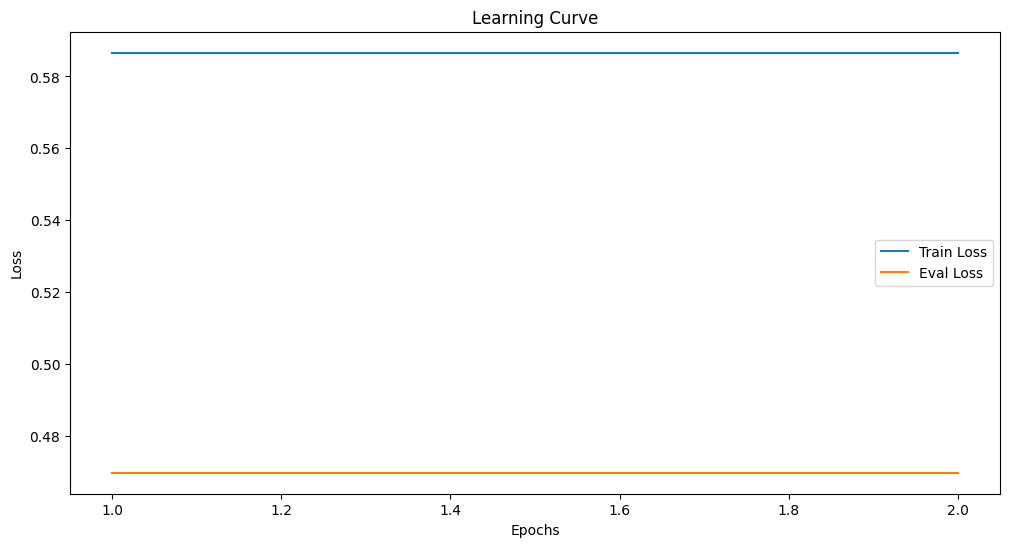

In [ ]:
epochs = list(range(1, training_args.num_train_epochs + 1))
train_loss = [train_metrics['train_loss'] for epoch in epochs]
eval_loss = [eval_metrics['eval_loss'] for epoch in epochs]

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, eval_loss, label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

##### Calcul F1 score

In [13]:
train_result = trainer.train()

  1%|          | 1/189 [00:07<22:14,  7.10s/it]

{'loss': 0.7017, 'grad_norm': 0.9226651191711426, 'learning_rate': 1.9894179894179895e-05, 'epoch': 0.02}


  1%|          | 2/189 [00:13<21:29,  6.90s/it]

{'loss': 0.6906, 'grad_norm': 1.001929759979248, 'learning_rate': 1.978835978835979e-05, 'epoch': 0.03}


  2%|▏         | 3/189 [00:20<20:40,  6.67s/it]

{'loss': 0.7076, 'grad_norm': 2.621314287185669, 'learning_rate': 1.9682539682539684e-05, 'epoch': 0.05}


  2%|▏         | 4/189 [00:26<20:22,  6.61s/it]

{'loss': 0.6906, 'grad_norm': 1.3137810230255127, 'learning_rate': 1.9576719576719577e-05, 'epoch': 0.06}


  3%|▎         | 5/189 [00:33<20:17,  6.62s/it]

{'loss': 0.6692, 'grad_norm': 3.680753469467163, 'learning_rate': 1.947089947089947e-05, 'epoch': 0.08}


  3%|▎         | 6/189 [00:40<20:26,  6.70s/it]

{'loss': 0.6642, 'grad_norm': 0.964866042137146, 'learning_rate': 1.9365079365079367e-05, 'epoch': 0.1}


  4%|▎         | 7/189 [00:47<20:38,  6.81s/it]

{'loss': 0.6548, 'grad_norm': 1.158950924873352, 'learning_rate': 1.925925925925926e-05, 'epoch': 0.11}


  4%|▍         | 8/189 [00:54<20:55,  6.94s/it]

{'loss': 0.6765, 'grad_norm': 2.3589911460876465, 'learning_rate': 1.9153439153439156e-05, 'epoch': 0.13}


  5%|▍         | 9/189 [01:01<21:00,  7.00s/it]

{'loss': 0.6409, 'grad_norm': 1.0502275228500366, 'learning_rate': 1.904761904761905e-05, 'epoch': 0.14}


  5%|▌         | 10/189 [01:08<20:58,  7.03s/it]

{'loss': 0.6492, 'grad_norm': 1.2368853092193604, 'learning_rate': 1.8941798941798943e-05, 'epoch': 0.16}


  6%|▌         | 11/189 [01:15<20:52,  7.04s/it]

{'loss': 0.6547, 'grad_norm': 2.506294012069702, 'learning_rate': 1.8835978835978836e-05, 'epoch': 0.17}


  6%|▋         | 12/189 [01:22<20:43,  7.03s/it]

{'loss': 0.6155, 'grad_norm': 1.6333808898925781, 'learning_rate': 1.8730158730158732e-05, 'epoch': 0.19}


  7%|▋         | 13/189 [01:30<20:48,  7.10s/it]

{'loss': 0.628, 'grad_norm': 1.3584321737289429, 'learning_rate': 1.8624338624338625e-05, 'epoch': 0.21}


  7%|▋         | 14/189 [01:37<20:44,  7.11s/it]

{'loss': 0.6097, 'grad_norm': 1.7629138231277466, 'learning_rate': 1.851851851851852e-05, 'epoch': 0.22}


  8%|▊         | 15/189 [01:44<20:30,  7.07s/it]

{'loss': 0.5781, 'grad_norm': 1.7186495065689087, 'learning_rate': 1.8412698412698415e-05, 'epoch': 0.24}


  8%|▊         | 16/189 [01:51<20:26,  7.09s/it]

{'loss': 0.5802, 'grad_norm': 1.943556785583496, 'learning_rate': 1.8306878306878308e-05, 'epoch': 0.25}


  9%|▉         | 17/189 [01:58<20:18,  7.09s/it]

{'loss': 0.5476, 'grad_norm': 3.0563957691192627, 'learning_rate': 1.82010582010582e-05, 'epoch': 0.27}


 10%|▉         | 18/189 [02:05<20:07,  7.06s/it]

{'loss': 0.5148, 'grad_norm': 8.135763168334961, 'learning_rate': 1.8095238095238097e-05, 'epoch': 0.29}


 10%|█         | 19/189 [02:12<20:06,  7.10s/it]

{'loss': 0.5067, 'grad_norm': 7.003661632537842, 'learning_rate': 1.798941798941799e-05, 'epoch': 0.3}


 11%|█         | 20/189 [02:19<20:01,  7.11s/it]

{'loss': 0.4967, 'grad_norm': 8.917852401733398, 'learning_rate': 1.7883597883597884e-05, 'epoch': 0.32}


 11%|█         | 21/189 [02:26<19:54,  7.11s/it]

{'loss': 0.4431, 'grad_norm': 15.882304191589355, 'learning_rate': 1.7777777777777777e-05, 'epoch': 0.33}


 12%|█▏        | 22/189 [02:33<19:41,  7.08s/it]

{'loss': 0.4424, 'grad_norm': 38.890811920166016, 'learning_rate': 1.7671957671957673e-05, 'epoch': 0.35}


 12%|█▏        | 23/189 [02:40<19:35,  7.08s/it]

{'loss': 0.4503, 'grad_norm': 8.613924980163574, 'learning_rate': 1.7566137566137566e-05, 'epoch': 0.37}


 13%|█▎        | 24/189 [02:48<19:29,  7.09s/it]

{'loss': 0.462, 'grad_norm': 46.8584098815918, 'learning_rate': 1.7460317460317463e-05, 'epoch': 0.38}


 13%|█▎        | 25/189 [02:55<19:21,  7.08s/it]

{'loss': 0.3974, 'grad_norm': 13.112112045288086, 'learning_rate': 1.7354497354497356e-05, 'epoch': 0.4}


 14%|█▍        | 26/189 [03:02<19:16,  7.10s/it]

{'loss': 0.3944, 'grad_norm': 26.58534812927246, 'learning_rate': 1.724867724867725e-05, 'epoch': 0.41}


 14%|█▍        | 27/189 [03:09<19:08,  7.09s/it]

{'loss': 0.3862, 'grad_norm': 25.846542358398438, 'learning_rate': 1.7142857142857142e-05, 'epoch': 0.43}


 15%|█▍        | 28/189 [03:16<19:04,  7.11s/it]

{'loss': 0.357, 'grad_norm': 11.195737838745117, 'learning_rate': 1.7037037037037038e-05, 'epoch': 0.44}


 15%|█▌        | 29/189 [03:23<18:59,  7.12s/it]

{'loss': 0.3404, 'grad_norm': 17.30303955078125, 'learning_rate': 1.693121693121693e-05, 'epoch': 0.46}


 16%|█▌        | 30/189 [03:30<18:53,  7.13s/it]

{'loss': 0.3593, 'grad_norm': 2.9725992679595947, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.48}


 16%|█▋        | 31/189 [03:37<18:44,  7.12s/it]

{'loss': 0.3209, 'grad_norm': 4.1933274269104, 'learning_rate': 1.671957671957672e-05, 'epoch': 0.49}


 17%|█▋        | 32/189 [03:44<18:38,  7.12s/it]

{'loss': 0.3528, 'grad_norm': 4.571989059448242, 'learning_rate': 1.6613756613756614e-05, 'epoch': 0.51}


 17%|█▋        | 33/189 [03:51<18:17,  7.04s/it]

{'loss': 0.29, 'grad_norm': 2.38918137550354, 'learning_rate': 1.6507936507936507e-05, 'epoch': 0.52}


 18%|█▊        | 34/189 [03:58<18:10,  7.03s/it]

{'loss': 0.2208, 'grad_norm': 3.0022003650665283, 'learning_rate': 1.6402116402116404e-05, 'epoch': 0.54}


 19%|█▊        | 35/189 [04:05<18:06,  7.06s/it]

{'loss': 0.2772, 'grad_norm': 3.9909980297088623, 'learning_rate': 1.6296296296296297e-05, 'epoch': 0.56}


 19%|█▉        | 36/189 [04:13<18:03,  7.08s/it]

{'loss': 0.2538, 'grad_norm': 2.093688488006592, 'learning_rate': 1.6190476190476193e-05, 'epoch': 0.57}


 20%|█▉        | 37/189 [04:20<18:00,  7.11s/it]

{'loss': 0.185, 'grad_norm': 3.4348325729370117, 'learning_rate': 1.6084656084656086e-05, 'epoch': 0.59}


 20%|██        | 38/189 [04:27<17:53,  7.11s/it]

{'loss': 0.1908, 'grad_norm': 1.6976286172866821, 'learning_rate': 1.597883597883598e-05, 'epoch': 0.6}


 21%|██        | 39/189 [04:34<17:46,  7.11s/it]

{'loss': 0.1642, 'grad_norm': 1.711734652519226, 'learning_rate': 1.5873015873015872e-05, 'epoch': 0.62}


 21%|██        | 40/189 [04:41<17:40,  7.12s/it]

{'loss': 0.1641, 'grad_norm': 2.3526952266693115, 'learning_rate': 1.576719576719577e-05, 'epoch': 0.63}


 22%|██▏       | 41/189 [04:48<17:37,  7.14s/it]

{'loss': 0.1279, 'grad_norm': 2.4533445835113525, 'learning_rate': 1.5661375661375662e-05, 'epoch': 0.65}


 22%|██▏       | 42/189 [04:55<17:24,  7.11s/it]

{'loss': 0.1089, 'grad_norm': 1.4988775253295898, 'learning_rate': 1.555555555555556e-05, 'epoch': 0.67}


 23%|██▎       | 43/189 [05:02<17:19,  7.12s/it]

{'loss': 0.0958, 'grad_norm': 1.6183240413665771, 'learning_rate': 1.544973544973545e-05, 'epoch': 0.68}


 23%|██▎       | 44/189 [05:10<17:16,  7.15s/it]

{'loss': 0.1242, 'grad_norm': 4.050631523132324, 'learning_rate': 1.5343915343915344e-05, 'epoch': 0.7}


 24%|██▍       | 45/189 [05:17<17:06,  7.13s/it]

{'loss': 0.1002, 'grad_norm': 2.191765546798706, 'learning_rate': 1.523809523809524e-05, 'epoch': 0.71}


 24%|██▍       | 46/189 [05:24<16:51,  7.07s/it]

{'loss': 0.0619, 'grad_norm': 1.6467416286468506, 'learning_rate': 1.5132275132275134e-05, 'epoch': 0.73}


 25%|██▍       | 47/189 [05:31<16:42,  7.06s/it]

{'loss': 0.0605, 'grad_norm': 1.3344658613204956, 'learning_rate': 1.5026455026455027e-05, 'epoch': 0.75}


 25%|██▌       | 48/189 [05:38<16:36,  7.07s/it]

{'loss': 0.0511, 'grad_norm': 0.8104835152626038, 'learning_rate': 1.4920634920634922e-05, 'epoch': 0.76}


 26%|██▌       | 49/189 [05:45<16:33,  7.10s/it]

{'loss': 0.0493, 'grad_norm': 2.1958465576171875, 'learning_rate': 1.4814814814814815e-05, 'epoch': 0.78}


 26%|██▋       | 50/189 [05:52<16:27,  7.10s/it]

{'loss': 0.048, 'grad_norm': 0.9109885096549988, 'learning_rate': 1.470899470899471e-05, 'epoch': 0.79}


 27%|██▋       | 51/189 [05:59<16:20,  7.11s/it]

{'loss': 0.0327, 'grad_norm': 0.5451668500900269, 'learning_rate': 1.4603174603174603e-05, 'epoch': 0.81}


 28%|██▊       | 52/189 [06:06<16:17,  7.14s/it]

{'loss': 0.0339, 'grad_norm': 0.5606933236122131, 'learning_rate': 1.44973544973545e-05, 'epoch': 0.83}


 28%|██▊       | 53/189 [06:14<16:11,  7.14s/it]

{'loss': 0.0262, 'grad_norm': 0.42405498027801514, 'learning_rate': 1.4391534391534392e-05, 'epoch': 0.84}


 29%|██▊       | 54/189 [06:21<16:04,  7.14s/it]

{'loss': 0.0242, 'grad_norm': 0.4371834993362427, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.86}


 29%|██▉       | 55/189 [06:28<15:56,  7.14s/it]

{'loss': 0.0208, 'grad_norm': 0.3421308696269989, 'learning_rate': 1.417989417989418e-05, 'epoch': 0.87}


 30%|██▉       | 56/189 [06:35<15:48,  7.13s/it]

{'loss': 0.0202, 'grad_norm': 0.38614535331726074, 'learning_rate': 1.4074074074074075e-05, 'epoch': 0.89}


 30%|███       | 57/189 [06:42<15:41,  7.13s/it]

{'loss': 0.0187, 'grad_norm': 0.3919673562049866, 'learning_rate': 1.3968253968253968e-05, 'epoch': 0.9}


 31%|███       | 58/189 [06:49<15:37,  7.16s/it]

{'loss': 0.0142, 'grad_norm': 0.24925324320793152, 'learning_rate': 1.3862433862433865e-05, 'epoch': 0.92}


 31%|███       | 59/189 [06:57<15:31,  7.17s/it]

{'loss': 0.014, 'grad_norm': 0.2317531853914261, 'learning_rate': 1.3756613756613758e-05, 'epoch': 0.94}


 32%|███▏      | 60/189 [07:04<15:21,  7.14s/it]

{'loss': 0.0132, 'grad_norm': 0.23308123648166656, 'learning_rate': 1.3650793650793652e-05, 'epoch': 0.95}


 32%|███▏      | 61/189 [07:11<15:13,  7.14s/it]

{'loss': 0.0122, 'grad_norm': 0.20917800068855286, 'learning_rate': 1.3544973544973545e-05, 'epoch': 0.97}


 33%|███▎      | 62/189 [07:18<15:04,  7.13s/it]

{'loss': 0.0117, 'grad_norm': 0.2205403447151184, 'learning_rate': 1.343915343915344e-05, 'epoch': 0.98}


 33%|███▎      | 63/189 [07:19<10:56,  5.21s/it]

{'loss': 0.0097, 'grad_norm': 0.17571112513542175, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


                                                
 33%|███▎      | 63/189 [07:52<10:56,  5.21s/it]

{'eval_loss': 0.4525032043457031, 'eval_f1': 0.8690822573753008, 'eval_runtime': 33.2108, 'eval_samples_per_second': 29.9, 'eval_steps_per_second': 0.482, 'epoch': 1.0}


 34%|███▍      | 64/189 [08:00<33:16, 15.97s/it]

{'loss': 0.0093, 'grad_norm': 0.15976539254188538, 'learning_rate': 1.322751322751323e-05, 'epoch': 1.02}


 34%|███▍      | 65/189 [08:07<27:32, 13.33s/it]

{'loss': 0.0092, 'grad_norm': 0.17196963727474213, 'learning_rate': 1.3121693121693123e-05, 'epoch': 1.03}


 35%|███▍      | 66/189 [08:13<23:09, 11.30s/it]

{'loss': 0.0083, 'grad_norm': 0.14673444628715515, 'learning_rate': 1.3015873015873018e-05, 'epoch': 1.05}


 35%|███▌      | 67/189 [08:20<19:58,  9.83s/it]

{'loss': 0.0081, 'grad_norm': 0.1415950059890747, 'learning_rate': 1.291005291005291e-05, 'epoch': 1.06}


 36%|███▌      | 68/189 [08:27<18:09,  9.00s/it]

{'loss': 0.0083, 'grad_norm': 0.15138652920722961, 'learning_rate': 1.2804232804232805e-05, 'epoch': 1.08}


 37%|███▋      | 69/189 [08:34<16:50,  8.42s/it]

{'loss': 0.0071, 'grad_norm': 0.12841224670410156, 'learning_rate': 1.2698412698412699e-05, 'epoch': 1.1}


 37%|███▋      | 70/189 [08:41<15:57,  8.05s/it]

{'loss': 0.0068, 'grad_norm': 0.14353425800800323, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}


 38%|███▊      | 71/189 [08:48<15:16,  7.76s/it]

{'loss': 0.0067, 'grad_norm': 0.11899644136428833, 'learning_rate': 1.2486772486772486e-05, 'epoch': 1.13}


 38%|███▊      | 72/189 [08:55<14:51,  7.62s/it]

{'loss': 0.0071, 'grad_norm': 0.12574779987335205, 'learning_rate': 1.2380952380952383e-05, 'epoch': 1.14}


 39%|███▊      | 73/189 [09:03<14:25,  7.46s/it]

{'loss': 0.0063, 'grad_norm': 0.11188456416130066, 'learning_rate': 1.2275132275132276e-05, 'epoch': 1.16}


 39%|███▉      | 74/189 [09:09<13:58,  7.29s/it]

{'loss': 0.0057, 'grad_norm': 0.10242942720651627, 'learning_rate': 1.216931216931217e-05, 'epoch': 1.17}


 40%|███▉      | 75/189 [09:16<13:39,  7.19s/it]

{'loss': 0.0056, 'grad_norm': 0.09788911044597626, 'learning_rate': 1.2063492063492064e-05, 'epoch': 1.19}


 40%|████      | 76/189 [09:24<13:30,  7.17s/it]

{'loss': 0.0059, 'grad_norm': 0.10204081237316132, 'learning_rate': 1.1957671957671959e-05, 'epoch': 1.21}


 41%|████      | 77/189 [09:30<13:14,  7.10s/it]

{'loss': 0.0053, 'grad_norm': 0.09627168625593185, 'learning_rate': 1.1851851851851852e-05, 'epoch': 1.22}


 41%|████▏     | 78/189 [09:37<13:01,  7.04s/it]

{'loss': 0.0053, 'grad_norm': 0.09893043339252472, 'learning_rate': 1.1746031746031748e-05, 'epoch': 1.24}


 42%|████▏     | 79/189 [09:44<12:52,  7.02s/it]

{'loss': 0.0049, 'grad_norm': 0.09010270982980728, 'learning_rate': 1.1640211640211641e-05, 'epoch': 1.25}


 42%|████▏     | 80/189 [09:51<12:39,  6.97s/it]

{'loss': 0.0049, 'grad_norm': 0.09072716534137726, 'learning_rate': 1.1534391534391536e-05, 'epoch': 1.27}


 43%|████▎     | 81/189 [09:58<12:36,  7.00s/it]

{'loss': 0.0046, 'grad_norm': 0.08172919601202011, 'learning_rate': 1.1428571428571429e-05, 'epoch': 1.29}


 43%|████▎     | 82/189 [10:05<12:30,  7.02s/it]

{'loss': 0.0047, 'grad_norm': 0.08481762558221817, 'learning_rate': 1.1322751322751324e-05, 'epoch': 1.3}


 44%|████▍     | 83/189 [10:13<12:29,  7.07s/it]

{'loss': 0.0045, 'grad_norm': 0.08032446354627609, 'learning_rate': 1.1216931216931217e-05, 'epoch': 1.32}


 44%|████▍     | 84/189 [10:20<12:31,  7.16s/it]

{'loss': 0.0045, 'grad_norm': 0.08063831925392151, 'learning_rate': 1.1111111111111113e-05, 'epoch': 1.33}


 45%|████▍     | 85/189 [10:27<12:21,  7.13s/it]

{'loss': 0.0043, 'grad_norm': 0.07661182433366776, 'learning_rate': 1.1005291005291006e-05, 'epoch': 1.35}


 46%|████▌     | 86/189 [10:34<12:02,  7.02s/it]

{'loss': 0.0041, 'grad_norm': 0.07372942566871643, 'learning_rate': 1.0899470899470901e-05, 'epoch': 1.37}


 46%|████▌     | 87/189 [10:40<11:43,  6.90s/it]

{'loss': 0.0042, 'grad_norm': 0.25817883014678955, 'learning_rate': 1.0793650793650794e-05, 'epoch': 1.38}


 47%|████▋     | 88/189 [10:47<11:31,  6.84s/it]

{'loss': 0.0036, 'grad_norm': 0.06575968861579895, 'learning_rate': 1.0687830687830689e-05, 'epoch': 1.4}


 47%|████▋     | 89/189 [10:55<11:51,  7.12s/it]

{'loss': 0.0041, 'grad_norm': 0.07486159354448318, 'learning_rate': 1.0582010582010582e-05, 'epoch': 1.41}


 48%|████▊     | 90/189 [11:02<11:33,  7.01s/it]

{'loss': 0.0038, 'grad_norm': 0.06783691048622131, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}


 48%|████▊     | 91/189 [11:08<11:22,  6.97s/it]

{'loss': 0.0036, 'grad_norm': 0.07913746684789658, 'learning_rate': 1.037037037037037e-05, 'epoch': 1.44}


 49%|████▊     | 92/189 [11:15<11:11,  6.92s/it]

{'loss': 0.0037, 'grad_norm': 0.06887410581111908, 'learning_rate': 1.0264550264550266e-05, 'epoch': 1.46}


 49%|████▉     | 93/189 [11:22<10:50,  6.78s/it]

{'loss': 0.0036, 'grad_norm': 0.06576570868492126, 'learning_rate': 1.015873015873016e-05, 'epoch': 1.48}


 50%|████▉     | 94/189 [11:28<10:36,  6.70s/it]

{'loss': 0.0035, 'grad_norm': 0.06465611606836319, 'learning_rate': 1.0052910052910054e-05, 'epoch': 1.49}


 50%|█████     | 95/189 [11:35<10:24,  6.64s/it]

{'loss': 0.0033, 'grad_norm': 0.06146509572863579, 'learning_rate': 9.947089947089947e-06, 'epoch': 1.51}


 51%|█████     | 96/189 [11:41<10:11,  6.58s/it]

{'loss': 0.0033, 'grad_norm': 0.060444850474596024, 'learning_rate': 9.841269841269842e-06, 'epoch': 1.52}


 51%|█████▏    | 97/189 [11:48<10:03,  6.56s/it]

{'loss': 0.0036, 'grad_norm': 0.06640997529029846, 'learning_rate': 9.735449735449735e-06, 'epoch': 1.54}


 52%|█████▏    | 98/189 [11:55<10:08,  6.69s/it]

{'loss': 0.0033, 'grad_norm': 0.0611908845603466, 'learning_rate': 9.62962962962963e-06, 'epoch': 1.56}


 52%|█████▏    | 99/189 [12:02<10:13,  6.82s/it]

{'loss': 0.0031, 'grad_norm': 0.05702465772628784, 'learning_rate': 9.523809523809525e-06, 'epoch': 1.57}


 53%|█████▎    | 100/189 [12:09<10:16,  6.93s/it]

{'loss': 0.0031, 'grad_norm': 0.05846536532044411, 'learning_rate': 9.417989417989418e-06, 'epoch': 1.59}


 53%|█████▎    | 101/189 [12:16<10:18,  7.03s/it]

{'loss': 0.0031, 'grad_norm': 0.056355420500040054, 'learning_rate': 9.312169312169313e-06, 'epoch': 1.6}


 54%|█████▍    | 102/189 [12:23<10:15,  7.08s/it]

{'loss': 0.0032, 'grad_norm': 0.057160258293151855, 'learning_rate': 9.206349206349207e-06, 'epoch': 1.62}


 54%|█████▍    | 103/189 [12:31<10:13,  7.13s/it]

{'loss': 0.0032, 'grad_norm': 0.05891040340065956, 'learning_rate': 9.1005291005291e-06, 'epoch': 1.63}


 55%|█████▌    | 104/189 [12:38<10:09,  7.18s/it]

{'loss': 0.0029, 'grad_norm': 0.053528059273958206, 'learning_rate': 8.994708994708995e-06, 'epoch': 1.65}


 56%|█████▌    | 105/189 [12:45<10:06,  7.22s/it]

{'loss': 0.0031, 'grad_norm': 0.055716779083013535, 'learning_rate': 8.888888888888888e-06, 'epoch': 1.67}


 56%|█████▌    | 106/189 [12:52<09:56,  7.18s/it]

{'loss': 0.0028, 'grad_norm': 0.05149553716182709, 'learning_rate': 8.783068783068783e-06, 'epoch': 1.68}


 57%|█████▋    | 107/189 [12:59<09:46,  7.15s/it]

{'loss': 0.0032, 'grad_norm': 0.0609474815428257, 'learning_rate': 8.677248677248678e-06, 'epoch': 1.7}


 57%|█████▋    | 108/189 [13:07<09:39,  7.15s/it]

{'loss': 0.0029, 'grad_norm': 0.05363848805427551, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.71}


 58%|█████▊    | 109/189 [13:14<09:30,  7.13s/it]

{'loss': 0.0029, 'grad_norm': 0.0544249527156353, 'learning_rate': 8.465608465608466e-06, 'epoch': 1.73}


 58%|█████▊    | 110/189 [13:21<09:25,  7.15s/it]

{'loss': 0.0027, 'grad_norm': 0.050116509199142456, 'learning_rate': 8.35978835978836e-06, 'epoch': 1.75}


 59%|█████▊    | 111/189 [13:28<09:17,  7.15s/it]

{'loss': 0.0028, 'grad_norm': 0.05182664841413498, 'learning_rate': 8.253968253968254e-06, 'epoch': 1.76}


 59%|█████▉    | 112/189 [13:35<09:09,  7.14s/it]

{'loss': 0.0029, 'grad_norm': 0.0523323155939579, 'learning_rate': 8.148148148148148e-06, 'epoch': 1.78}


 60%|█████▉    | 113/189 [13:42<09:02,  7.14s/it]

{'loss': 0.0027, 'grad_norm': 0.05093304067850113, 'learning_rate': 8.042328042328043e-06, 'epoch': 1.79}


 60%|██████    | 114/189 [13:50<08:58,  7.19s/it]

{'loss': 0.0026, 'grad_norm': 0.04965122044086456, 'learning_rate': 7.936507936507936e-06, 'epoch': 1.81}


 61%|██████    | 115/189 [13:57<08:51,  7.18s/it]

{'loss': 0.0027, 'grad_norm': 0.049853622913360596, 'learning_rate': 7.830687830687831e-06, 'epoch': 1.83}


 61%|██████▏   | 116/189 [14:04<08:50,  7.27s/it]

{'loss': 0.0028, 'grad_norm': 0.05112989619374275, 'learning_rate': 7.724867724867726e-06, 'epoch': 1.84}


 62%|██████▏   | 117/189 [14:12<08:44,  7.29s/it]

{'loss': 0.0026, 'grad_norm': 0.04890955239534378, 'learning_rate': 7.61904761904762e-06, 'epoch': 1.86}


 62%|██████▏   | 118/189 [14:19<08:32,  7.21s/it]

{'loss': 0.0026, 'grad_norm': 0.05101536586880684, 'learning_rate': 7.5132275132275136e-06, 'epoch': 1.87}


 63%|██████▎   | 119/189 [14:26<08:21,  7.16s/it]

{'loss': 0.0027, 'grad_norm': 0.05034641921520233, 'learning_rate': 7.4074074074074075e-06, 'epoch': 1.89}


 63%|██████▎   | 120/189 [14:33<08:15,  7.18s/it]

{'loss': 0.0027, 'grad_norm': 0.05034516751766205, 'learning_rate': 7.301587301587301e-06, 'epoch': 1.9}


 64%|██████▍   | 121/189 [14:40<08:05,  7.14s/it]

{'loss': 0.0025, 'grad_norm': 0.04737546294927597, 'learning_rate': 7.195767195767196e-06, 'epoch': 1.92}


 65%|██████▍   | 122/189 [14:47<07:57,  7.12s/it]

{'loss': 0.0026, 'grad_norm': 0.048106446862220764, 'learning_rate': 7.08994708994709e-06, 'epoch': 1.94}


 65%|██████▌   | 123/189 [14:54<07:50,  7.13s/it]

{'loss': 0.0026, 'grad_norm': 0.05538755655288696, 'learning_rate': 6.984126984126984e-06, 'epoch': 1.95}


 66%|██████▌   | 124/189 [15:01<07:45,  7.16s/it]

{'loss': 0.0026, 'grad_norm': 0.047475818544626236, 'learning_rate': 6.878306878306879e-06, 'epoch': 1.97}


 66%|██████▌   | 125/189 [15:08<07:37,  7.14s/it]

{'loss': 0.0026, 'grad_norm': 0.054157134145498276, 'learning_rate': 6.772486772486773e-06, 'epoch': 1.98}


 67%|██████▋   | 126/189 [15:09<05:28,  5.21s/it]

{'loss': 0.0027, 'grad_norm': 0.0633564293384552, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


                                                 
 67%|██████▋   | 126/189 [15:42<05:28,  5.21s/it]

{'eval_loss': 0.6313570737838745, 'eval_f1': 0.8590073722306704, 'eval_runtime': 33.19, 'eval_samples_per_second': 29.919, 'eval_steps_per_second': 0.482, 'epoch': 2.0}


 67%|██████▋   | 127/189 [15:50<16:26, 15.92s/it]

{'loss': 0.0025, 'grad_norm': 0.04811082035303116, 'learning_rate': 6.560846560846561e-06, 'epoch': 2.02}


 68%|██████▊   | 128/189 [15:57<13:30, 13.28s/it]

{'loss': 0.0025, 'grad_norm': 0.046686168760061264, 'learning_rate': 6.455026455026455e-06, 'epoch': 2.03}


 68%|██████▊   | 129/189 [16:04<11:24, 11.41s/it]

{'loss': 0.0025, 'grad_norm': 0.045697592198848724, 'learning_rate': 6.349206349206349e-06, 'epoch': 2.05}


 69%|██████▉   | 130/189 [16:11<09:56, 10.10s/it]

{'loss': 0.0025, 'grad_norm': 0.04702441021800041, 'learning_rate': 6.243386243386243e-06, 'epoch': 2.06}


 69%|██████▉   | 131/189 [16:18<08:52,  9.19s/it]

{'loss': 0.0607, 'grad_norm': 2.1994290351867676, 'learning_rate': 6.137566137566138e-06, 'epoch': 2.08}


 70%|██████▉   | 132/189 [16:26<08:10,  8.60s/it]

{'loss': 0.0025, 'grad_norm': 0.046307776123285294, 'learning_rate': 6.031746031746032e-06, 'epoch': 2.1}


 70%|███████   | 133/189 [16:33<07:36,  8.14s/it]

{'loss': 0.0025, 'grad_norm': 0.04617096111178398, 'learning_rate': 5.925925925925926e-06, 'epoch': 2.11}


 71%|███████   | 134/189 [16:40<07:09,  7.81s/it]

{'loss': 0.0024, 'grad_norm': 0.04576118662953377, 'learning_rate': 5.820105820105821e-06, 'epoch': 2.13}


 71%|███████▏  | 135/189 [16:47<06:49,  7.59s/it]

{'loss': 0.0025, 'grad_norm': 0.045792508870363235, 'learning_rate': 5.7142857142857145e-06, 'epoch': 2.14}


 72%|███████▏  | 136/189 [16:54<06:36,  7.47s/it]

{'loss': 0.0025, 'grad_norm': 0.05112609267234802, 'learning_rate': 5.6084656084656084e-06, 'epoch': 2.16}


 72%|███████▏  | 137/189 [17:01<06:24,  7.40s/it]

{'loss': 0.0023, 'grad_norm': 0.04323964565992355, 'learning_rate': 5.502645502645503e-06, 'epoch': 2.17}


 73%|███████▎  | 138/189 [17:08<06:14,  7.34s/it]

{'loss': 0.0021, 'grad_norm': 0.040121421217918396, 'learning_rate': 5.396825396825397e-06, 'epoch': 2.19}


 74%|███████▎  | 139/189 [17:16<06:04,  7.28s/it]

{'loss': 0.0024, 'grad_norm': 0.04442427307367325, 'learning_rate': 5.291005291005291e-06, 'epoch': 2.21}


 74%|███████▍  | 140/189 [17:23<05:59,  7.33s/it]

{'loss': 0.0025, 'grad_norm': 0.05719786882400513, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}


 75%|███████▍  | 141/189 [17:30<05:51,  7.32s/it]

{'loss': 0.0023, 'grad_norm': 0.043737392872571945, 'learning_rate': 5.07936507936508e-06, 'epoch': 2.24}


 75%|███████▌  | 142/189 [17:38<05:42,  7.30s/it]

{'loss': 0.0023, 'grad_norm': 0.04347207397222519, 'learning_rate': 4.973544973544974e-06, 'epoch': 2.25}


 76%|███████▌  | 143/189 [17:45<05:35,  7.30s/it]

{'loss': 0.0025, 'grad_norm': 0.04597453773021698, 'learning_rate': 4.867724867724868e-06, 'epoch': 2.27}


 76%|███████▌  | 144/189 [17:52<05:26,  7.26s/it]

{'loss': 0.0024, 'grad_norm': 0.04615221172571182, 'learning_rate': 4.761904761904762e-06, 'epoch': 2.29}


 77%|███████▋  | 145/189 [17:59<05:19,  7.26s/it]

{'loss': 0.0024, 'grad_norm': 0.052147604525089264, 'learning_rate': 4.656084656084656e-06, 'epoch': 2.3}


 77%|███████▋  | 146/189 [18:06<05:10,  7.22s/it]

{'loss': 0.0022, 'grad_norm': 0.04210105910897255, 'learning_rate': 4.55026455026455e-06, 'epoch': 2.32}


 78%|███████▊  | 147/189 [18:14<05:04,  7.24s/it]

{'loss': 0.0023, 'grad_norm': 0.043571509420871735, 'learning_rate': 4.444444444444444e-06, 'epoch': 2.33}


 78%|███████▊  | 148/189 [18:21<04:57,  7.24s/it]

{'loss': 0.0023, 'grad_norm': 0.04255251958966255, 'learning_rate': 4.338624338624339e-06, 'epoch': 2.35}


 79%|███████▉  | 149/189 [18:28<04:50,  7.26s/it]

{'loss': 0.0022, 'grad_norm': 0.04144877940416336, 'learning_rate': 4.232804232804233e-06, 'epoch': 2.37}


 79%|███████▉  | 150/189 [18:35<04:43,  7.27s/it]

{'loss': 0.0022, 'grad_norm': 0.04181571304798126, 'learning_rate': 4.126984126984127e-06, 'epoch': 2.38}


 80%|███████▉  | 151/189 [18:43<04:35,  7.26s/it]

{'loss': 0.0023, 'grad_norm': 0.04202767089009285, 'learning_rate': 4.0211640211640215e-06, 'epoch': 2.4}


 80%|████████  | 152/189 [18:50<04:27,  7.22s/it]

{'loss': 0.0024, 'grad_norm': 0.04507153853774071, 'learning_rate': 3.9153439153439155e-06, 'epoch': 2.41}


 81%|████████  | 153/189 [18:57<04:19,  7.22s/it]

{'loss': 0.0021, 'grad_norm': 0.03948017209768295, 'learning_rate': 3.80952380952381e-06, 'epoch': 2.43}


 81%|████████▏ | 154/189 [19:04<04:11,  7.20s/it]

{'loss': 0.0023, 'grad_norm': 0.043002285063266754, 'learning_rate': 3.7037037037037037e-06, 'epoch': 2.44}


 82%|████████▏ | 155/189 [19:11<04:04,  7.19s/it]

{'loss': 0.0022, 'grad_norm': 0.04096143692731857, 'learning_rate': 3.597883597883598e-06, 'epoch': 2.46}


 83%|████████▎ | 156/189 [19:19<03:58,  7.22s/it]

{'loss': 0.0023, 'grad_norm': 0.044036008417606354, 'learning_rate': 3.492063492063492e-06, 'epoch': 2.48}


 83%|████████▎ | 157/189 [19:26<03:50,  7.21s/it]

{'loss': 0.0023, 'grad_norm': 0.04618603736162186, 'learning_rate': 3.3862433862433864e-06, 'epoch': 2.49}


 84%|████████▎ | 158/189 [19:33<03:44,  7.25s/it]

{'loss': 0.0023, 'grad_norm': 0.04676816985011101, 'learning_rate': 3.2804232804232807e-06, 'epoch': 2.51}


 84%|████████▍ | 159/189 [19:40<03:33,  7.13s/it]

{'loss': 0.0021, 'grad_norm': 0.03904394060373306, 'learning_rate': 3.1746031746031746e-06, 'epoch': 2.52}


 85%|████████▍ | 160/189 [19:47<03:24,  7.04s/it]

{'loss': 0.0023, 'grad_norm': 0.04181594401597977, 'learning_rate': 3.068783068783069e-06, 'epoch': 2.54}


 85%|████████▌ | 161/189 [19:54<03:17,  7.04s/it]

{'loss': 0.0022, 'grad_norm': 0.04150881618261337, 'learning_rate': 2.962962962962963e-06, 'epoch': 2.56}


 86%|████████▌ | 162/189 [20:01<03:06,  6.92s/it]

{'loss': 0.0022, 'grad_norm': 0.041418228298425674, 'learning_rate': 2.8571428571428573e-06, 'epoch': 2.57}


 86%|████████▌ | 163/189 [20:07<02:58,  6.86s/it]

{'loss': 0.0021, 'grad_norm': 0.04016806185245514, 'learning_rate': 2.7513227513227516e-06, 'epoch': 2.59}


 87%|████████▋ | 164/189 [20:14<02:49,  6.78s/it]

{'loss': 0.0022, 'grad_norm': 0.045950427651405334, 'learning_rate': 2.6455026455026455e-06, 'epoch': 2.6}


 87%|████████▋ | 165/189 [20:21<02:43,  6.83s/it]

{'loss': 0.0022, 'grad_norm': 0.040712278336286545, 'learning_rate': 2.53968253968254e-06, 'epoch': 2.62}


 88%|████████▊ | 166/189 [20:27<02:34,  6.73s/it]

{'loss': 0.0021, 'grad_norm': 0.03920281305909157, 'learning_rate': 2.433862433862434e-06, 'epoch': 2.63}


 88%|████████▊ | 167/189 [20:34<02:27,  6.69s/it]

{'loss': 0.0021, 'grad_norm': 0.03990178182721138, 'learning_rate': 2.328042328042328e-06, 'epoch': 2.65}


 89%|████████▉ | 168/189 [20:40<02:19,  6.63s/it]

{'loss': 0.0022, 'grad_norm': 0.04045935720205307, 'learning_rate': 2.222222222222222e-06, 'epoch': 2.67}


 89%|████████▉ | 169/189 [20:47<02:11,  6.60s/it]

{'loss': 0.0022, 'grad_norm': 0.04135094955563545, 'learning_rate': 2.1164021164021164e-06, 'epoch': 2.68}


 90%|████████▉ | 170/189 [20:53<02:05,  6.58s/it]

{'loss': 0.0021, 'grad_norm': 0.04004630073904991, 'learning_rate': 2.0105820105820108e-06, 'epoch': 2.7}


 90%|█████████ | 171/189 [21:00<01:57,  6.55s/it]

{'loss': 0.0021, 'grad_norm': 0.03825667127966881, 'learning_rate': 1.904761904761905e-06, 'epoch': 2.71}


 91%|█████████ | 172/189 [21:07<01:51,  6.55s/it]

{'loss': 0.0022, 'grad_norm': 0.041458677500486374, 'learning_rate': 1.798941798941799e-06, 'epoch': 2.73}


 92%|█████████▏| 173/189 [21:13<01:45,  6.56s/it]

{'loss': 0.0022, 'grad_norm': 0.04249970614910126, 'learning_rate': 1.6931216931216932e-06, 'epoch': 2.75}


 92%|█████████▏| 174/189 [21:20<01:38,  6.54s/it]

{'loss': 0.0022, 'grad_norm': 0.04075293242931366, 'learning_rate': 1.5873015873015873e-06, 'epoch': 2.76}


 93%|█████████▎| 175/189 [21:26<01:31,  6.51s/it]

{'loss': 0.0021, 'grad_norm': 0.039322786033153534, 'learning_rate': 1.4814814814814815e-06, 'epoch': 2.78}


 93%|█████████▎| 176/189 [21:33<01:24,  6.51s/it]

{'loss': 0.0021, 'grad_norm': 0.03926084563136101, 'learning_rate': 1.3756613756613758e-06, 'epoch': 2.79}


 94%|█████████▎| 177/189 [21:39<01:18,  6.50s/it]

{'loss': 0.0021, 'grad_norm': 0.03966483846306801, 'learning_rate': 1.26984126984127e-06, 'epoch': 2.81}


 94%|█████████▍| 178/189 [21:45<01:11,  6.48s/it]

{'loss': 0.0022, 'grad_norm': 0.04130495712161064, 'learning_rate': 1.164021164021164e-06, 'epoch': 2.83}


 95%|█████████▍| 179/189 [21:52<01:05,  6.54s/it]

{'loss': 0.002, 'grad_norm': 0.03737896308302879, 'learning_rate': 1.0582010582010582e-06, 'epoch': 2.84}


 95%|█████████▌| 180/189 [21:59<00:58,  6.54s/it]

{'loss': 0.0021, 'grad_norm': 0.040284596383571625, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


 96%|█████████▌| 181/189 [22:05<00:52,  6.57s/it]

{'loss': 0.0021, 'grad_norm': 0.03927510231733322, 'learning_rate': 8.465608465608466e-07, 'epoch': 2.87}


 96%|█████████▋| 182/189 [22:12<00:45,  6.54s/it]

{'loss': 0.002, 'grad_norm': 0.03844825178384781, 'learning_rate': 7.407407407407407e-07, 'epoch': 2.89}


 97%|█████████▋| 183/189 [22:18<00:39,  6.51s/it]

{'loss': 0.0021, 'grad_norm': 0.03895089030265808, 'learning_rate': 6.34920634920635e-07, 'epoch': 2.9}


 97%|█████████▋| 184/189 [22:25<00:32,  6.59s/it]

{'loss': 0.0022, 'grad_norm': 0.04103613644838333, 'learning_rate': 5.291005291005291e-07, 'epoch': 2.92}


 98%|█████████▊| 185/189 [22:32<00:26,  6.71s/it]

{'loss': 0.0021, 'grad_norm': 0.039119839668273926, 'learning_rate': 4.232804232804233e-07, 'epoch': 2.94}


 98%|█████████▊| 186/189 [22:39<00:20,  6.75s/it]

{'loss': 0.0022, 'grad_norm': 0.04410143569111824, 'learning_rate': 3.174603174603175e-07, 'epoch': 2.95}


 99%|█████████▉| 187/189 [22:45<00:13,  6.72s/it]

{'loss': 0.0023, 'grad_norm': 0.041963543742895126, 'learning_rate': 2.1164021164021165e-07, 'epoch': 2.97}


 99%|█████████▉| 188/189 [22:52<00:06,  6.63s/it]

{'loss': 0.002, 'grad_norm': 0.037140361964702606, 'learning_rate': 1.0582010582010582e-07, 'epoch': 2.98}


100%|██████████| 189/189 [22:53<00:00,  4.84s/it]

{'loss': 0.0022, 'grad_norm': 0.044746242463588715, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 189/189 [23:23<00:00,  4.84s/it]

{'eval_loss': 0.6649391651153564, 'eval_f1': 0.8529478298985868, 'eval_runtime': 30.1375, 'eval_samples_per_second': 32.949, 'eval_steps_per_second': 0.531, 'epoch': 3.0}


100%|██████████| 189/189 [23:24<00:00,  7.43s/it]

{'train_runtime': 1404.788, 'train_samples_per_second': 8.482, 'train_steps_per_second': 0.135, 'train_loss': 0.1083236272476377, 'epoch': 3.0}


In [14]:
train_metrics = train_result.metrics
eval_metrics = trainer.evaluate()

100%|██████████| 16/16 [00:28<00:00,  1.80s/it]


100%|██████████| 16/16 [00:31<00:00,  1.99s/it]

Train F1 Score: 1.0000
Eval F1 Score: 0.8691


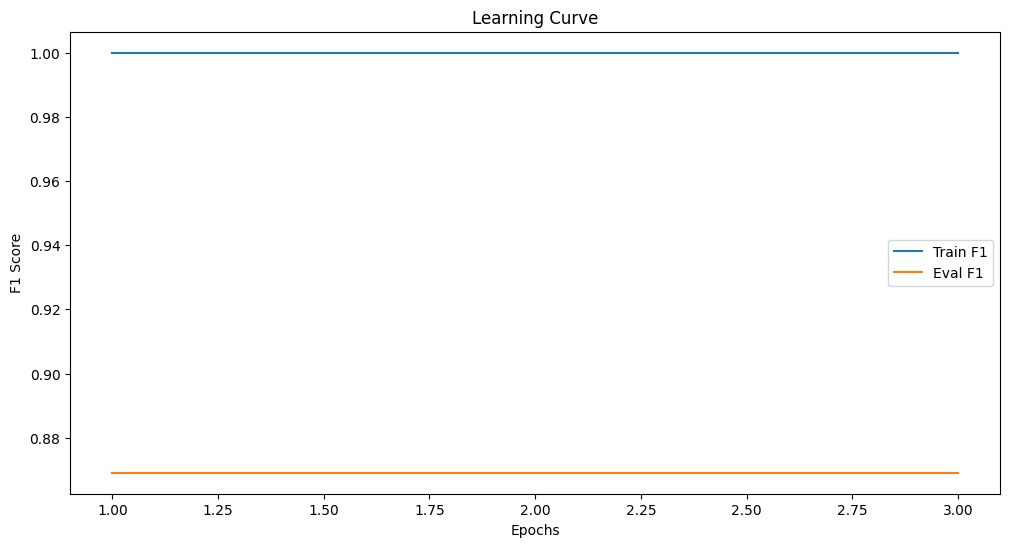

In [15]:
train_predictions = trainer.predict(train_dataset)
train_preds = train_predictions.predictions.argmax(-1)
test_predictions = trainer.predict(test_dataset)
test_preds = test_predictions.predictions.argmax(-1)

train_f1 = f1_score(train_labels, train_preds, average='weighted')
eval_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Train F1 Score: {train_f1:.4f}")
print(f"Eval F1 Score: {eval_f1:.4f}")

epochs = list(range(1, training_args.num_train_epochs + 1))
train_f1_scores = [train_f1] * len(epochs)
eval_f1_scores = [eval_metrics['eval_f1']] * len(epochs)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_f1_scores, label='Train F1')
plt.plot(epochs, eval_f1_scores, label='Eval F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

#### Évaluation du modèle

In [20]:
model = trainer.model
model.eval()

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-5): 6 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=T

In [21]:
# Préparer les données de test
test_encodings = tokenizer(test_sentences, truncation=True, padding=True)
test_input_ids = torch.tensor(test_encodings['input_ids'])
test_attention_mask = torch.tensor(test_encodings['attention_mask'])

In [22]:
# Prédictions
with torch.no_grad():
    outputs = model(test_input_ids, attention_mask=test_attention_mask)
    predictions = torch.argmax(outputs.logits, dim=-1)
    print(predictions)

tensor([1, 1, 1,  ..., 0, 1, 1])


In [23]:
# Calcul des métriques
f1 = f1_score(test_labels, predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")
recall = recall_score(test_labels, predictions, average='weighted')
print(f"Recall: {recall:.4f}")
precision = precision_score(test_labels, predictions, average='weighted')
print(f"Precision: {precision:.4f}")

F1 Score: 0.6572
Recall: 0.6845
Precision: 0.7707


#### Matrice de confusion

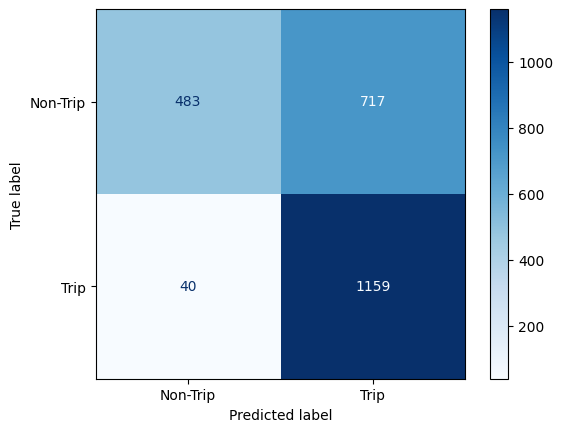

In [24]:
# Convertir les prédictions et les labels en numpy array
if isinstance(predictions, torch.Tensor):
    predictions = predictions.numpy()
test_labels = np.array(test_labels)

cm = confusion_matrix(test_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Trip', 'Trip'])
disp.plot(cmap='Blues')
plt.show()

### Avec Dataloader PyTorch

In [ ]:
# charge le tokenizer pré-entraîné pour le modèle camembert-base
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# préparer les données d'entraînement : tokenisation des phrases
# tokenise les phrases d'entraînement en utilisant le tokenizer Camembert
train_encodings = tokenizer(train_sentences, truncation=True, padding=True)

# convertit les identifiants de tokens, les masques d'attention et les étiquettes d'entraînement en un tenseur PyTorch
train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_mask = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels)

# préparer les données de test
test_encodings = tokenizer(test_sentences, truncation=True, padding=True)

test_input_ids = torch.tensor(test_encodings['input_ids'])
test_attention_mask = torch.tensor(test_encodings['attention_mask'])
test_labels = torch.tensor(test_labels)

c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# création d'un DataLoader pour PyTorch

dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
# Batch de 16 -> 5000
# Batch de 32 -> 2500
# Batch de 64 -> 1250
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(len(dataset))
print(dataloader)

80000


In [ ]:
# fine-tuning du modèle CamemBERT

# charger le modèle pré-entraîné
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=2)
optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# entrainement du modèle
model.train()
for epoch in range(1):
    for batch in dataloader:
        train_input_ids, train_attention_mask, train_labels = batch
        outputs = model(train_input_ids, attention_mask=train_attention_mask, labels=train_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.691073477268219
Epoch 0, Loss: 0.6889106035232544
Epoch 0, Loss: 0.687690258026123
Epoch 0, Loss: 0.6821460723876953
Epoch 0, Loss: 0.6879905462265015
Epoch 0, Loss: 0.6847987174987793
Epoch 0, Loss: 0.6777018904685974
Epoch 0, Loss: 0.6768353581428528
Epoch 0, Loss: 0.6771052479743958
Epoch 0, Loss: 0.6733205318450928
Epoch 0, Loss: 0.6703766584396362
Epoch 0, Loss: 0.6825655102729797
Epoch 0, Loss: 0.6576361656188965
Epoch 0, Loss: 0.666822612285614
Epoch 0, Loss: 0.6730130910873413
Epoch 0, Loss: 0.6536466479301453
Epoch 0, Loss: 0.6611954569816589
Epoch 0, Loss: 0.6413886547088623
Epoch 0, Loss: 0.6479357481002808
Epoch 0, Loss: 0.63427734375
Epoch 0, Loss: 0.6546316742897034
Epoch 0, Loss: 0.6243770718574524
Epoch 0, Loss: 0.6239818334579468
Epoch 0, Loss: 0.6279258131980896
Epoch 0, Loss: 0.609471321105957
Epoch 0, Loss: 0.5951122641563416
Epoch 0, Loss: 0.5987222194671631
Epoch 0, Loss: 0.5725585222244263
Epoch 0, Loss: 0.5816714763641357
Epoch 0, Loss: 0.567053

In [ ]:
# évaluation du modèle

model.eval()
with torch.no_grad():
    outputs = model(test_input_ids, attention_mask=test_attention_mask)
    predictions = torch.argmax(outputs.logits, dim=-1)
    print(predictions)

tensor([0, 0, 1,  ..., 1, 0, 1])


In [ ]:
f1 = f1_score(test_labels, predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")
# recall
# precision
recall = recall_score(test_labels, predictions, average='weighted')
print(f"Recall: {recall:.4f}")

F1 Score: 1.0000
Recall: 1.0000


In [ ]:
print(len(test_labels))

20000


### Fonction pour tester le modèle avec 1 phrase

In [21]:
def predict_sentence(model, tokenizer, sentence):
    model.eval()
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
    return prediction

In [23]:
test_sentence = "Je veux aller à Saint-Denis depuis Cholet."

prediction = predict_sentence(model, tokenizer, test_sentence)
print(f"Prediction for '{test_sentence}': {prediction}")

Prediction for 'Je veux aller à Saint-Denis depuis Cholet.': 1


### SpaCY

In [ ]:
import spacy
from sklearn.metrics import classification_report

In [ ]:
# Chargement du modèle pré-entraîné spaCy (pour le français)
nlp = spacy.load("fr_core_news_sm")

# Fonction pour appliquer spaCy NER sur une phrase
def apply_spacy_ner(sentence):
    doc = nlp(sentence)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Fonction pour déterminer si une phrase est une commande de voyage
def is_trip_order(entities):
    locations = [ent for ent in entities if ent[1] == 'LOC']
    if len(locations) == 2:
        return True, locations[0][0], locations[1][0]
    return False, None, None

print(apply_spacy_ner("je voudrais aller de Toulouse à bordeaux"))
is_trip_order(apply_spacy_ner("je voudrais aller de Toulouse à bordeaux"))

[('Toulouse', 'LOC'), ('bordeaux', 'LOC')]


(True, 'Toulouse', 'bordeaux')

In [ ]:
input_data = [
    "je voudrais aller de Toulouse à bordeaux",
    "Comment me rendre à Port-Boulet depuis la gare de Tours ?",
    "Je veux aller voir mon ami Albert à Tours en partant de Bordeaux",
    "Il y a-t-il des trains de Nantes à Montaigu",
    "Une phrase sans origine ni destination",
    "Si pas de numéro de séquence, on considère que c'est zéro",
    "is there any train going from Paris to Marseille ?"
]

In [ ]:
predicted_labels = []
for i, sentence in enumerate(input_data):
    entities = apply_spacy_ner(sentence)
    is_trip, departure, destination = is_trip_order(entities)
    if is_trip:
        predicted_labels.append(f"{departure},{destination}")
        print(f"{i+1},{departure},{destination}")
    else:
        predicted_labels.append("NOT_TRIP,")
        print(f"{i+1},NOT_TRIP,")

1,Toulouse,bordeaux
2,Port-Boulet,gare de Tours
3,Tours,Bordeaux
4,NOT_TRIP,
5,NOT_TRIP,
6,NOT_TRIP,
7,NOT_TRIP,


In [ ]:
output_data = [
    "1,Toulouse,Bordeaux",
    "2,Tours,Port-Boulet",
    "3,Bordeaux,Tours",
    "4,Nantes,Montaigu",
    "5,NOT_TRIP,",
    "0,NOT_TRIP,",
    "7,NOT_FRENCH,"
]